In [2]:
! pip install neuraloperator

# Data preparation

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.fft
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from torch.utils.data import TensorDataset, DataLoader

In [4]:
from neuralop.data.datasets import DarcyDataset

ds = DarcyDataset(root_dir="./data", n_train= 5000, n_tests= [1000],
                 batch_size = 32, test_batch_sizes = [32, 32],
                 train_resolution= 16,
                 test_resolutions =[16,32],download=True)

ds1 = DarcyDataset(root_dir="./data1", n_train= 5000, n_tests= [1000],
                 batch_size = 32, test_batch_sizes = [32, 32],
                 train_resolution= 32,
                 test_resolutions =[32],download=True)

/srv/conda/envs/notebook/lib/python3.12/site-packages/neuralop/data/datasets/pt_dataset.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(
/srv/conda/en

Loading test db for resolution 16 with 1000 samples 
Loading test db for resolution 32 with 1000 samples 


In [5]:
train_lr = ds.train_db
train_hr = ds1.train_db
test_lr = ds.test_dbs[16]
test_hr = ds1.test_dbs[32]

In [6]:
def return_datasets(dataset):
    loader  = DataLoader(dataset,
                         batch_size=len(dataset),
                         shuffle=False,
                         drop_last=False)
    data = next(iter(loader))
    x_all = data['x']  
    y_all = data['y']
    x_all = x_all.squeeze(1)  # → [1000, 16, 16]
    y_all = y_all.squeeze(1)
    print(x_all.shape, y_all.shape)
    return x_all, y_all

In [7]:
x_lr, y_lr = return_datasets(train_lr)
x_hr, y_hr = return_datasets(train_hr)
x_lr_test, y_lr_test = return_datasets(test_lr)
x_hr_test, y_hr_test = return_datasets(test_hr)

torch.Size([1000, 16, 16]) torch.Size([1000, 16, 16])
torch.Size([5000, 32, 32]) torch.Size([5000, 32, 32])
torch.Size([50, 16, 16]) torch.Size([50, 16, 16])
torch.Size([1000, 32, 32]) torch.Size([1000, 32, 32])


In [8]:
import matplotlib.pyplot as plt

def visualize_pair(x_all, y_all, idx):
    # if torch.Tensor, convert to numpy
    if hasattr(x_all, 'cpu'):
        x = x_all[idx].cpu().numpy()
    else:
        x = x_all[idx]
    if hasattr(y_all, 'cpu'):
        y = y_all[idx].cpu().numpy()
    else:
        y = y_all[idx]

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(x, aspect='equal')
    axes[0].set_title(f'x_all[{idx}]')
    axes[0].axis('off')

    axes[1].imshow(y, aspect='equal')
    axes[1].set_title(f'y_all[{idx}]')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


In [9]:
def visualize_pair_1(x_all, y_all):
    if hasattr(x_all, 'cpu'):
        x = x_all.cpu().detach().numpy()
    else:
        x = x_all
    if hasattr(y_all, 'cpu'):
        y = y_all.cpu().detach().numpy()
    else:
        y = y_all

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(x, aspect='equal')
    axes[0].set_title(f'feature 1')
    axes[0].axis('off')

    axes[1].imshow(y, aspect='equal')
    axes[1].set_title(f'feature 2')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


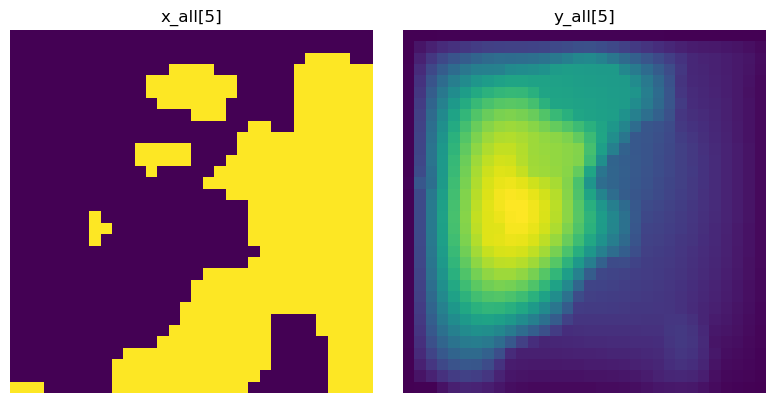

In [10]:
visualize_pair(x_hr_test, y_hr_test, idx=5)

In [67]:
def visualize_fft_invertibility(y_hr, idx=None):
    """
    y_hr: torch.Tensor [N, H, W] high-res dataset
    """
    # pick a random index if not provided
    N = y_hr.shape[0]
    if idx is None:
        idx = random.randint(0, N-1)

    # select sample and add batch & channel dims
    y = y_hr[idx].unsqueeze(0).unsqueeze(0)  # [1,1,H,W]

    # compute real/imag FFT
    Xri = fft_ri(y)  # [1,2,H,W]
    real = Xri[0,0].cpu().numpy()  # [H,W]
    imag = Xri[0,1].cpu().numpy()

    # inverse FFT to recover image
    y_rec = ifft_ri(Xri)[0,0].cpu().numpy()

    # original image
    orig = y[0,0].cpu().numpy()

    # plot
    fig, axs = plt.subplots(1, 4, figsize=(12, 8))

    axs[0].imshow(orig, cmap='viridis')
    axs[0].set_title(f"Original (idx={idx})")
    axs[1].imshow(real, cmap='seismic')
    axs[1].set_title("FFT Real Part")
    axs[2].imshow(imag, cmap='seismic')
    axs[2].set_title("FFT Imag Part")
    axs[3].imshow(y_rec, cmap='viridis')
    axs[3].set_title("Reconstructed")

    for ax in axs.flatten():
        ax.axis('off')
    plt.tight_layout()
    plt.show()


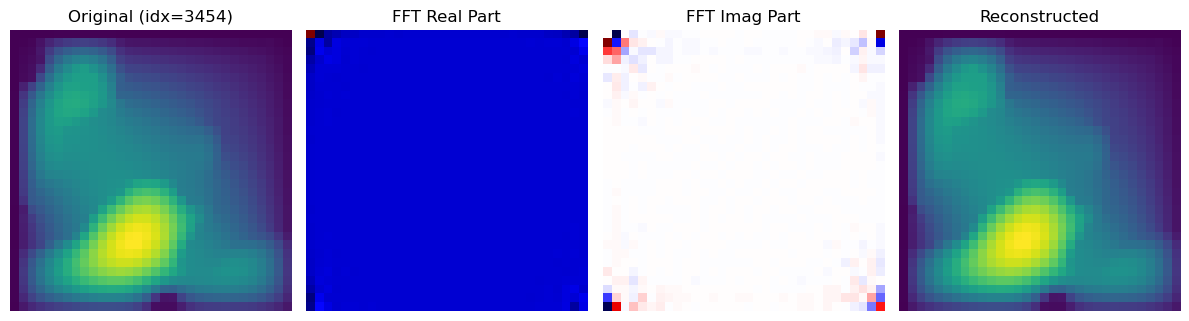

In [70]:
visualize_fft_invertibility(y_hr)

# FFT Functions

These define the fft transform and inverse fft that we use throughout training.

In [78]:
def fft_ri(x: torch.Tensor):
    #returns: [B,2,H,W] real & imag of FFT2(x)
    Xf = torch.fft.fft2(x[:,0])              # [B,H,W], complex
    return torch.stack([Xf.real, Xf.imag],1) # → [B,2,H,W]

def ifft_ri(Xri: torch.Tensor):
    # returns: [B,1,H,W] real spatial field
    Xf = torch.complex(Xri[:,0], Xri[:,1])
    x  = torch.fft.ifft2(Xf).real.unsqueeze(1)
    return x


In [57]:
def run_and_plot(x_raw, y_raw, model, L_min, L_max, title):
    x = x_raw.unsqueeze(0).unsqueeze(0)
    y = y_raw.unsqueeze(0).unsqueeze(0)

    x_fft = fft_transform(x, L_min, L_max)   # [1,2,H,W]
    y_fft = fft_transform(y, L_min, L_max)

    model = model.to("cpu").eval()
    with torch.no_grad():
        y_pred_fft = model(x_fft) 
        
    y_rec     = inverse_fft_transform(y_pred_fft, L_min, L_max)  # [1,1,H,W]
    y_fft_rec = inverse_fft_transform(y_fft,     L_min, L_max)

    x_img      = x_raw.cpu().numpy()
    y_true_img = y_raw.cpu().numpy()
    y_rec_img  = y_rec.squeeze(0).squeeze(0).numpy()
    y_fft_img  = y_fft_rec.squeeze(0).squeeze(0).numpy()

    fig, axs = plt.subplots(1,4, figsize=(16,4))
    axs[0].imshow(x_img,      cmap='viridis'); axs[0].set_title(f"{title}: input x")
    axs[1].imshow(y_true_img, cmap='viridis'); axs[1].set_title(f"{title}: true y")
    axs[2].imshow(y_rec_img,  cmap='viridis'); axs[2].set_title(f"{title}: recon y")
    axs[3].imshow(y_fft_img,  cmap='viridis'); axs[3].set_title(f"{title}: fft recon y")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [75]:
from torch.utils.data import DataLoader, random_split, Dataset
class SpectralRI_Dataset(Dataset):
    """Raw 32×32 → returns x,y as [1,32,32]."""
    def __init__(self, x32: torch.Tensor, y32: torch.Tensor):
        assert x32.shape == y32.shape  # [N,32,32]
        self.x = x32.unsqueeze(1).float()  # [N,1,32,32]
        self.y = y32.unsqueeze(1).float()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [74]:
dataset = SpectralRI_Dataset(x_hr, y_hr)
device = "cuda"
all_raw = torch.cat([dataset[i][0].unsqueeze(0) for i in range(len(dataset))], dim=0)
L_min, L_max = compute_fft_stats(all_raw.to("cuda"))

loader = DataLoader(dataset,
                    batch_size=32,
                    shuffle=True,
                    drop_last=True)

xb, yb = next(iter(loader))
print(xb.shape, yb.shape)  # -> [32,2,16,16]  [32,2,16,16]

torch.Size([32, 1, 32, 32]) torch.Size([32, 1, 32, 32])


# Model defn + training

In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_fft_ri(model: nn.Module,
                 dataset: Dataset,
                 num_epochs=50,
                 batch_size=16,
                 lr=1e-3,
                 val_split=0.1,
                 device="cuda"):
    # split
    N = len(dataset)
    n_val = int(N*val_split)
    n_train = N - n_val
    tr, va = random_split(dataset, [n_train, n_val])
    tr_ld = DataLoader(tr, batch_size=batch_size, shuffle=True, drop_last=True)
    va_ld = DataLoader(va, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    opt   = optim.Adam(model.parameters(), lr=lr)
    mse   = nn.MSELoss()

    best_val = float('inf')
    best_st  = None

    for ep in range(1, num_epochs+1):
        # ——— Train ———
        model.train()
        t_mse = 0.0
        for x_hr, y_hr in tqdm(tr_ld, desc=f"Epoch {ep} Train"):
            x_hr, y_hr = x_hr.to(device), y_hr.to(device)
            # FFT→RI
            X = fft_ri(x_hr)  # [B,2,32,32]
            Y = fft_ri(y_hr)

            opt.zero_grad()
            Yp = model(X)

            # debug visualize first batch first sample
            with torch.no_grad():
                if t_mse==0:
                    y_rec = ifft_ri(Yp[0:1]).cpu().squeeze()
                    y_true= y_hr[0].cpu().squeeze()
                    # visualize training index
                    visualize_pair_1(y_rec, y_true)
                    plt.show()

            loss = mse(Yp, Y)
            loss.backward()
            opt.step()
            t_mse += loss.item()

        # ——— Validate ———
        model.eval()
        v_mse = 0.0
        with torch.no_grad():
            for x_hr, y_hr in va_ld:
                x_hr, y_hr = x_hr.to(device), y_hr.to(device)
                X = fft_ri(x_hr)
                Y = fft_ri(y_hr)
                Yp= model(X)
                v_mse += mse(Yp, Y).item()

        t_avg = t_mse / len(tr_ld)
        v_avg = v_mse / max(len(va_ld),1)
        print(f"Epoch {ep}: Train MSE={t_avg:.6f}  Val MSE={v_avg:.6f}")
        if v_avg < best_val:
            best_val = v_avg
            best_st  = model.state_dict()

    if best_st:
        model.load_state_dict(best_st)
    return model.cpu()


In [44]:
def run_and_plot_ri(x_hr, y_hr, model, title):
    """
    Spectral super-resolution visualization using real/imag FFT.

    Args:
      x_hr, y_hr: torch.Tensor [H, W]  – raw high‑res fields
      model:      SimpleFreqSR or similar on CPU
      title:      str prefix for plot titles
    """
    model = model.to('cpu').eval()

    # [1,1,H,W]
    x_t = x_hr.unsqueeze(0).unsqueeze(0)
    y_t = y_hr.unsqueeze(0).unsqueeze(0)

    # 1) plain FFT→iFFT baseline
    X_ri = fft_ri(x_t)             # [1,2,H,W]
    y_base = ifft_ri(X_ri).squeeze().cpu().numpy()  # [H,W]
    
    # 2) model prediction
    with torch.no_grad():
        Yp = model(X_ri)           # [1,2,H,W]
    y_pred = ifft_ri(Yp).squeeze().cpu().numpy()

    # prepare arrays
    x_img      = x_hr.cpu().numpy()
    y_true_img = y_hr.cpu().numpy()

    # plot
    fig, axs = plt.subplots(1,4, figsize=(16,4))
    axs[0].imshow(x_img,      cmap='viridis'); axs[0].set_title(f"{title}: input (x) HR")
    axs[1].imshow(y_true_img, cmap='viridis'); axs[1].set_title(f"{title}: true (y) HR")
    axs[2].imshow(y_pred,     cmap='viridis'); axs[2].set_title(f"{title}: fft model prediction")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [47]:
class ResBlock(nn.Module):
    """Basic 2‑conv residual block with BatchNorm."""
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(channels)
        self.relu  = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

class FreqResnet(nn.Module):
    """
    Simple FFT super‑res block:
      - Input:  2 × 32 × 32 (real & imag)
      - Output: 2 × 32 × 32 (refined spectrum)
    """
    def __init__(self, in_ch=2, mid_ch=64, n_res=4):
        super().__init__()
        # initial expansion
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, mid_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(mid_ch),
            nn.ReLU(inplace=True)
        )
        # residual stack
        self.res_blocks = nn.Sequential(
            *[ResBlock(mid_ch) for _ in range(n_res)]
        )
        # project back to 2 channels
        self.head = nn.Conv2d(mid_ch, in_ch, 1)

    def forward(self, X):
        """
        X: [B,2,32,32]
        """
        x = self.stem(X)        # → [B,mid_ch,32,32]
        x = self.res_blocks(x)  # → [B,mid_ch,32,32]
        res = self.head(x)      # → [B,2,32,32]
        return X + res          # add residual in spectrum


Epoch 1 Train:   0%|          | 0/140 [00:00<?, ?it/s]

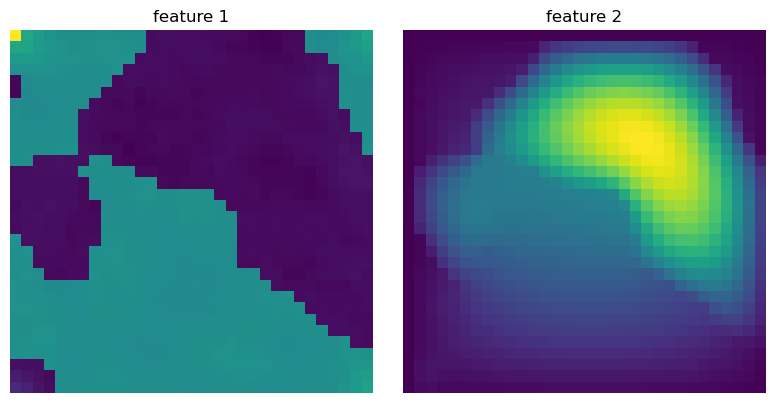

Epoch 1 Train: 100%|██████████| 140/140 [00:02<00:00, 52.36it/s]


Epoch 1: Train MSE=54.074807  Val MSE=16.014139


Epoch 2 Train:   0%|          | 0/140 [00:00<?, ?it/s]

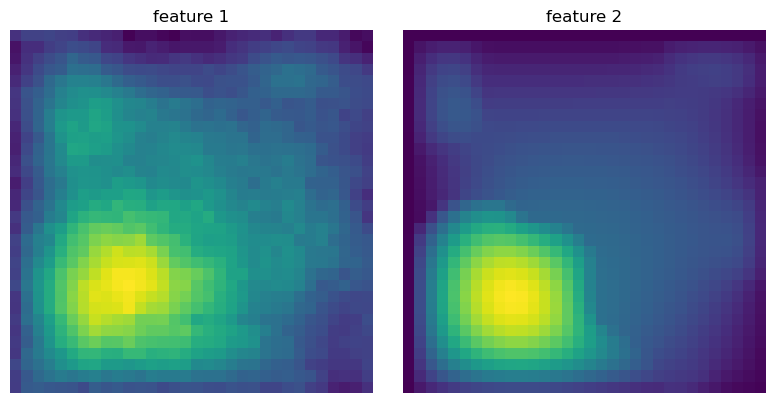

Epoch 2 Train: 100%|██████████| 140/140 [00:02<00:00, 53.03it/s]


Epoch 2: Train MSE=13.803038  Val MSE=13.557413


Epoch 3 Train:   0%|          | 0/140 [00:00<?, ?it/s]

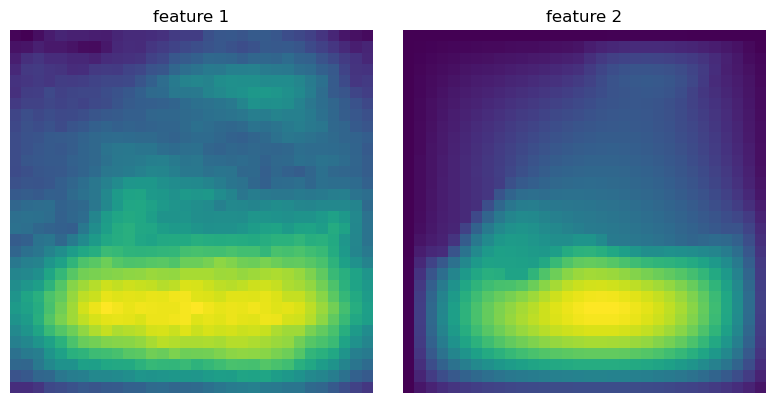

Epoch 3 Train: 100%|██████████| 140/140 [00:02<00:00, 52.95it/s]


Epoch 3: Train MSE=12.223197  Val MSE=12.495812


Epoch 4 Train:   0%|          | 0/140 [00:00<?, ?it/s]

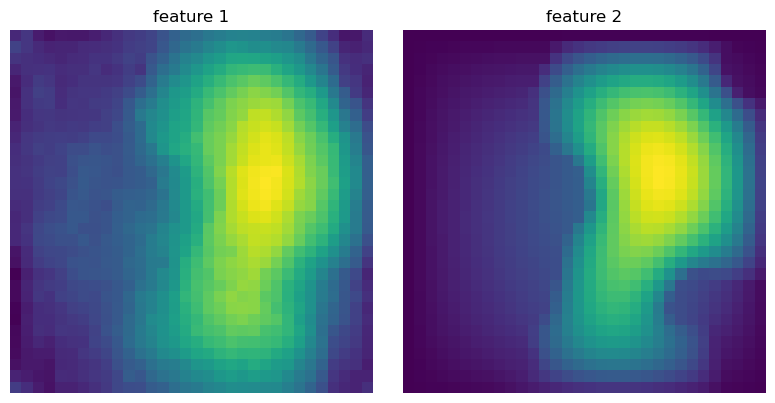

Epoch 4 Train: 100%|██████████| 140/140 [00:02<00:00, 52.57it/s]


Epoch 4: Train MSE=11.290686  Val MSE=12.629407


Epoch 5 Train:   0%|          | 0/140 [00:00<?, ?it/s]

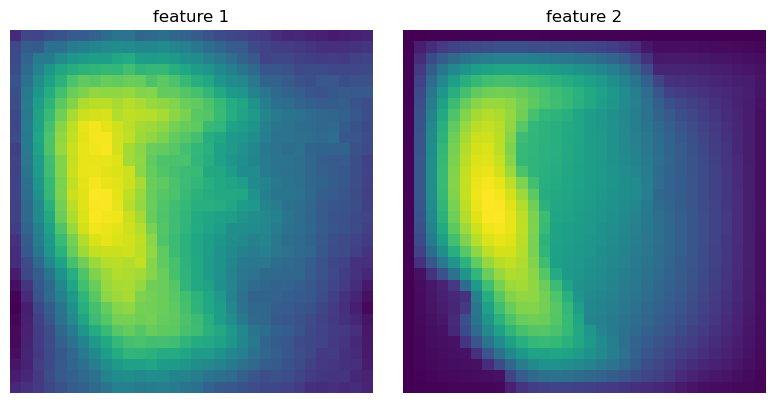

Epoch 5 Train: 100%|██████████| 140/140 [00:02<00:00, 52.80it/s]


Epoch 5: Train MSE=10.552930  Val MSE=11.981944


Epoch 6 Train:   0%|          | 0/140 [00:00<?, ?it/s]

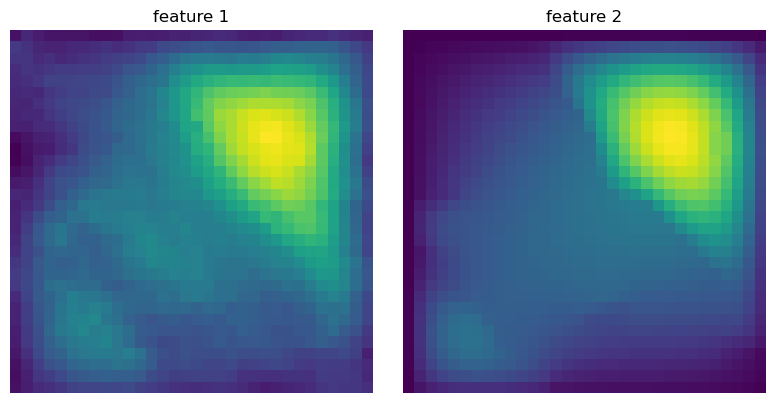

Epoch 6 Train: 100%|██████████| 140/140 [00:02<00:00, 52.72it/s]


Epoch 6: Train MSE=9.795871  Val MSE=11.945794


Epoch 7 Train:   0%|          | 0/140 [00:00<?, ?it/s]

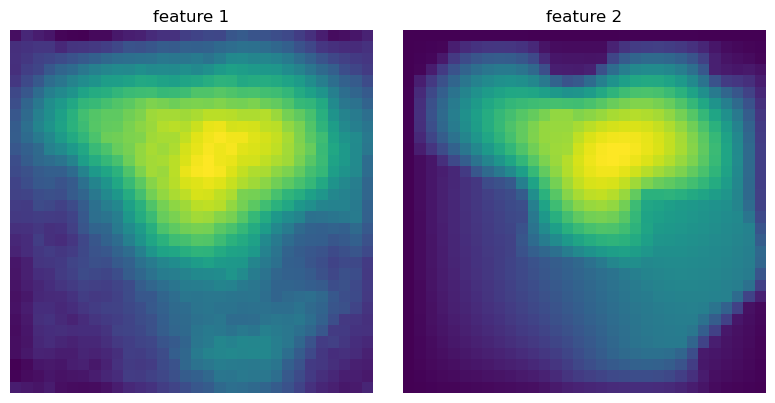

Epoch 7 Train: 100%|██████████| 140/140 [00:02<00:00, 52.71it/s]


Epoch 7: Train MSE=9.447064  Val MSE=10.228649


Epoch 8 Train:   0%|          | 0/140 [00:00<?, ?it/s]

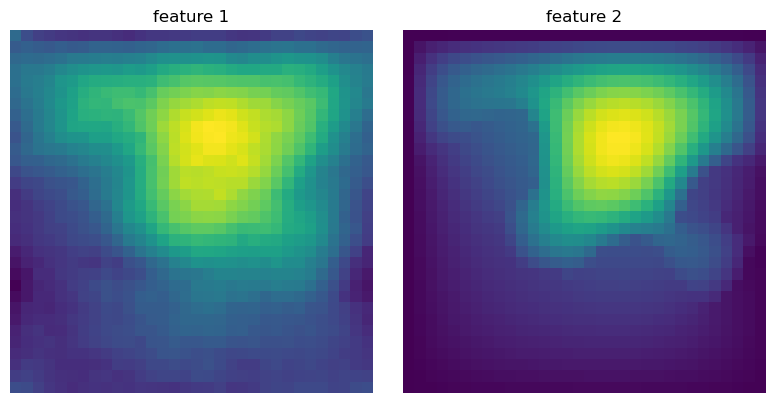

Epoch 8 Train: 100%|██████████| 140/140 [00:02<00:00, 52.93it/s]


Epoch 8: Train MSE=8.893586  Val MSE=9.854432


Epoch 9 Train:   0%|          | 0/140 [00:00<?, ?it/s]

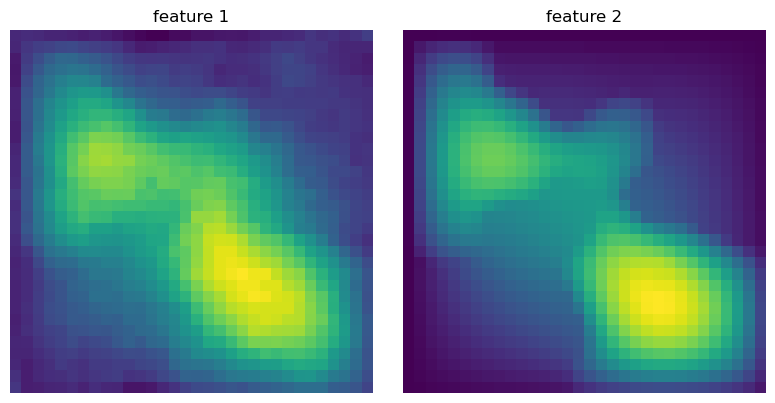

Epoch 9 Train: 100%|██████████| 140/140 [00:02<00:00, 52.87it/s]


Epoch 9: Train MSE=8.582959  Val MSE=9.337179


Epoch 10 Train:   0%|          | 0/140 [00:00<?, ?it/s]

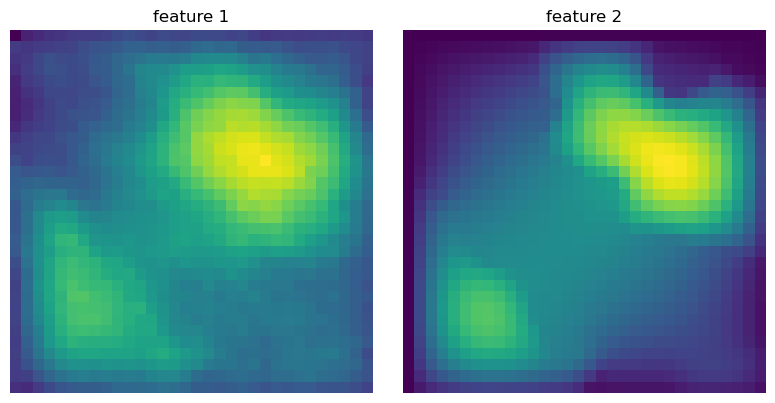

Epoch 10 Train: 100%|██████████| 140/140 [00:02<00:00, 52.93it/s]


Epoch 10: Train MSE=7.929723  Val MSE=10.386110


Epoch 11 Train:   0%|          | 0/140 [00:00<?, ?it/s]

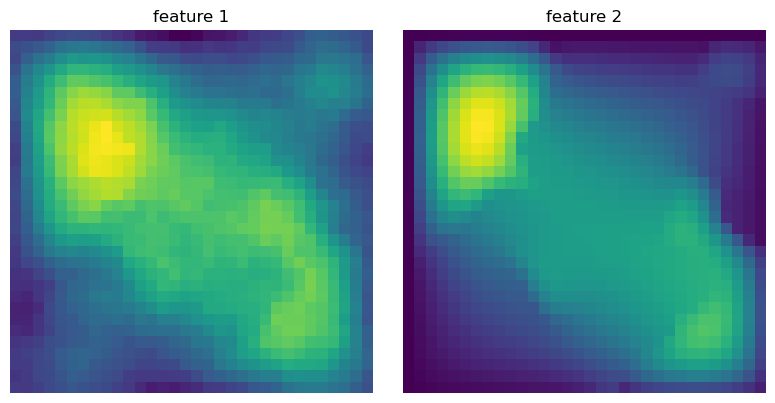

Epoch 11 Train: 100%|██████████| 140/140 [00:02<00:00, 53.09it/s]


Epoch 11: Train MSE=7.789505  Val MSE=8.711521


Epoch 12 Train:   0%|          | 0/140 [00:00<?, ?it/s]

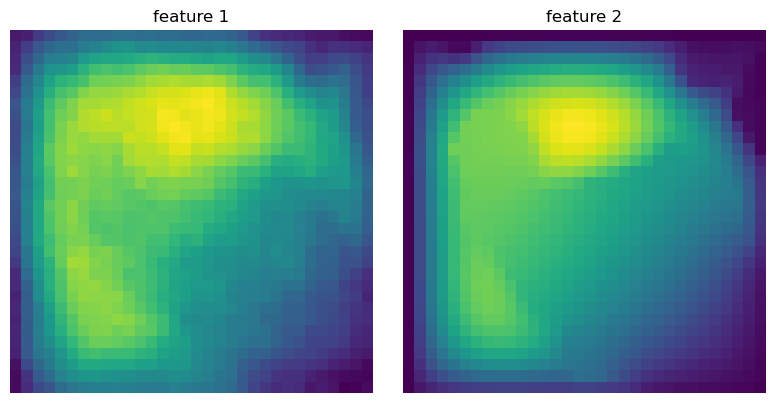

Epoch 12 Train: 100%|██████████| 140/140 [00:02<00:00, 53.00it/s]


Epoch 12: Train MSE=7.196508  Val MSE=8.040365


Epoch 13 Train:   0%|          | 0/140 [00:00<?, ?it/s]

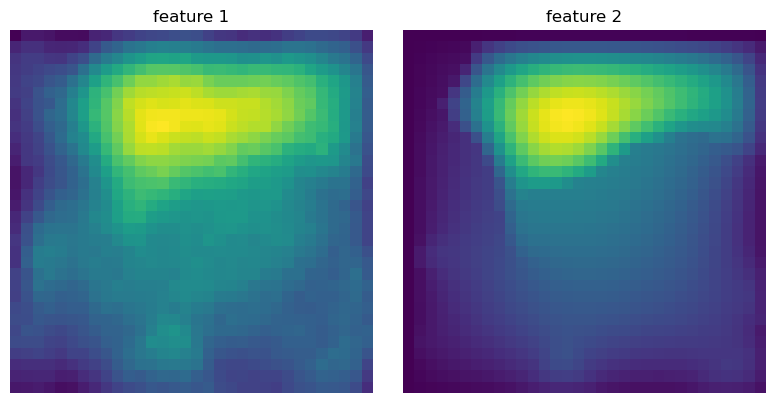

Epoch 13 Train: 100%|██████████| 140/140 [00:02<00:00, 48.36it/s]


Epoch 13: Train MSE=6.964135  Val MSE=10.728963


Epoch 14 Train:   0%|          | 0/140 [00:00<?, ?it/s]

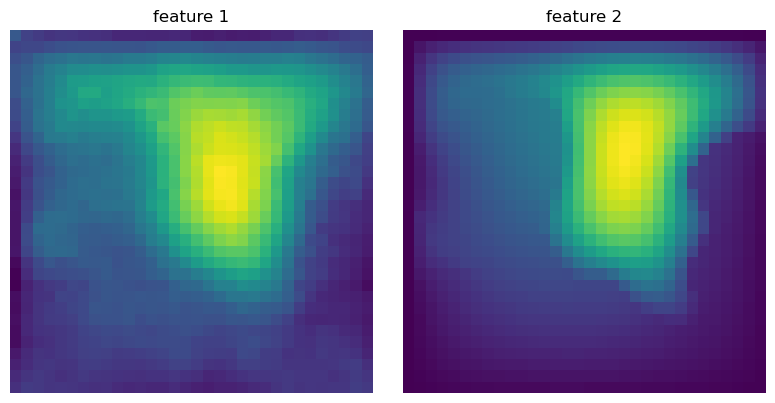

Epoch 14 Train: 100%|██████████| 140/140 [00:02<00:00, 53.10it/s]


Epoch 14: Train MSE=6.861654  Val MSE=8.063957


Epoch 15 Train:   0%|          | 0/140 [00:00<?, ?it/s]

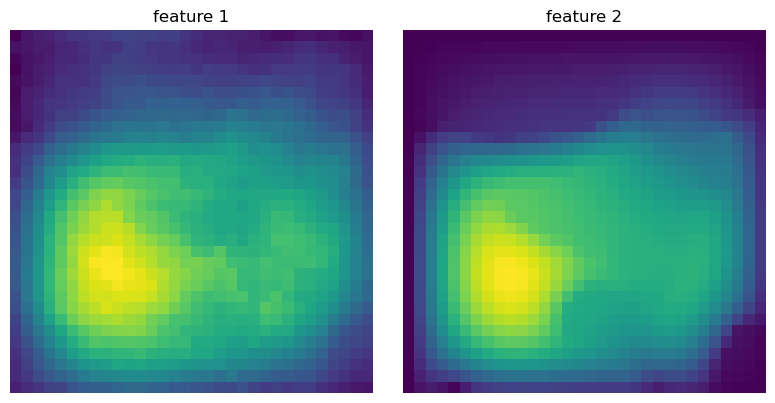

Epoch 15 Train: 100%|██████████| 140/140 [00:02<00:00, 53.29it/s]


Epoch 15: Train MSE=6.716602  Val MSE=8.488916


Epoch 16 Train:   0%|          | 0/140 [00:00<?, ?it/s]

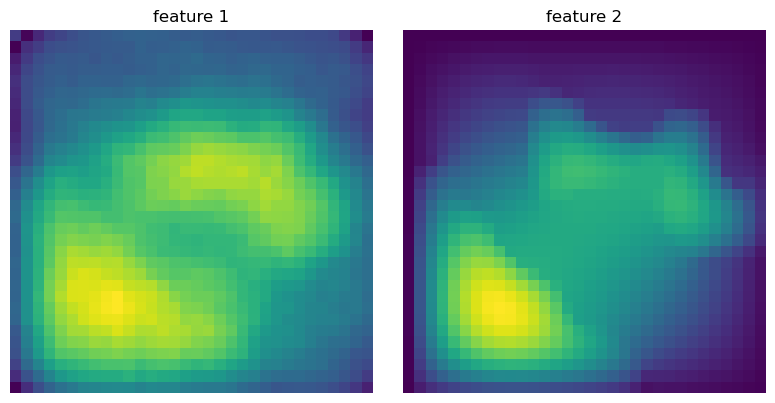

Epoch 16 Train: 100%|██████████| 140/140 [00:02<00:00, 53.06it/s]


Epoch 16: Train MSE=6.561364  Val MSE=14.989901


Epoch 17 Train:   0%|          | 0/140 [00:00<?, ?it/s]

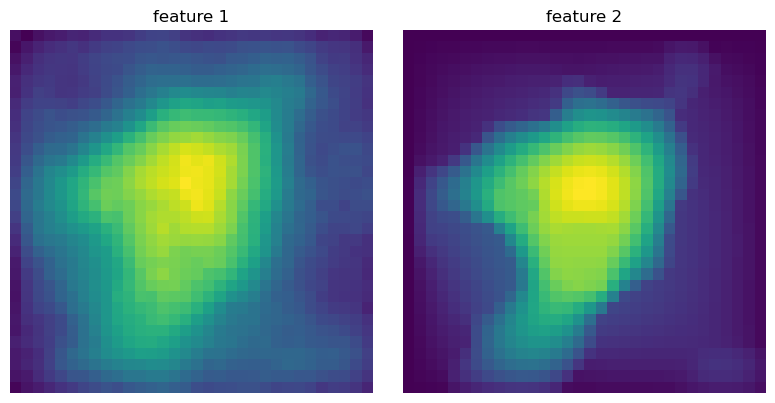

Epoch 17 Train: 100%|██████████| 140/140 [00:02<00:00, 53.33it/s]


Epoch 17: Train MSE=6.341265  Val MSE=7.630832


Epoch 18 Train:   0%|          | 0/140 [00:00<?, ?it/s]

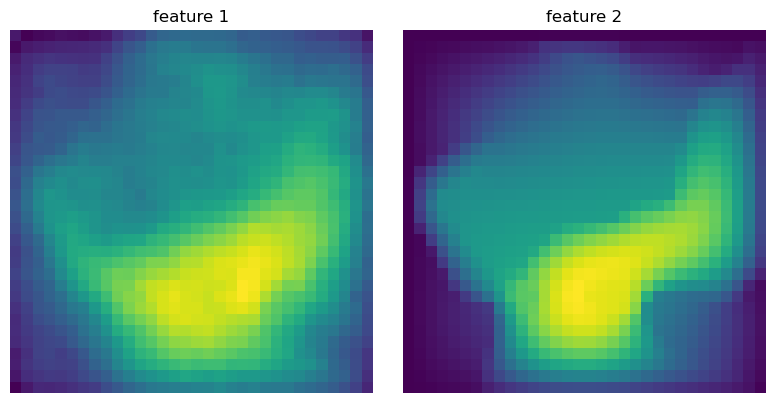

Epoch 18 Train: 100%|██████████| 140/140 [00:02<00:00, 53.20it/s]


Epoch 18: Train MSE=6.140755  Val MSE=7.993894


Epoch 19 Train:   0%|          | 0/140 [00:00<?, ?it/s]

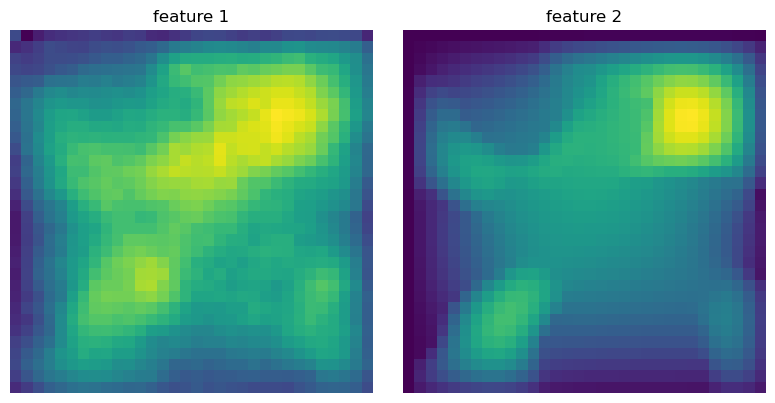

Epoch 19 Train: 100%|██████████| 140/140 [00:02<00:00, 53.47it/s]


Epoch 19: Train MSE=5.943110  Val MSE=8.870685


Epoch 20 Train:   0%|          | 0/140 [00:00<?, ?it/s]

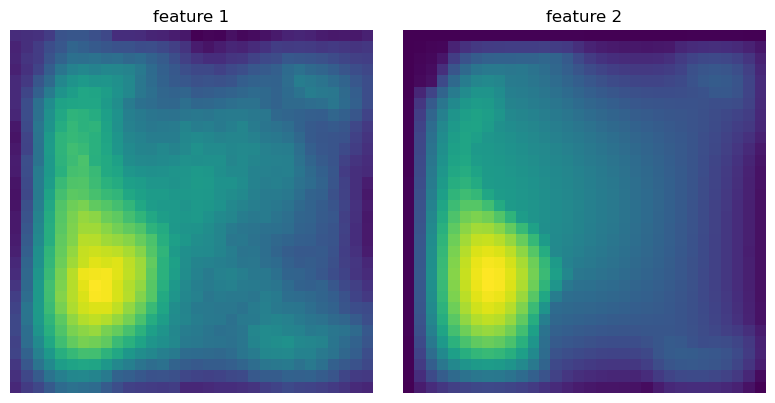

Epoch 20 Train: 100%|██████████| 140/140 [00:02<00:00, 53.34it/s]


Epoch 20: Train MSE=5.948428  Val MSE=7.795548


Epoch 21 Train:   0%|          | 0/140 [00:00<?, ?it/s]

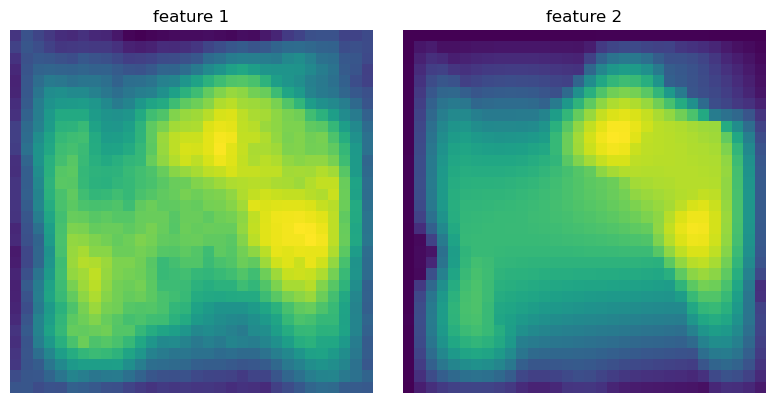

Epoch 21 Train: 100%|██████████| 140/140 [00:02<00:00, 53.47it/s]


Epoch 21: Train MSE=5.802072  Val MSE=7.516502


Epoch 22 Train:   0%|          | 0/140 [00:00<?, ?it/s]

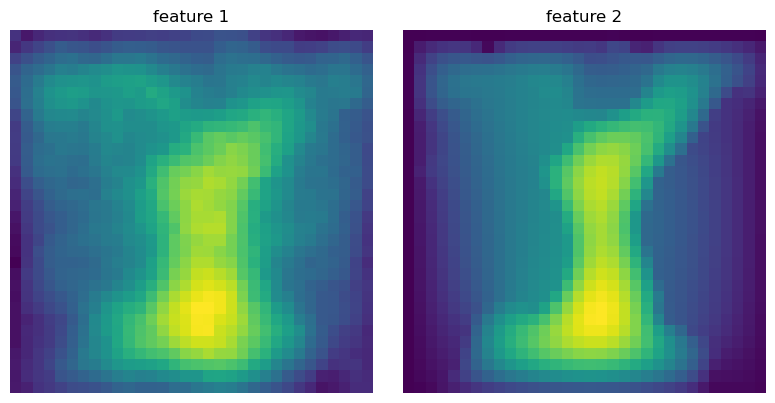

Epoch 22 Train: 100%|██████████| 140/140 [00:02<00:00, 53.28it/s]


Epoch 22: Train MSE=5.828097  Val MSE=7.975960


Epoch 23 Train:   0%|          | 0/140 [00:00<?, ?it/s]

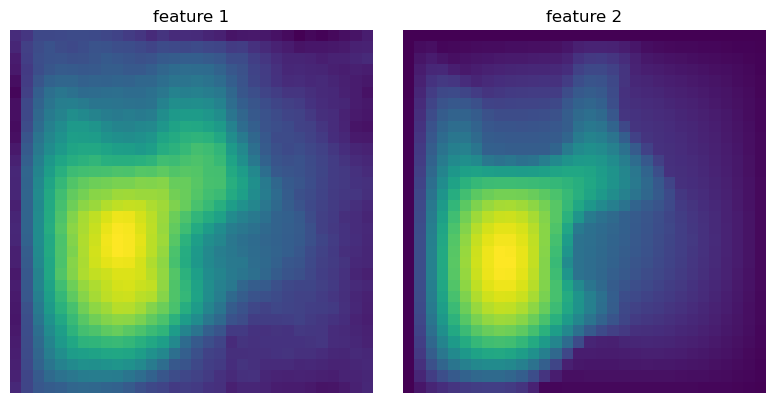

Epoch 23 Train: 100%|██████████| 140/140 [00:02<00:00, 53.36it/s]


Epoch 23: Train MSE=5.585900  Val MSE=9.215520


Epoch 24 Train:   0%|          | 0/140 [00:00<?, ?it/s]

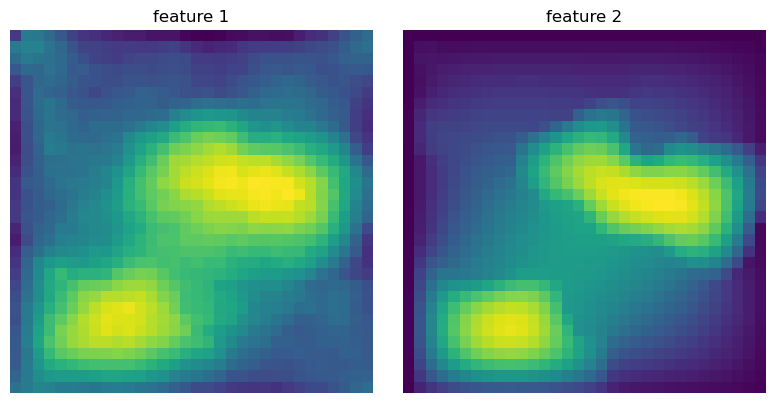

Epoch 24 Train: 100%|██████████| 140/140 [00:02<00:00, 53.21it/s]


Epoch 24: Train MSE=5.622643  Val MSE=7.859168


Epoch 25 Train:   0%|          | 0/140 [00:00<?, ?it/s]

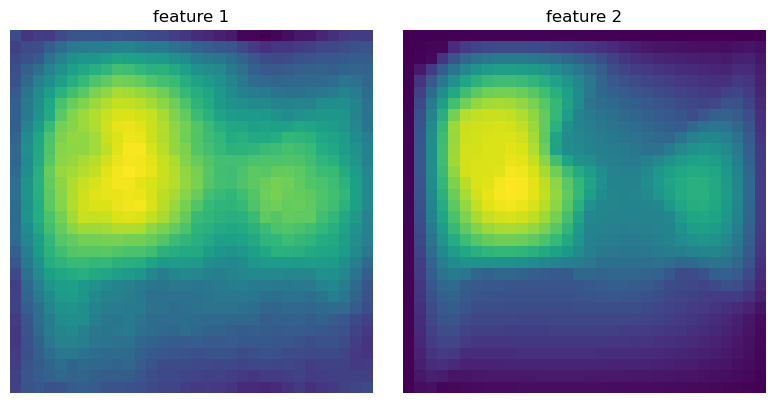

Epoch 25 Train: 100%|██████████| 140/140 [00:02<00:00, 53.28it/s]


Epoch 25: Train MSE=5.418327  Val MSE=7.500588


Epoch 26 Train:   0%|          | 0/140 [00:00<?, ?it/s]

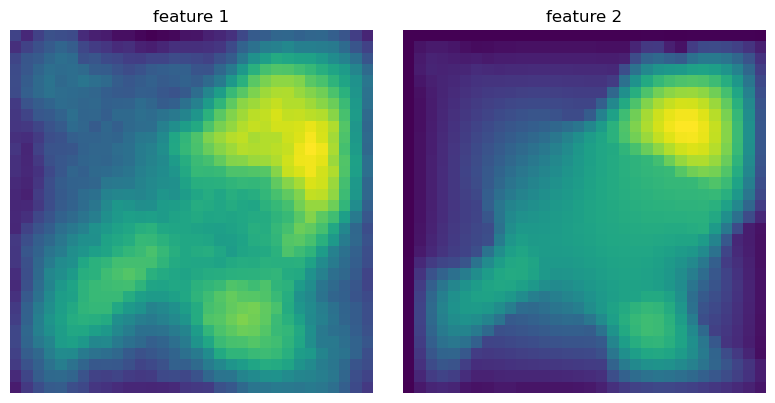

Epoch 26 Train: 100%|██████████| 140/140 [00:02<00:00, 53.35it/s]


Epoch 26: Train MSE=5.524756  Val MSE=6.928726


Epoch 27 Train:   0%|          | 0/140 [00:00<?, ?it/s]

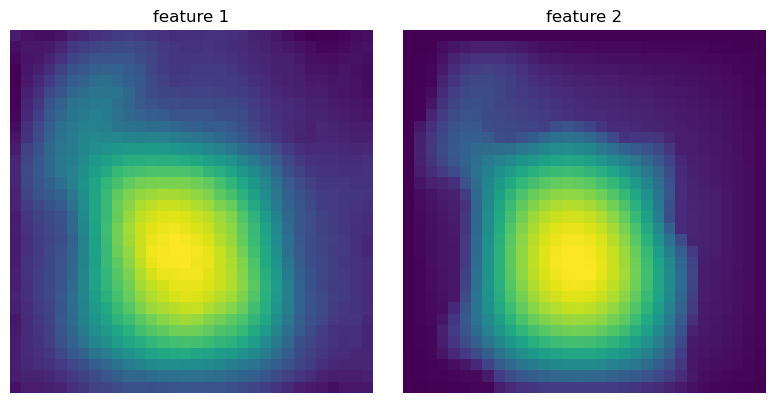

Epoch 27 Train: 100%|██████████| 140/140 [00:02<00:00, 53.28it/s]


Epoch 27: Train MSE=5.374906  Val MSE=7.216913


Epoch 28 Train:   0%|          | 0/140 [00:00<?, ?it/s]

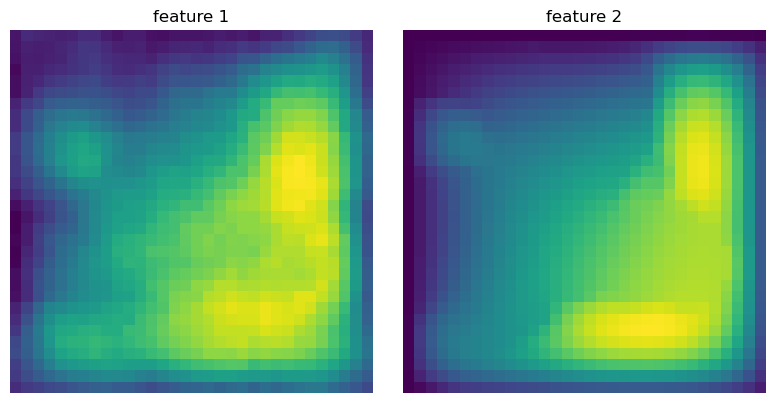

Epoch 28 Train: 100%|██████████| 140/140 [00:02<00:00, 53.22it/s]


Epoch 28: Train MSE=5.309294  Val MSE=8.013212


Epoch 29 Train:   0%|          | 0/140 [00:00<?, ?it/s]

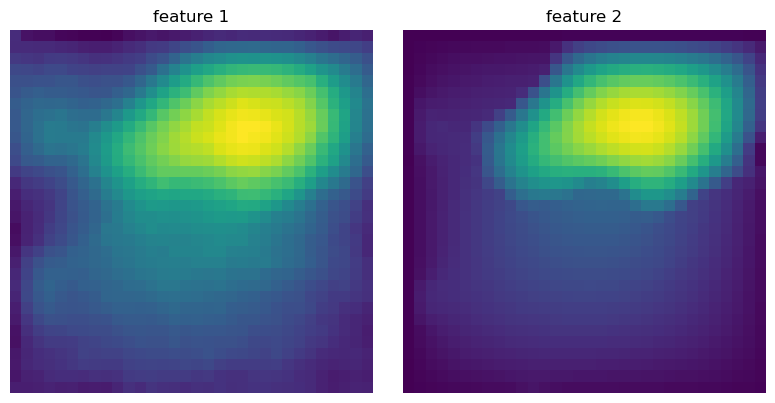

Epoch 29 Train: 100%|██████████| 140/140 [00:02<00:00, 53.10it/s]


Epoch 29: Train MSE=5.171063  Val MSE=7.933671


Epoch 30 Train:   0%|          | 0/140 [00:00<?, ?it/s]

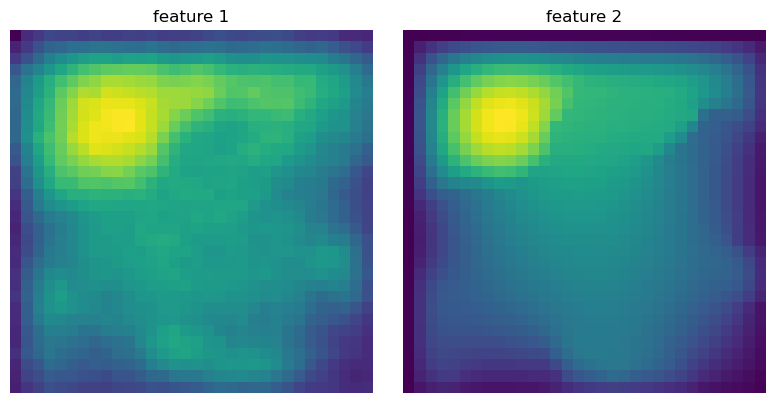

Epoch 30 Train: 100%|██████████| 140/140 [00:02<00:00, 53.20it/s]


Epoch 30: Train MSE=5.141621  Val MSE=7.474246


Epoch 31 Train:   0%|          | 0/140 [00:00<?, ?it/s]

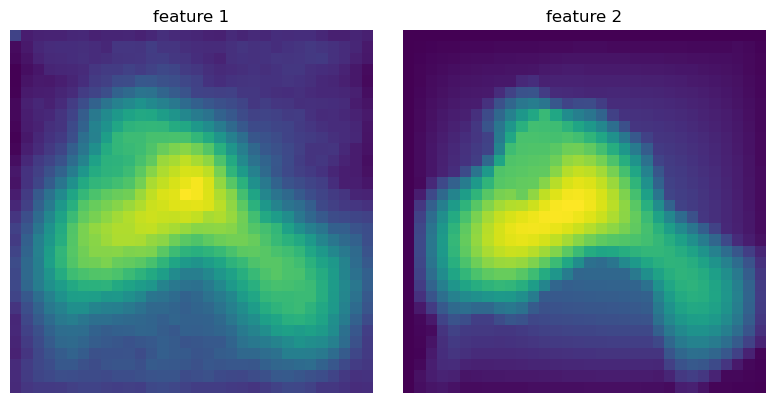

Epoch 31 Train: 100%|██████████| 140/140 [00:02<00:00, 53.26it/s]


Epoch 31: Train MSE=5.091512  Val MSE=7.249368


Epoch 32 Train:   0%|          | 0/140 [00:00<?, ?it/s]

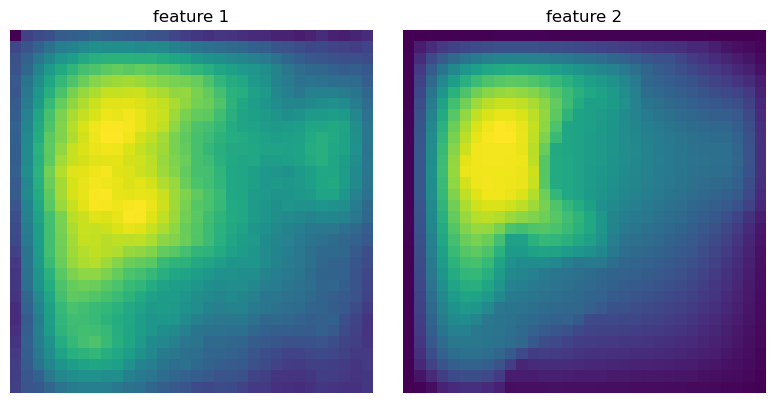

Epoch 32 Train: 100%|██████████| 140/140 [00:02<00:00, 53.20it/s]


Epoch 32: Train MSE=4.975463  Val MSE=7.397951


Epoch 33 Train:   0%|          | 0/140 [00:00<?, ?it/s]

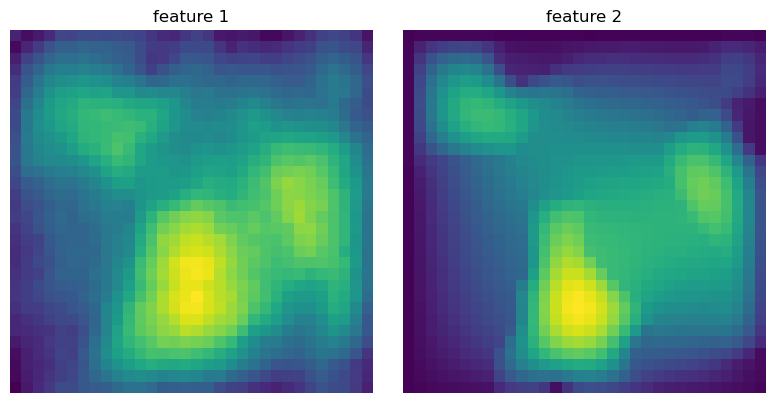

Epoch 33 Train: 100%|██████████| 140/140 [00:02<00:00, 53.00it/s]


Epoch 33: Train MSE=5.072210  Val MSE=8.452878


Epoch 34 Train:   0%|          | 0/140 [00:00<?, ?it/s]

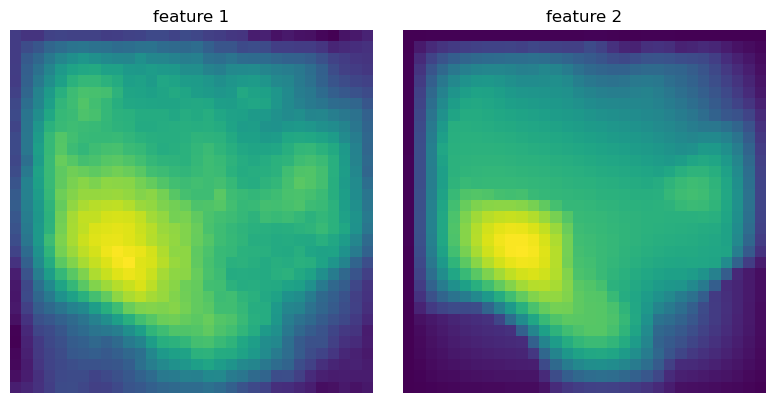

Epoch 34 Train: 100%|██████████| 140/140 [00:02<00:00, 53.07it/s]


Epoch 34: Train MSE=4.884074  Val MSE=6.866827


Epoch 35 Train:   0%|          | 0/140 [00:00<?, ?it/s]

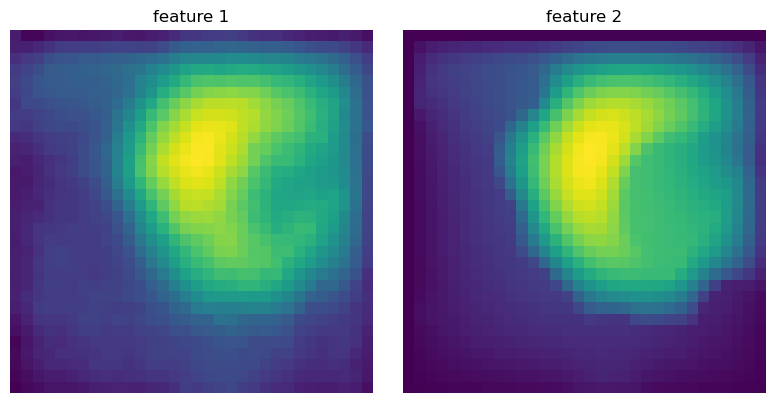

Epoch 35 Train: 100%|██████████| 140/140 [00:02<00:00, 52.83it/s]


Epoch 35: Train MSE=4.863641  Val MSE=7.347066


Epoch 36 Train:   0%|          | 0/140 [00:00<?, ?it/s]

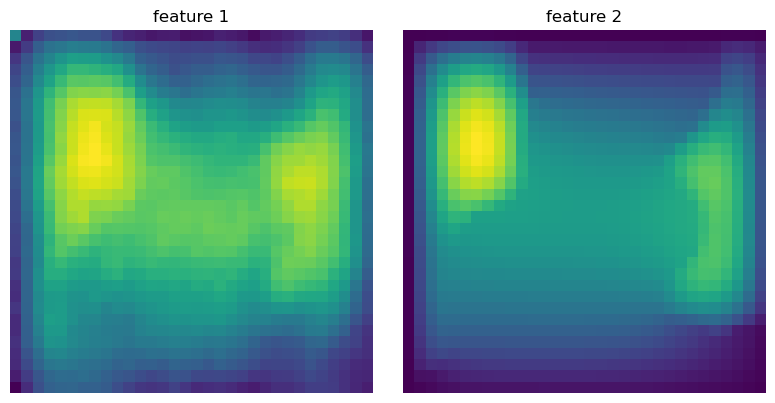

Epoch 36 Train: 100%|██████████| 140/140 [00:02<00:00, 53.09it/s]


Epoch 36: Train MSE=4.768288  Val MSE=10.386342


Epoch 37 Train:   0%|          | 0/140 [00:00<?, ?it/s]

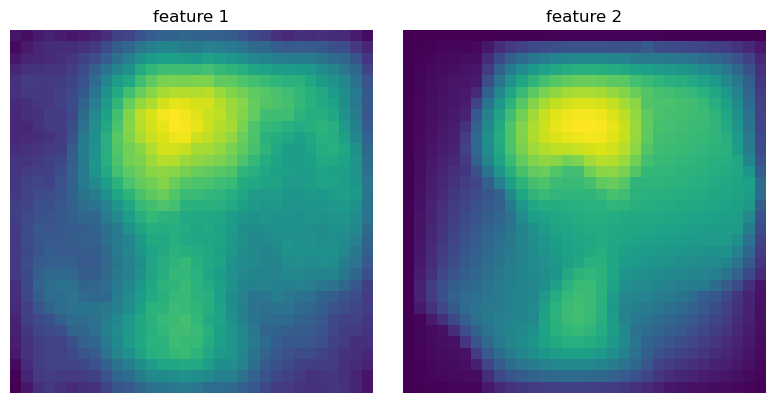

Epoch 37 Train: 100%|██████████| 140/140 [00:02<00:00, 53.23it/s]


Epoch 37: Train MSE=4.633504  Val MSE=7.544638


Epoch 38 Train:   0%|          | 0/140 [00:00<?, ?it/s]

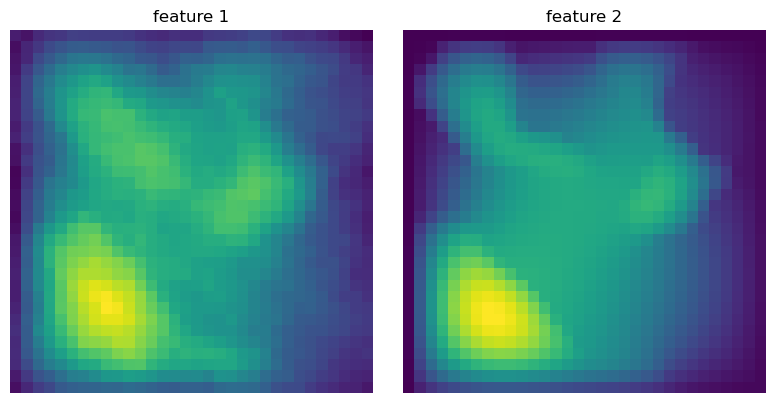

Epoch 38 Train: 100%|██████████| 140/140 [00:02<00:00, 53.07it/s]


Epoch 38: Train MSE=4.598926  Val MSE=7.305278


Epoch 39 Train:   0%|          | 0/140 [00:00<?, ?it/s]

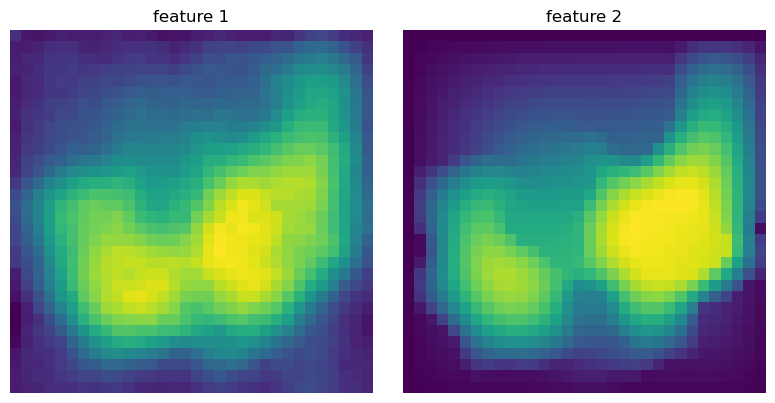

Epoch 39 Train: 100%|██████████| 140/140 [00:02<00:00, 53.04it/s]


Epoch 39: Train MSE=4.504174  Val MSE=7.276718


Epoch 40 Train:   0%|          | 0/140 [00:00<?, ?it/s]

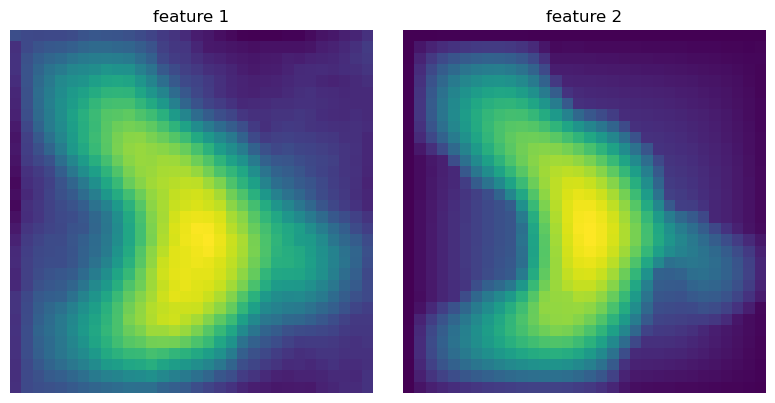

Epoch 40 Train: 100%|██████████| 140/140 [00:02<00:00, 52.84it/s]


Epoch 40: Train MSE=4.451028  Val MSE=7.974814


Epoch 41 Train:   0%|          | 0/140 [00:00<?, ?it/s]

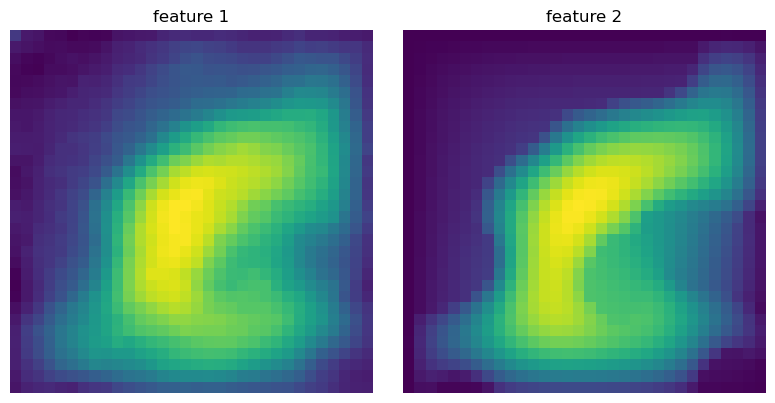

Epoch 41 Train: 100%|██████████| 140/140 [00:02<00:00, 53.25it/s]


Epoch 41: Train MSE=4.490313  Val MSE=7.005897


Epoch 42 Train:   0%|          | 0/140 [00:00<?, ?it/s]

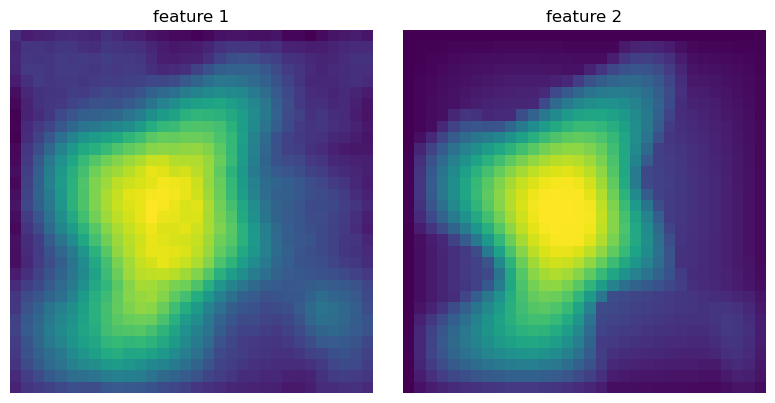

Epoch 42 Train: 100%|██████████| 140/140 [00:02<00:00, 53.36it/s]


Epoch 42: Train MSE=4.445224  Val MSE=7.321388


Epoch 43 Train:   0%|          | 0/140 [00:00<?, ?it/s]

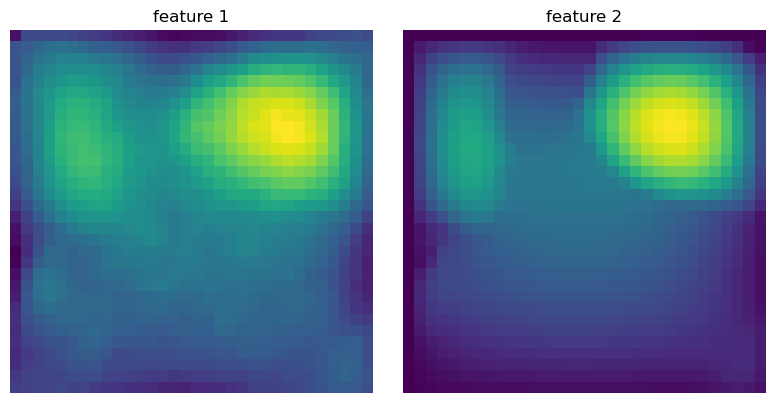

Epoch 43 Train: 100%|██████████| 140/140 [00:02<00:00, 53.22it/s]


Epoch 43: Train MSE=4.536510  Val MSE=6.785328


Epoch 44 Train:   0%|          | 0/140 [00:00<?, ?it/s]

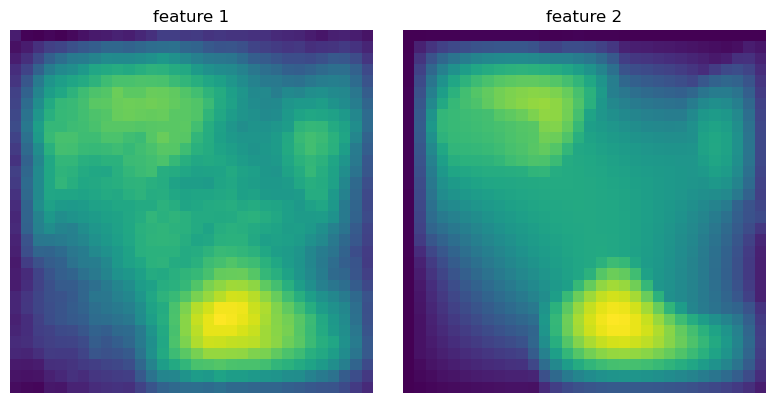

Epoch 44 Train: 100%|██████████| 140/140 [00:02<00:00, 52.86it/s]


Epoch 44: Train MSE=4.404744  Val MSE=6.887878


Epoch 45 Train:   0%|          | 0/140 [00:00<?, ?it/s]

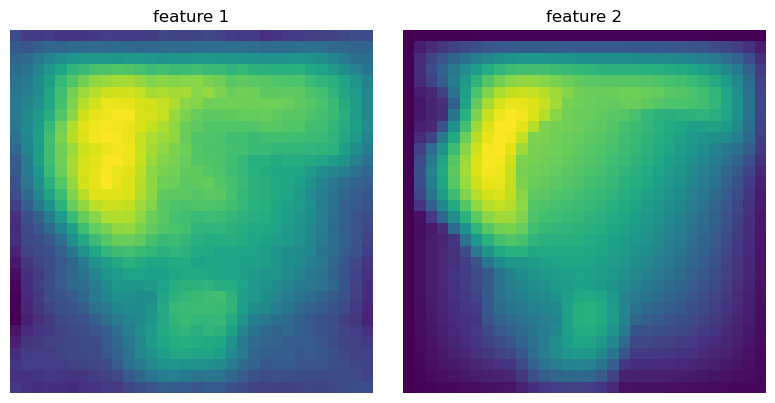

Epoch 45 Train: 100%|██████████| 140/140 [00:02<00:00, 53.07it/s]


Epoch 45: Train MSE=4.170787  Val MSE=7.666483


Epoch 46 Train:   0%|          | 0/140 [00:00<?, ?it/s]

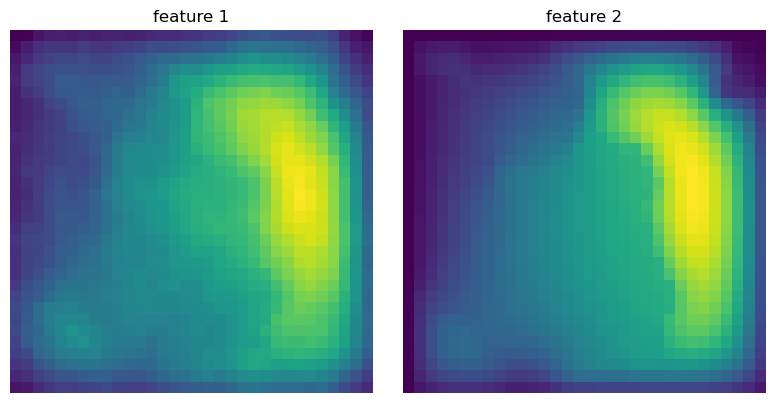

Epoch 46 Train: 100%|██████████| 140/140 [00:02<00:00, 53.12it/s]


Epoch 46: Train MSE=4.253855  Val MSE=9.478183


Epoch 47 Train:   0%|          | 0/140 [00:00<?, ?it/s]

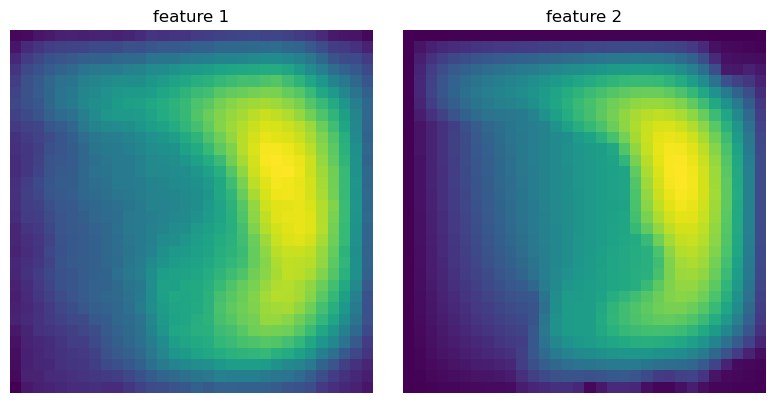

Epoch 47 Train: 100%|██████████| 140/140 [00:02<00:00, 53.24it/s]


Epoch 47: Train MSE=4.229717  Val MSE=7.301170


Epoch 48 Train:   0%|          | 0/140 [00:00<?, ?it/s]

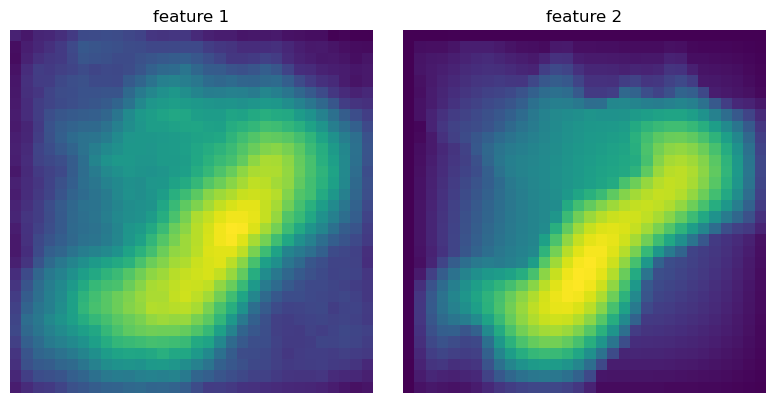

Epoch 48 Train: 100%|██████████| 140/140 [00:02<00:00, 53.08it/s]


Epoch 48: Train MSE=4.179318  Val MSE=7.066030


Epoch 49 Train:   0%|          | 0/140 [00:00<?, ?it/s]

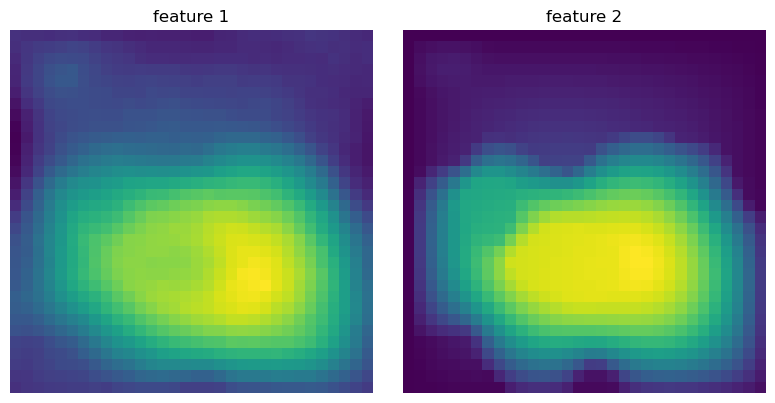

Epoch 49 Train: 100%|██████████| 140/140 [00:02<00:00, 48.23it/s]


Epoch 49: Train MSE=4.056179  Val MSE=7.355726


Epoch 50 Train:   0%|          | 0/140 [00:00<?, ?it/s]

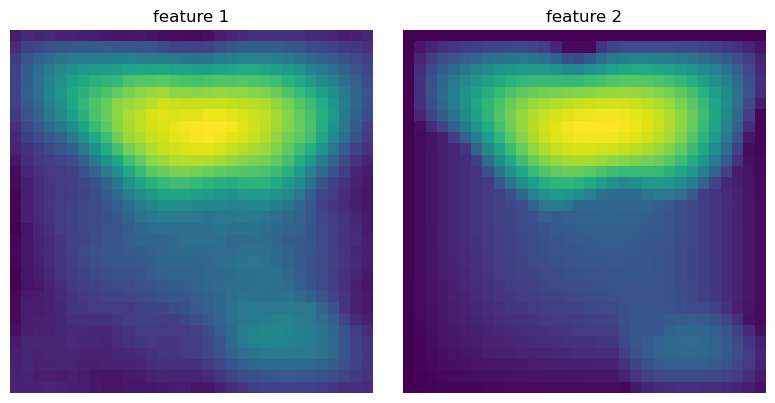

Epoch 50 Train: 100%|██████████| 140/140 [00:02<00:00, 53.00it/s]


Epoch 50: Train MSE=4.082895  Val MSE=7.489689


Epoch 51 Train:   0%|          | 0/140 [00:00<?, ?it/s]

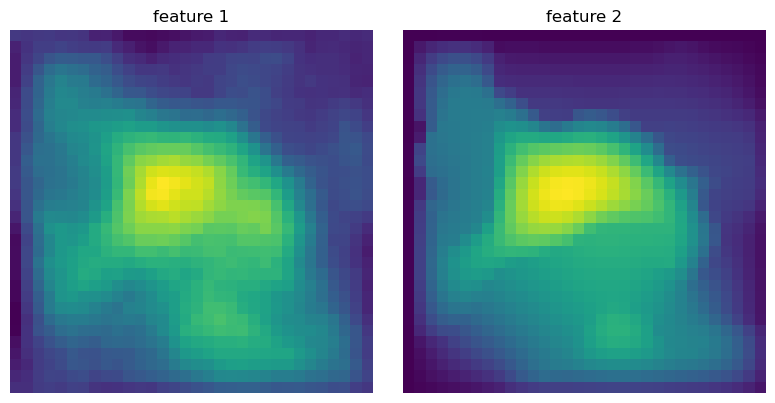

Epoch 51 Train: 100%|██████████| 140/140 [00:02<00:00, 53.28it/s]


Epoch 51: Train MSE=3.885705  Val MSE=7.482744


Epoch 52 Train:   0%|          | 0/140 [00:00<?, ?it/s]

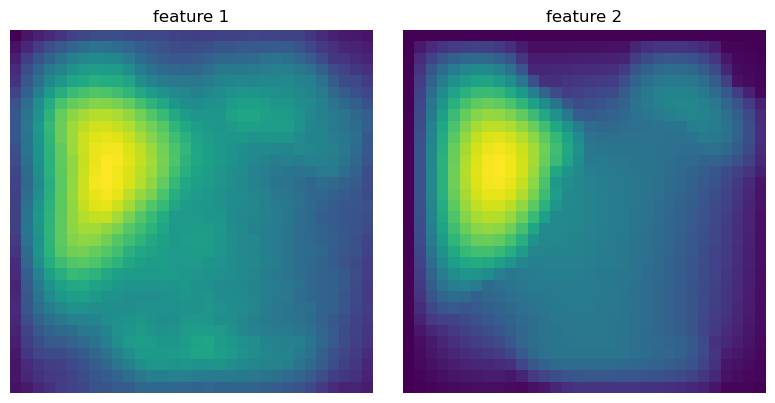

Epoch 52 Train: 100%|██████████| 140/140 [00:02<00:00, 52.95it/s]


Epoch 52: Train MSE=3.976935  Val MSE=7.233987


Epoch 53 Train:   0%|          | 0/140 [00:00<?, ?it/s]

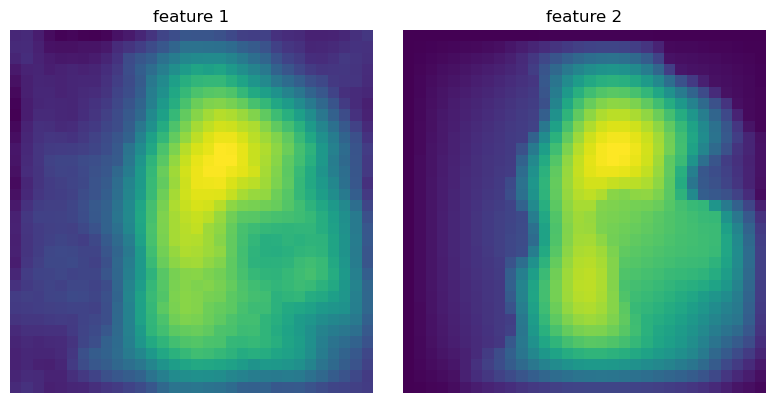

Epoch 53 Train: 100%|██████████| 140/140 [00:02<00:00, 53.00it/s]


Epoch 53: Train MSE=3.883819  Val MSE=7.081501


Epoch 54 Train:   0%|          | 0/140 [00:00<?, ?it/s]

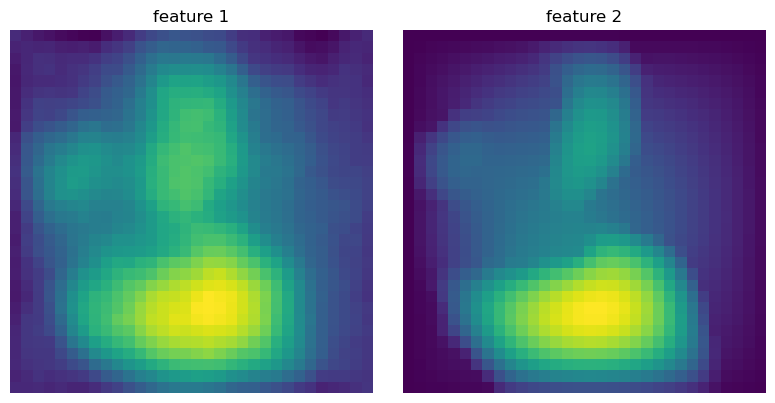

Epoch 54 Train: 100%|██████████| 140/140 [00:02<00:00, 53.31it/s]


Epoch 54: Train MSE=3.909270  Val MSE=7.140756


Epoch 55 Train:   0%|          | 0/140 [00:00<?, ?it/s]

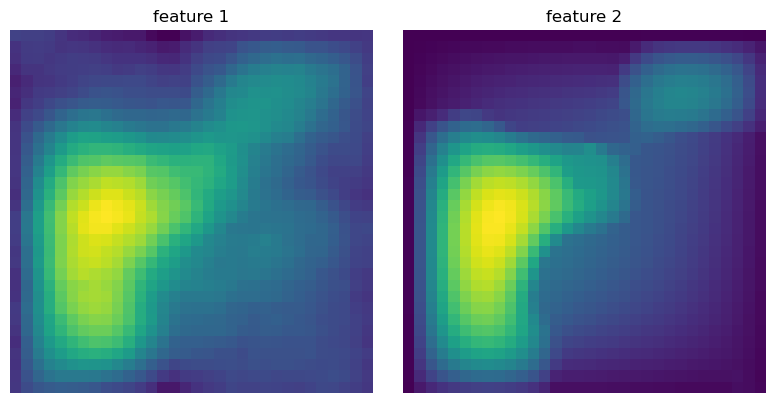

Epoch 55 Train: 100%|██████████| 140/140 [00:02<00:00, 53.41it/s]


Epoch 55: Train MSE=3.804051  Val MSE=6.758576


Epoch 56 Train:   0%|          | 0/140 [00:00<?, ?it/s]

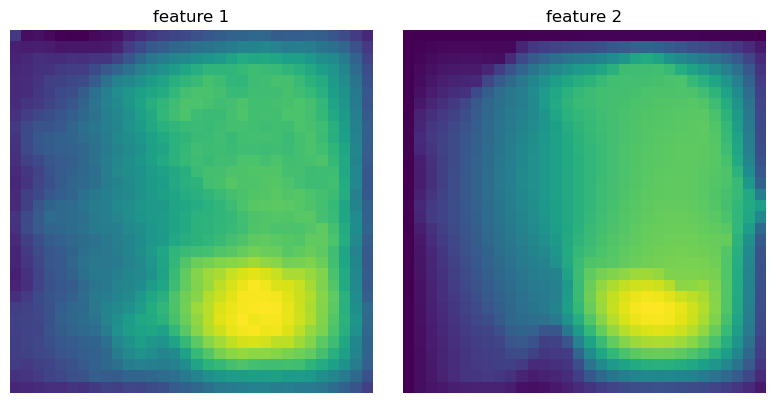

Epoch 56 Train: 100%|██████████| 140/140 [00:02<00:00, 53.29it/s]


Epoch 56: Train MSE=3.775843  Val MSE=6.683828


Epoch 57 Train:   0%|          | 0/140 [00:00<?, ?it/s]

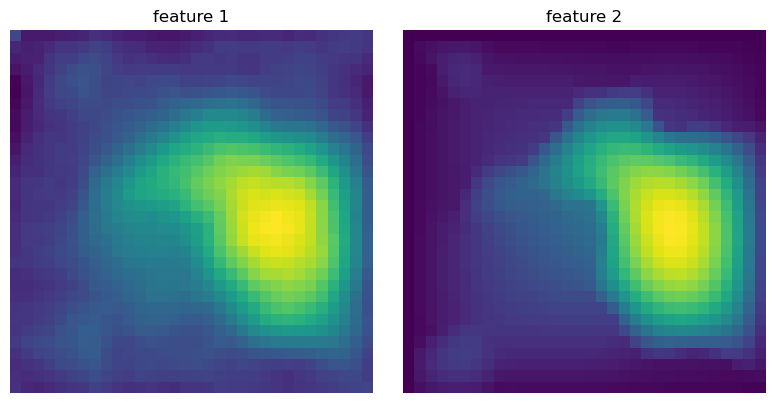

Epoch 57 Train: 100%|██████████| 140/140 [00:02<00:00, 53.16it/s]


Epoch 57: Train MSE=3.686109  Val MSE=7.496390


Epoch 58 Train:   0%|          | 0/140 [00:00<?, ?it/s]

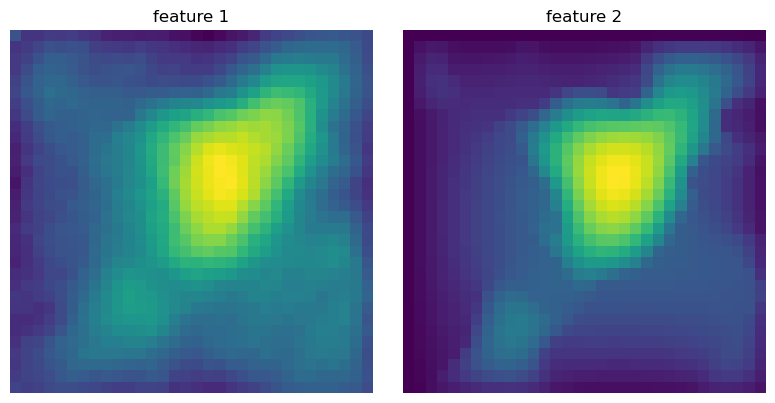

Epoch 58 Train: 100%|██████████| 140/140 [00:02<00:00, 53.19it/s]


Epoch 58: Train MSE=3.702925  Val MSE=7.473283


Epoch 59 Train:   0%|          | 0/140 [00:00<?, ?it/s]

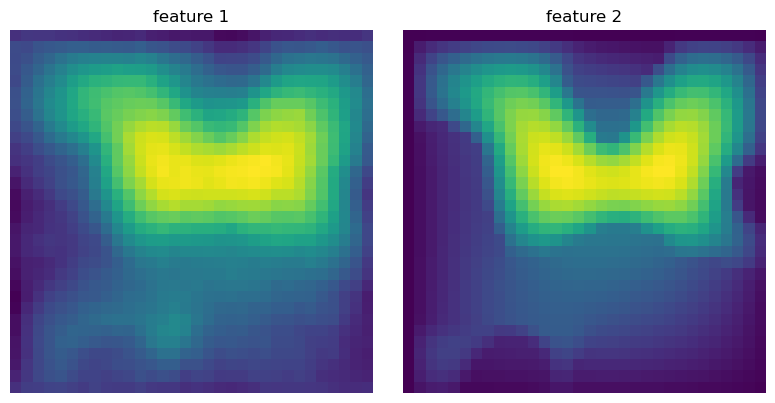

Epoch 59 Train: 100%|██████████| 140/140 [00:02<00:00, 53.40it/s]


Epoch 59: Train MSE=3.680752  Val MSE=7.139985


Epoch 60 Train:   0%|          | 0/140 [00:00<?, ?it/s]

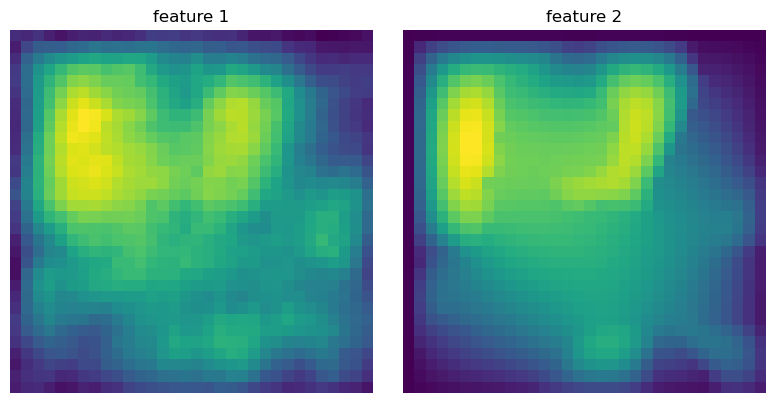

Epoch 60 Train: 100%|██████████| 140/140 [00:02<00:00, 53.26it/s]


Epoch 60: Train MSE=3.586223  Val MSE=6.937384


Epoch 61 Train:   0%|          | 0/140 [00:00<?, ?it/s]

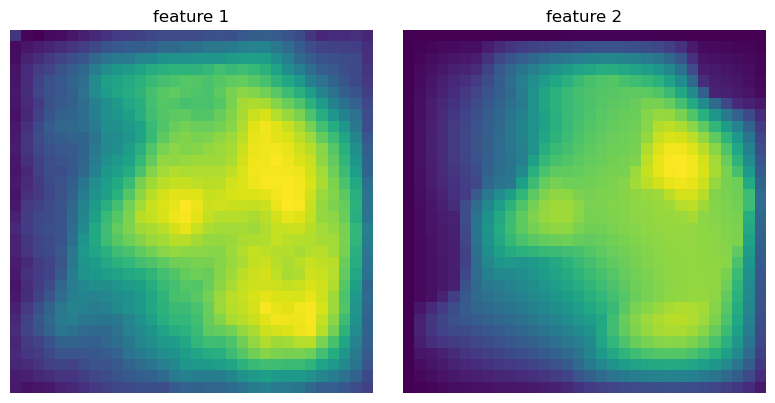

Epoch 61 Train: 100%|██████████| 140/140 [00:02<00:00, 53.38it/s]


Epoch 61: Train MSE=3.600923  Val MSE=6.914391


Epoch 62 Train:   0%|          | 0/140 [00:00<?, ?it/s]

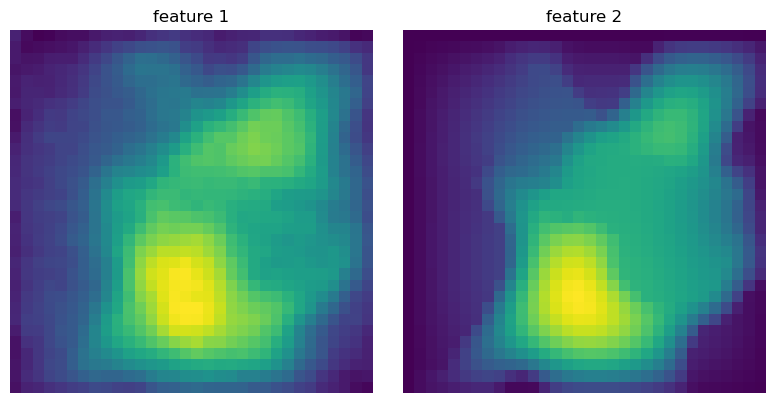

Epoch 62 Train: 100%|██████████| 140/140 [00:02<00:00, 53.22it/s]


Epoch 62: Train MSE=3.551744  Val MSE=6.991936


Epoch 63 Train:   0%|          | 0/140 [00:00<?, ?it/s]

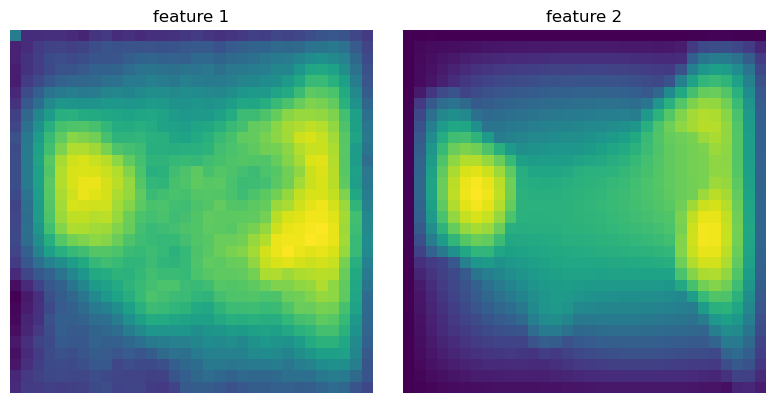

Epoch 63 Train: 100%|██████████| 140/140 [00:02<00:00, 53.10it/s]


Epoch 63: Train MSE=3.581465  Val MSE=8.127798


Epoch 64 Train:   0%|          | 0/140 [00:00<?, ?it/s]

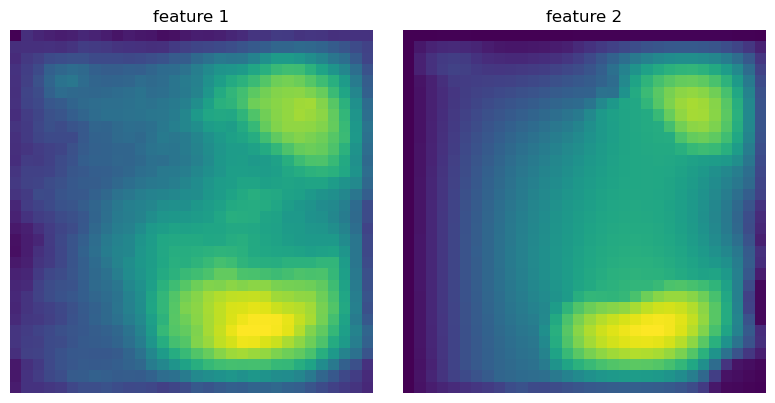

Epoch 64 Train: 100%|██████████| 140/140 [00:02<00:00, 53.08it/s]


Epoch 64: Train MSE=3.465897  Val MSE=6.767924


Epoch 65 Train:   0%|          | 0/140 [00:00<?, ?it/s]

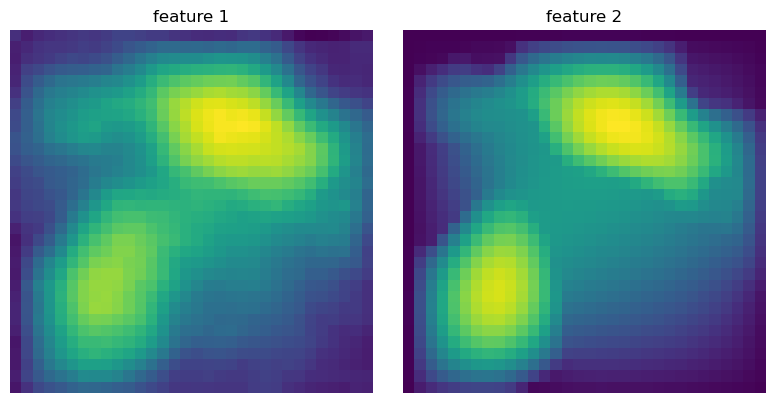

Epoch 65 Train: 100%|██████████| 140/140 [00:02<00:00, 53.31it/s]


Epoch 65: Train MSE=3.269689  Val MSE=7.086694


Epoch 66 Train:   0%|          | 0/140 [00:00<?, ?it/s]

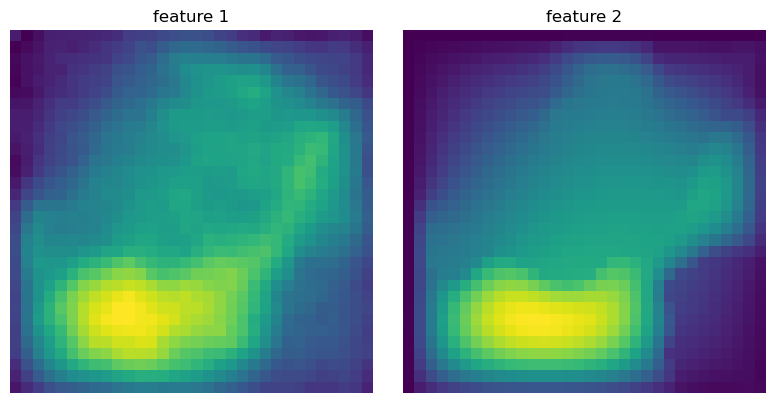

Epoch 66 Train: 100%|██████████| 140/140 [00:02<00:00, 53.04it/s]


Epoch 66: Train MSE=3.352931  Val MSE=6.752356


Epoch 67 Train:   0%|          | 0/140 [00:00<?, ?it/s]

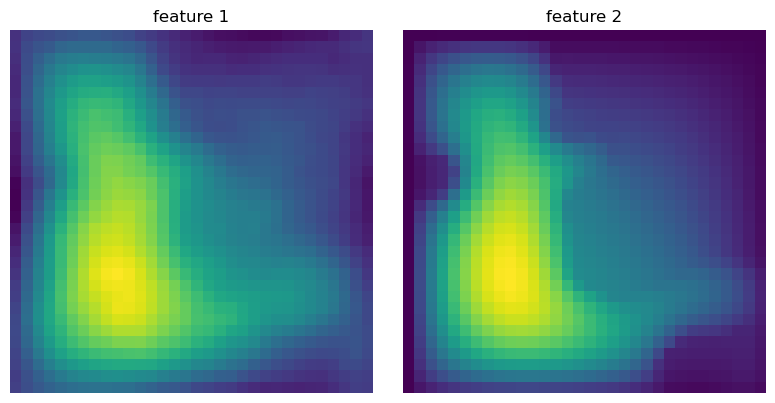

Epoch 67 Train: 100%|██████████| 140/140 [00:02<00:00, 53.26it/s]


Epoch 67: Train MSE=3.325304  Val MSE=7.103170


Epoch 68 Train:   0%|          | 0/140 [00:00<?, ?it/s]

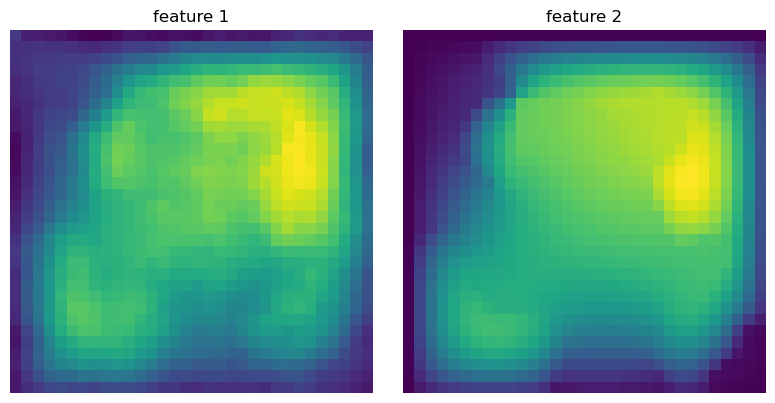

Epoch 68 Train: 100%|██████████| 140/140 [00:02<00:00, 53.03it/s]


Epoch 68: Train MSE=3.261834  Val MSE=7.646347


Epoch 69 Train:   0%|          | 0/140 [00:00<?, ?it/s]

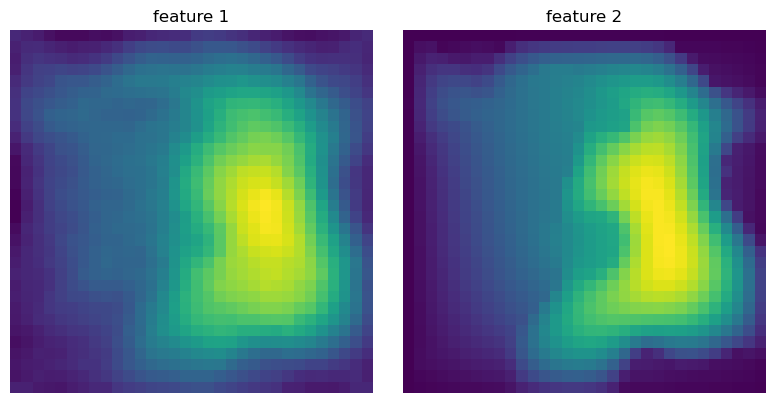

Epoch 69 Train: 100%|██████████| 140/140 [00:02<00:00, 53.25it/s]


Epoch 69: Train MSE=3.182717  Val MSE=7.007737


Epoch 70 Train:   0%|          | 0/140 [00:00<?, ?it/s]

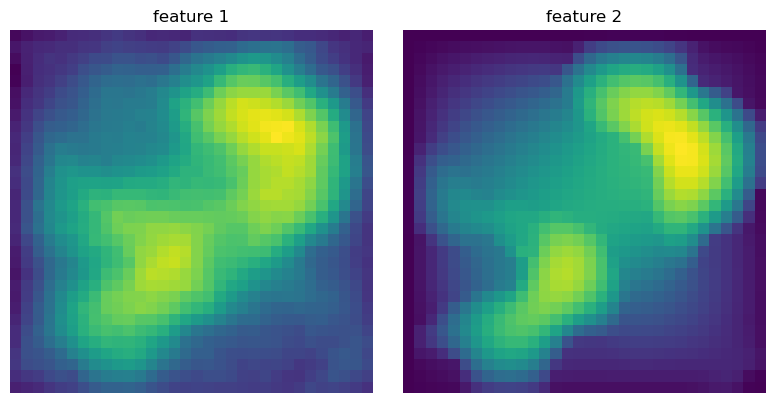

Epoch 70 Train: 100%|██████████| 140/140 [00:02<00:00, 53.20it/s]


Epoch 70: Train MSE=3.132697  Val MSE=7.062961


Epoch 71 Train:   0%|          | 0/140 [00:00<?, ?it/s]

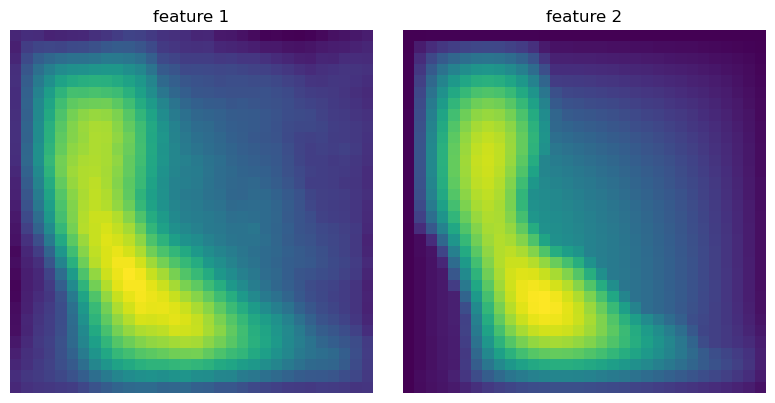

Epoch 71 Train: 100%|██████████| 140/140 [00:02<00:00, 53.32it/s]


Epoch 71: Train MSE=3.142724  Val MSE=6.841311


Epoch 72 Train:   0%|          | 0/140 [00:00<?, ?it/s]

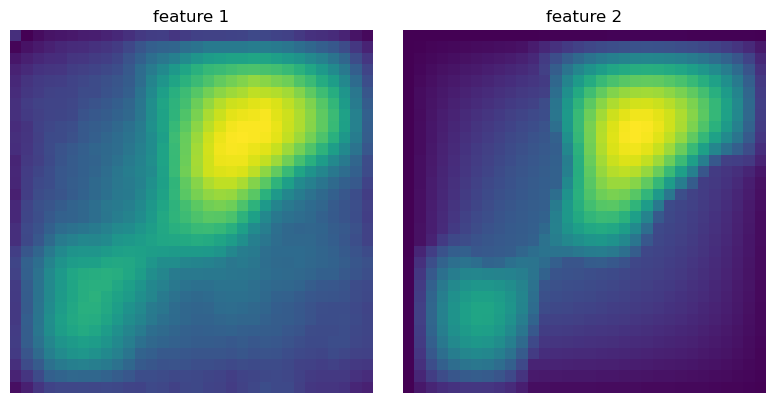

Epoch 72 Train: 100%|██████████| 140/140 [00:02<00:00, 53.24it/s]


Epoch 72: Train MSE=3.091025  Val MSE=6.862558


Epoch 73 Train:   0%|          | 0/140 [00:00<?, ?it/s]

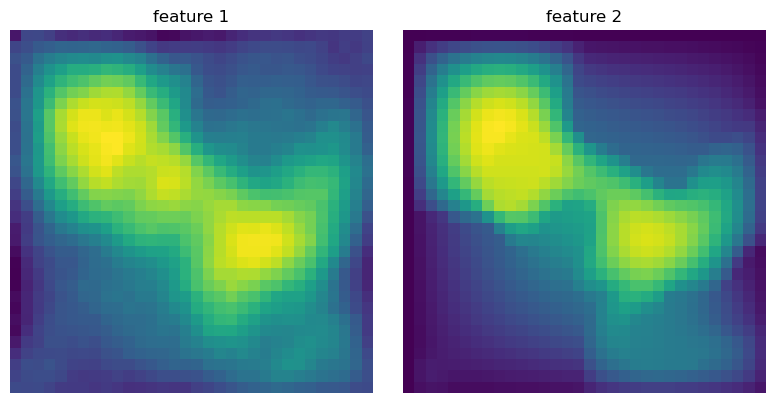

Epoch 73 Train: 100%|██████████| 140/140 [00:02<00:00, 53.21it/s]


Epoch 73: Train MSE=3.200323  Val MSE=7.042246


Epoch 74 Train:   0%|          | 0/140 [00:00<?, ?it/s]

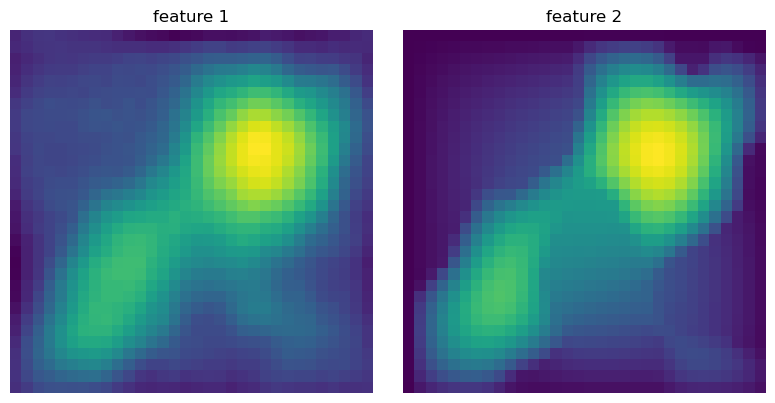

Epoch 74 Train: 100%|██████████| 140/140 [00:02<00:00, 53.15it/s]


Epoch 74: Train MSE=3.115516  Val MSE=7.177348


Epoch 75 Train:   0%|          | 0/140 [00:00<?, ?it/s]

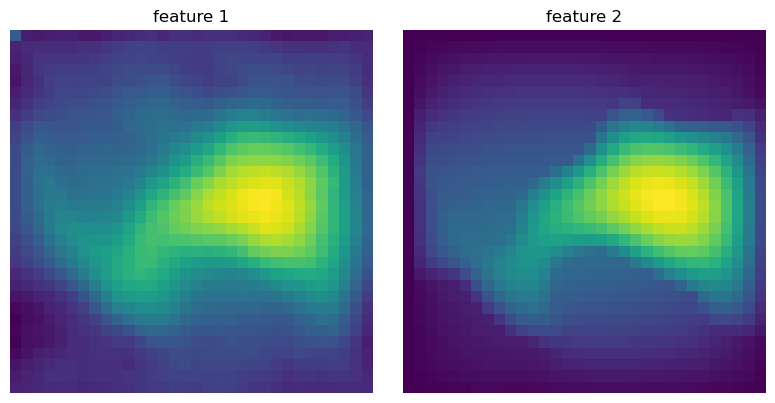

Epoch 75 Train: 100%|██████████| 140/140 [00:02<00:00, 53.39it/s]


Epoch 75: Train MSE=2.933711  Val MSE=6.818031


Epoch 76 Train:   0%|          | 0/140 [00:00<?, ?it/s]

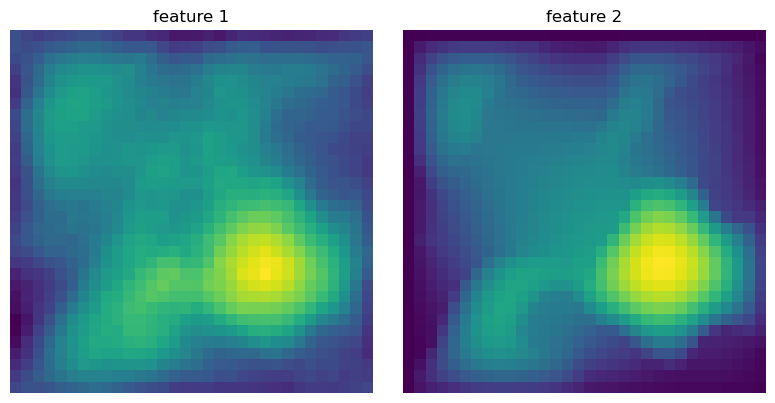

Epoch 76 Train: 100%|██████████| 140/140 [00:02<00:00, 53.42it/s]


Epoch 76: Train MSE=3.013418  Val MSE=6.865983


Epoch 77 Train:   0%|          | 0/140 [00:00<?, ?it/s]

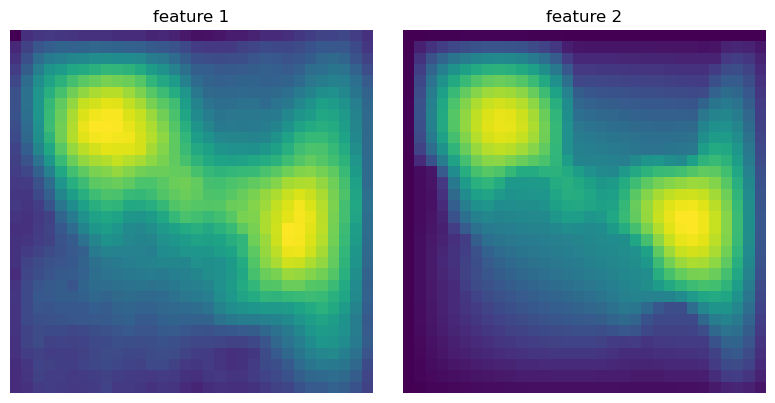

Epoch 77 Train: 100%|██████████| 140/140 [00:02<00:00, 53.43it/s]


Epoch 77: Train MSE=3.051059  Val MSE=7.045732


Epoch 78 Train:   0%|          | 0/140 [00:00<?, ?it/s]

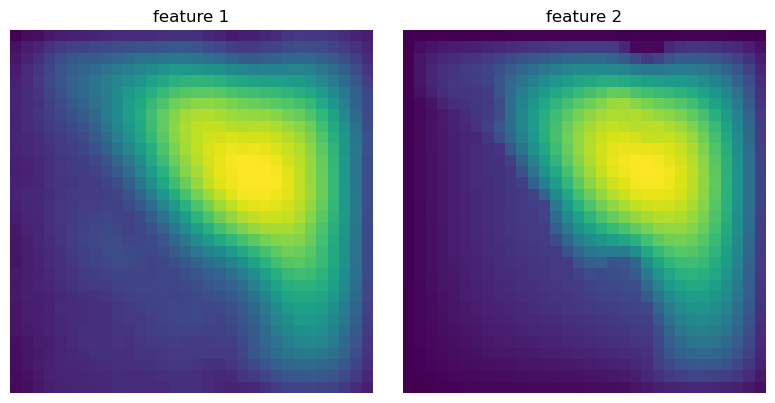

Epoch 78 Train: 100%|██████████| 140/140 [00:02<00:00, 53.09it/s]


Epoch 78: Train MSE=2.952601  Val MSE=7.453008


Epoch 79 Train:   0%|          | 0/140 [00:00<?, ?it/s]

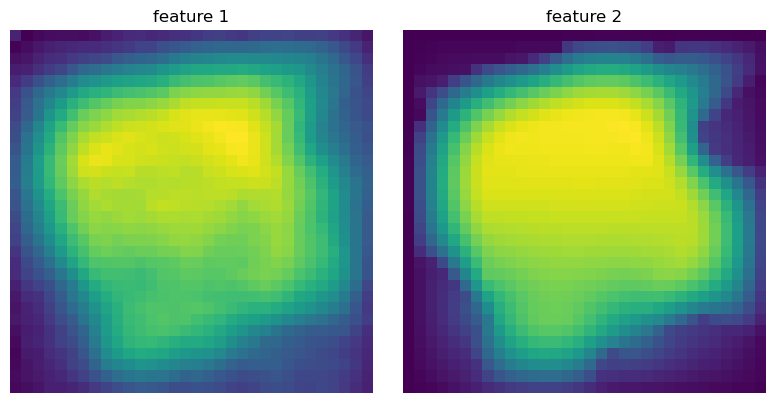

Epoch 79 Train: 100%|██████████| 140/140 [00:02<00:00, 53.39it/s]


Epoch 79: Train MSE=2.879507  Val MSE=7.123645


Epoch 80 Train:   0%|          | 0/140 [00:00<?, ?it/s]

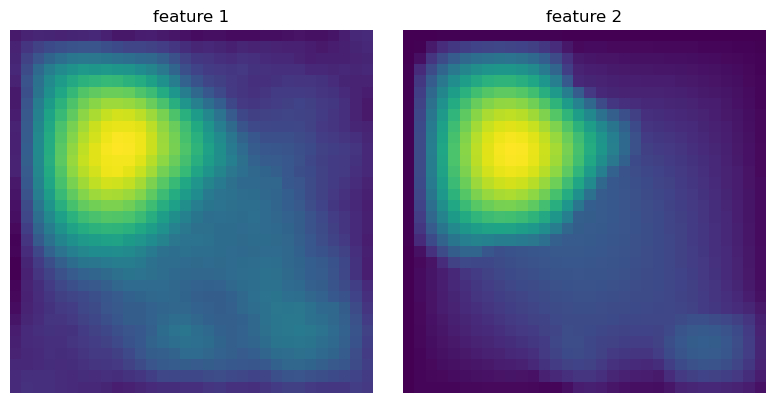

Epoch 80 Train: 100%|██████████| 140/140 [00:02<00:00, 53.16it/s]


Epoch 80: Train MSE=2.883421  Val MSE=7.055061


Epoch 81 Train:   0%|          | 0/140 [00:00<?, ?it/s]

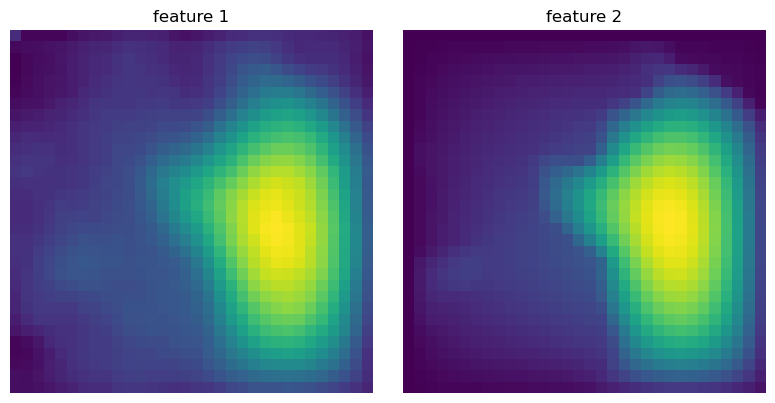

Epoch 81 Train: 100%|██████████| 140/140 [00:02<00:00, 53.07it/s]


Epoch 81: Train MSE=2.798689  Val MSE=6.890408


Epoch 82 Train:   0%|          | 0/140 [00:00<?, ?it/s]

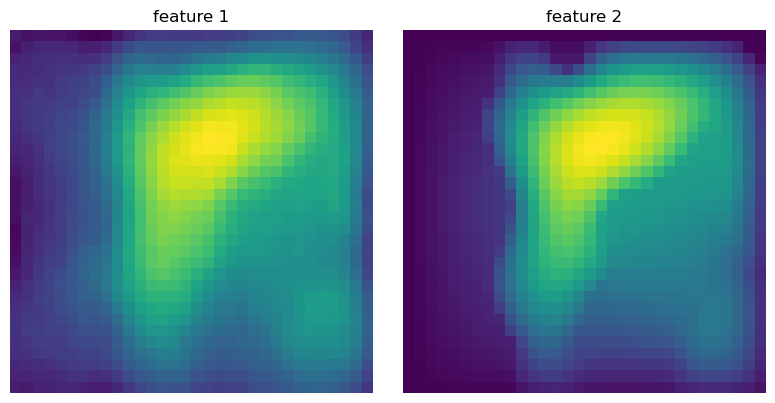

Epoch 82 Train: 100%|██████████| 140/140 [00:02<00:00, 53.19it/s]


Epoch 82: Train MSE=2.751092  Val MSE=6.959883


Epoch 83 Train:   0%|          | 0/140 [00:00<?, ?it/s]

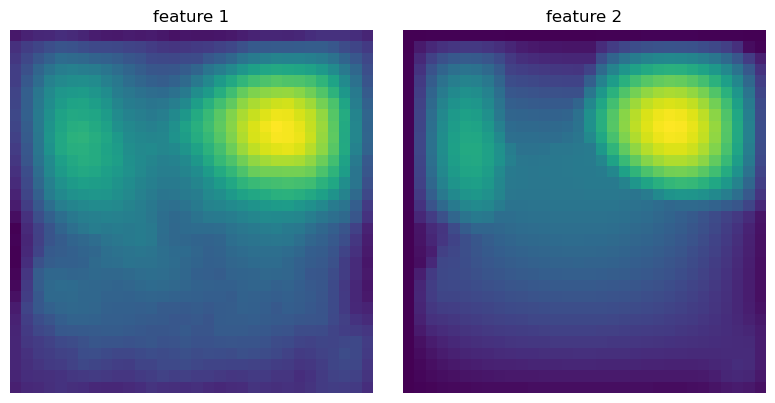

Epoch 83 Train: 100%|██████████| 140/140 [00:02<00:00, 52.96it/s]


Epoch 83: Train MSE=2.715213  Val MSE=7.549541


Epoch 84 Train:   0%|          | 0/140 [00:00<?, ?it/s]

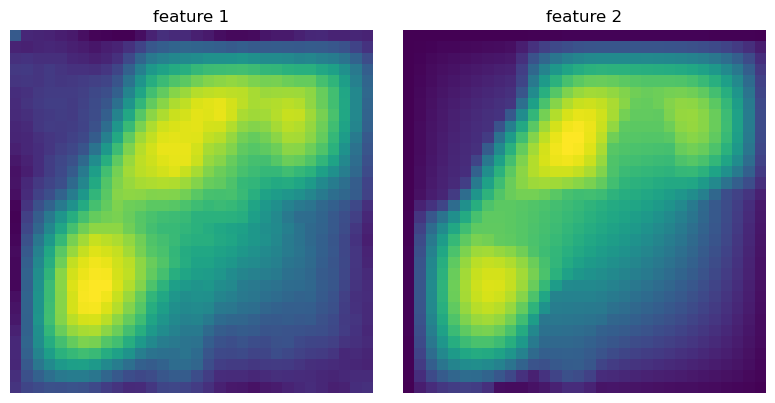

Epoch 84 Train: 100%|██████████| 140/140 [00:02<00:00, 53.31it/s]


Epoch 84: Train MSE=2.780863  Val MSE=7.503097


Epoch 85 Train:   0%|          | 0/140 [00:00<?, ?it/s]

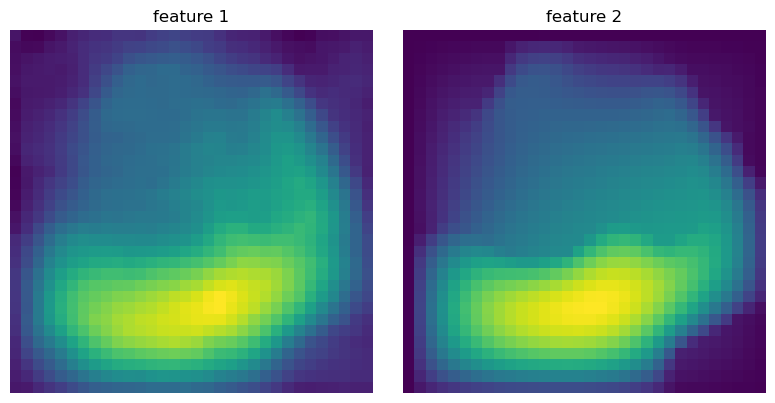

Epoch 85 Train: 100%|██████████| 140/140 [00:02<00:00, 48.21it/s]


Epoch 85: Train MSE=2.764164  Val MSE=6.842641


Epoch 86 Train:   0%|          | 0/140 [00:00<?, ?it/s]

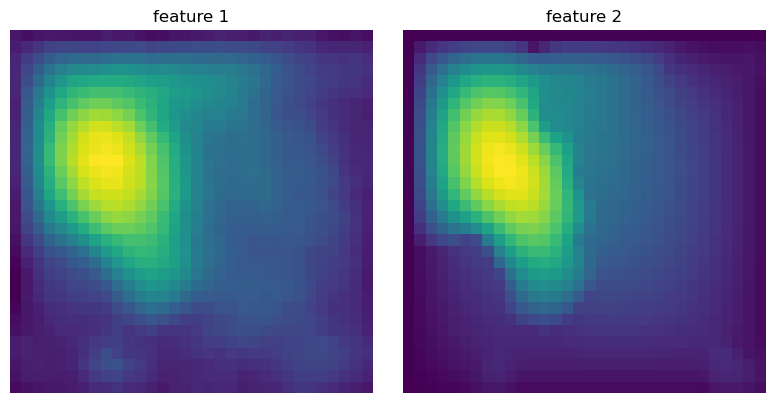

Epoch 86 Train: 100%|██████████| 140/140 [00:02<00:00, 53.13it/s]


Epoch 86: Train MSE=2.639324  Val MSE=6.916504


Epoch 87 Train:   0%|          | 0/140 [00:00<?, ?it/s]

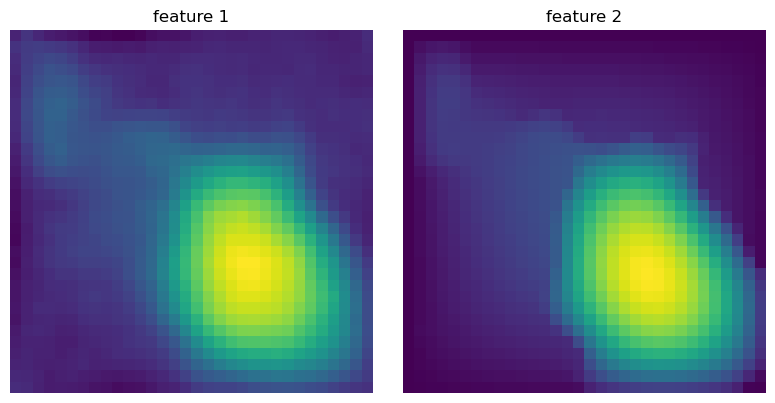

Epoch 87 Train: 100%|██████████| 140/140 [00:02<00:00, 53.34it/s]


Epoch 87: Train MSE=2.837446  Val MSE=7.216149


Epoch 88 Train:   0%|          | 0/140 [00:00<?, ?it/s]

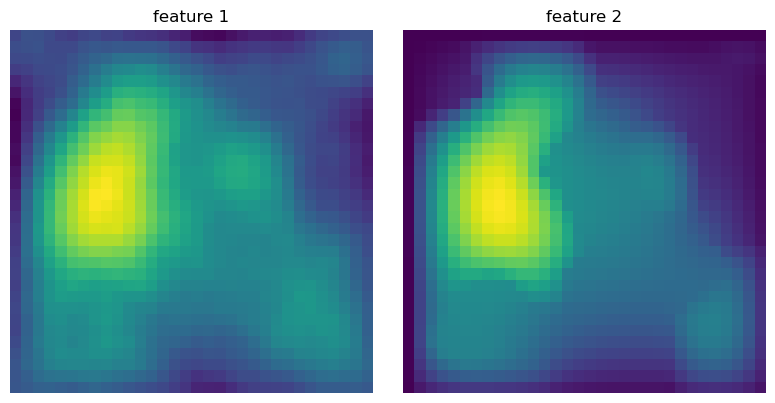

Epoch 88 Train: 100%|██████████| 140/140 [00:02<00:00, 53.09it/s]


Epoch 88: Train MSE=2.656108  Val MSE=6.918688


Epoch 89 Train:   0%|          | 0/140 [00:00<?, ?it/s]

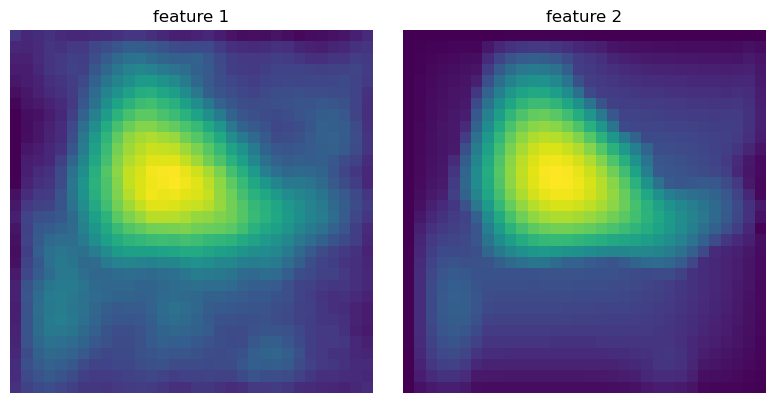

Epoch 89 Train: 100%|██████████| 140/140 [00:02<00:00, 53.28it/s]


Epoch 89: Train MSE=2.560021  Val MSE=7.685829


Epoch 90 Train:   0%|          | 0/140 [00:00<?, ?it/s]

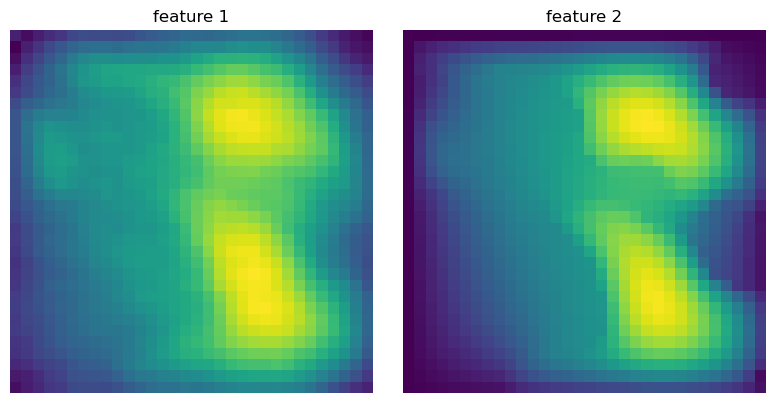

Epoch 90 Train: 100%|██████████| 140/140 [00:02<00:00, 53.34it/s]


Epoch 90: Train MSE=2.620382  Val MSE=7.484993


Epoch 91 Train:   0%|          | 0/140 [00:00<?, ?it/s]

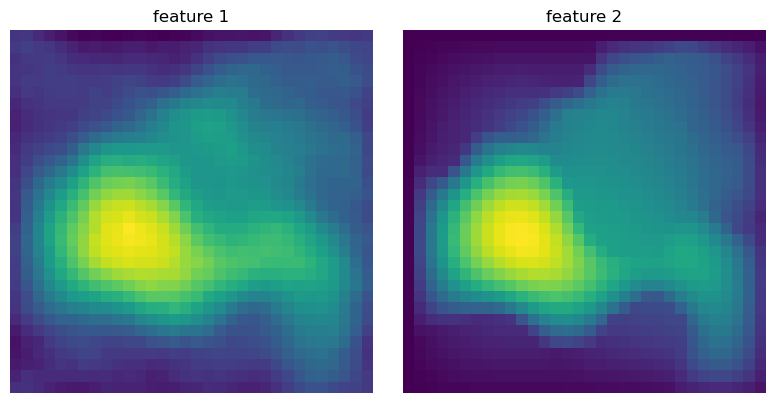

Epoch 91 Train: 100%|██████████| 140/140 [00:02<00:00, 53.25it/s]


Epoch 91: Train MSE=2.560823  Val MSE=6.931889


Epoch 92 Train:   0%|          | 0/140 [00:00<?, ?it/s]

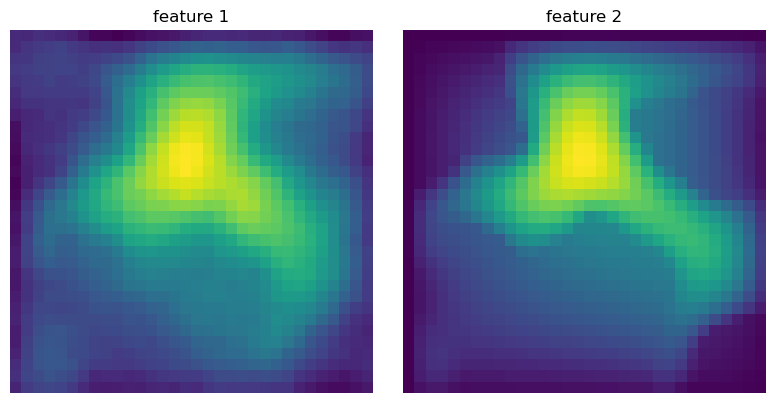

Epoch 92 Train: 100%|██████████| 140/140 [00:02<00:00, 53.20it/s]


Epoch 92: Train MSE=2.563724  Val MSE=8.078653


Epoch 93 Train:   0%|          | 0/140 [00:00<?, ?it/s]

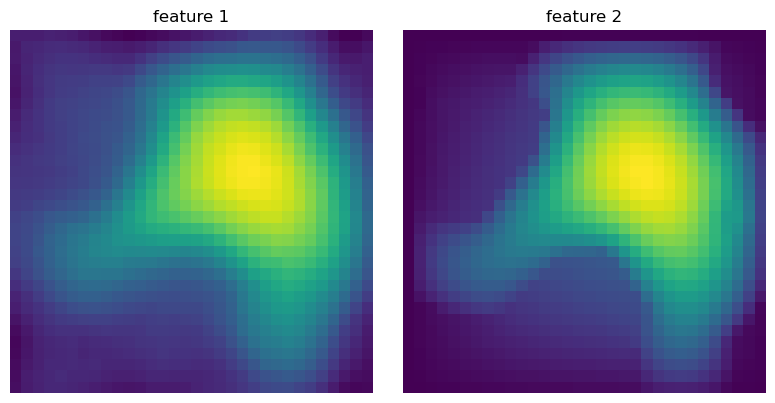

Epoch 93 Train: 100%|██████████| 140/140 [00:02<00:00, 52.98it/s]


Epoch 93: Train MSE=2.540504  Val MSE=7.802034


Epoch 94 Train:   0%|          | 0/140 [00:00<?, ?it/s]

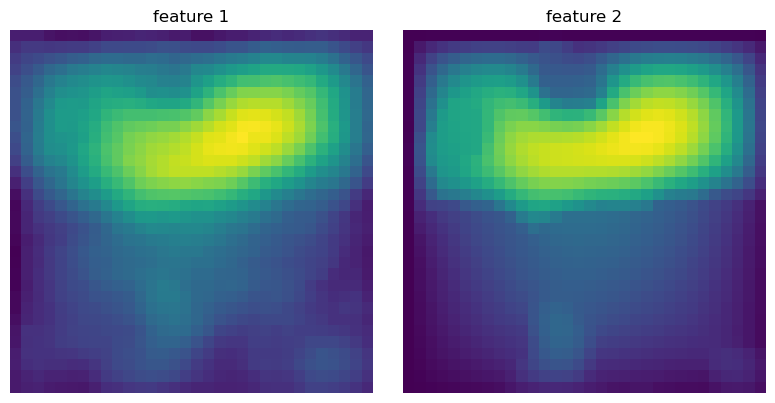

Epoch 94 Train: 100%|██████████| 140/140 [00:02<00:00, 53.05it/s]


Epoch 94: Train MSE=2.598734  Val MSE=7.158653


Epoch 95 Train:   0%|          | 0/140 [00:00<?, ?it/s]

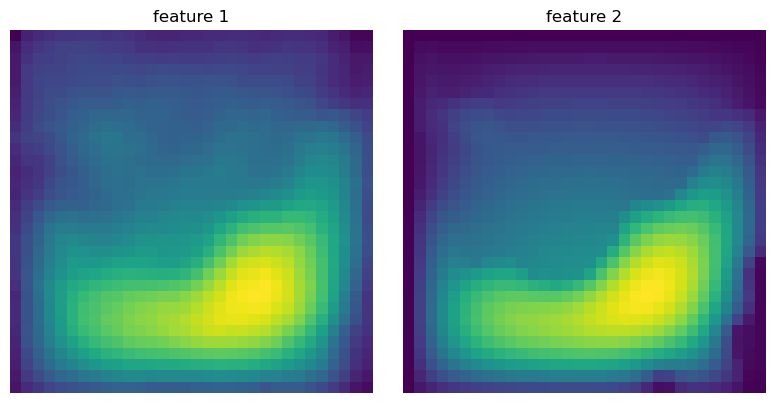

Epoch 95 Train: 100%|██████████| 140/140 [00:02<00:00, 53.05it/s]


Epoch 95: Train MSE=2.632982  Val MSE=6.869251


Epoch 96 Train:   0%|          | 0/140 [00:00<?, ?it/s]

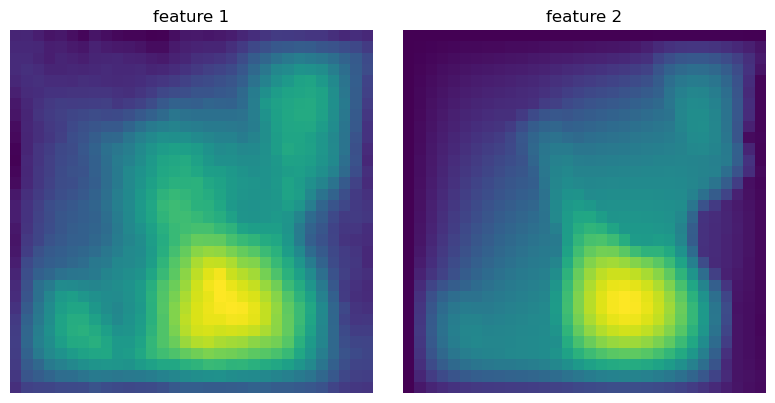

Epoch 96 Train: 100%|██████████| 140/140 [00:02<00:00, 53.29it/s]


Epoch 96: Train MSE=2.449548  Val MSE=7.042425


Epoch 97 Train:   0%|          | 0/140 [00:00<?, ?it/s]

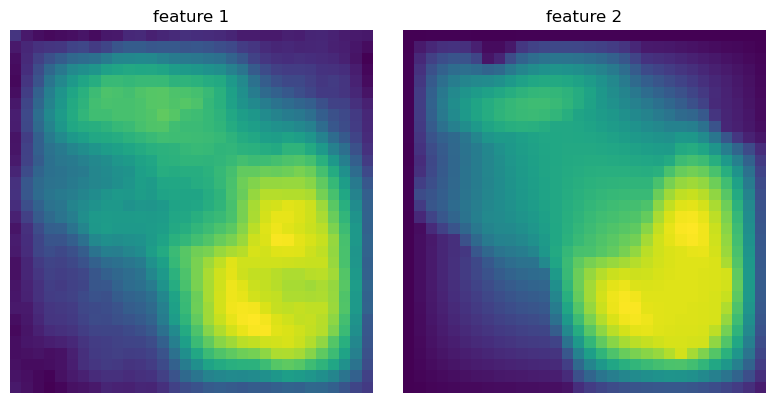

Epoch 97 Train: 100%|██████████| 140/140 [00:02<00:00, 53.07it/s]


Epoch 97: Train MSE=2.384377  Val MSE=8.150617


Epoch 98 Train:   0%|          | 0/140 [00:00<?, ?it/s]

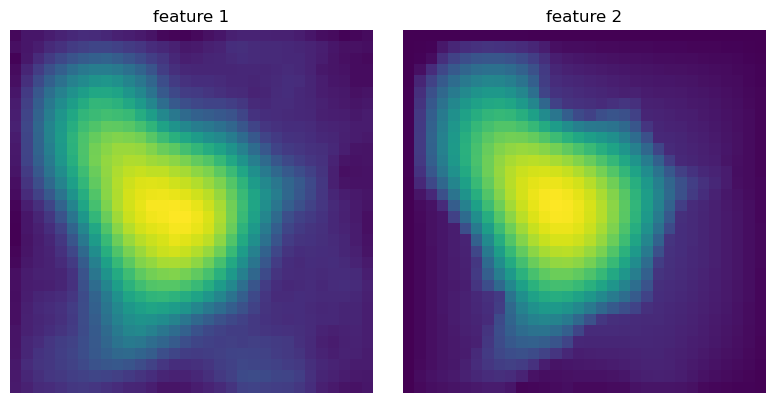

Epoch 98 Train: 100%|██████████| 140/140 [00:02<00:00, 53.28it/s]


Epoch 98: Train MSE=2.445168  Val MSE=7.220819


Epoch 99 Train:   0%|          | 0/140 [00:00<?, ?it/s]

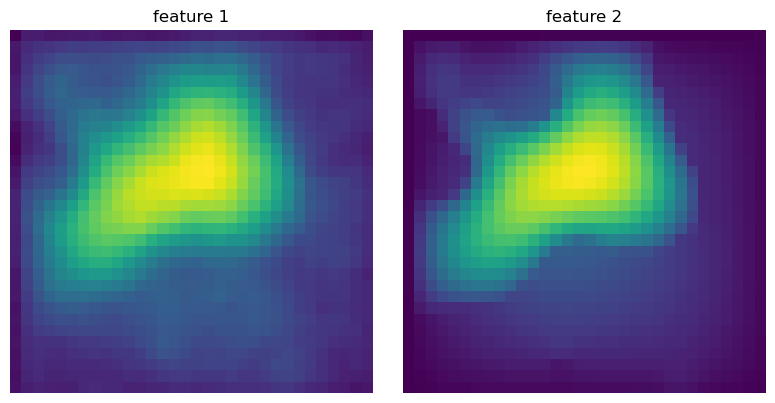

Epoch 99 Train: 100%|██████████| 140/140 [00:02<00:00, 53.15it/s]


Epoch 99: Train MSE=2.430427  Val MSE=6.882061


Epoch 100 Train:   0%|          | 0/140 [00:00<?, ?it/s]

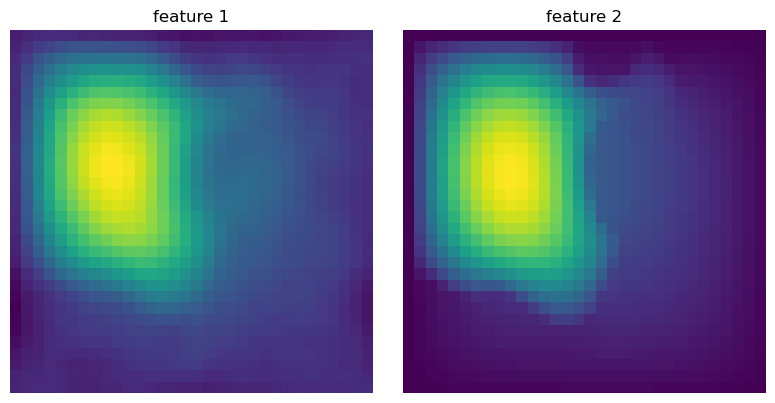

Epoch 100 Train: 100%|██████████| 140/140 [00:02<00:00, 53.19it/s]


Epoch 100: Train MSE=2.439539  Val MSE=8.113357


In [48]:
model   = FreqResnet(in_ch=2)

best_model_1 = train_fft_ri(
    model,
    dataset,
    num_epochs=100,
    batch_size=32,
    lr=1e-3,
    val_split=0.1
)

In [49]:
torch.save(best_model_1.state_dict(), "fft_cnn_1.pth")

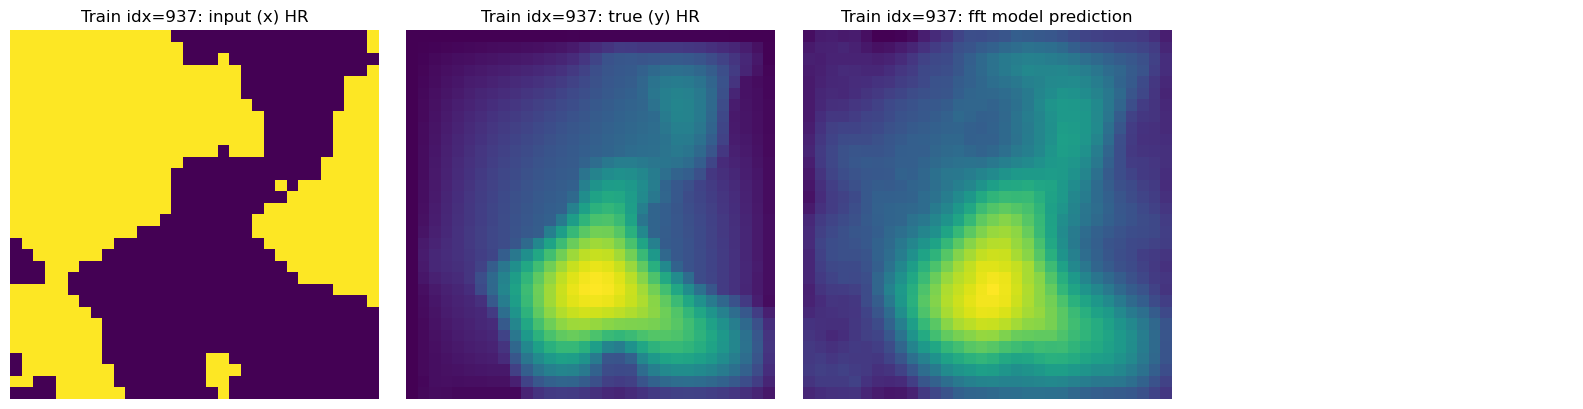

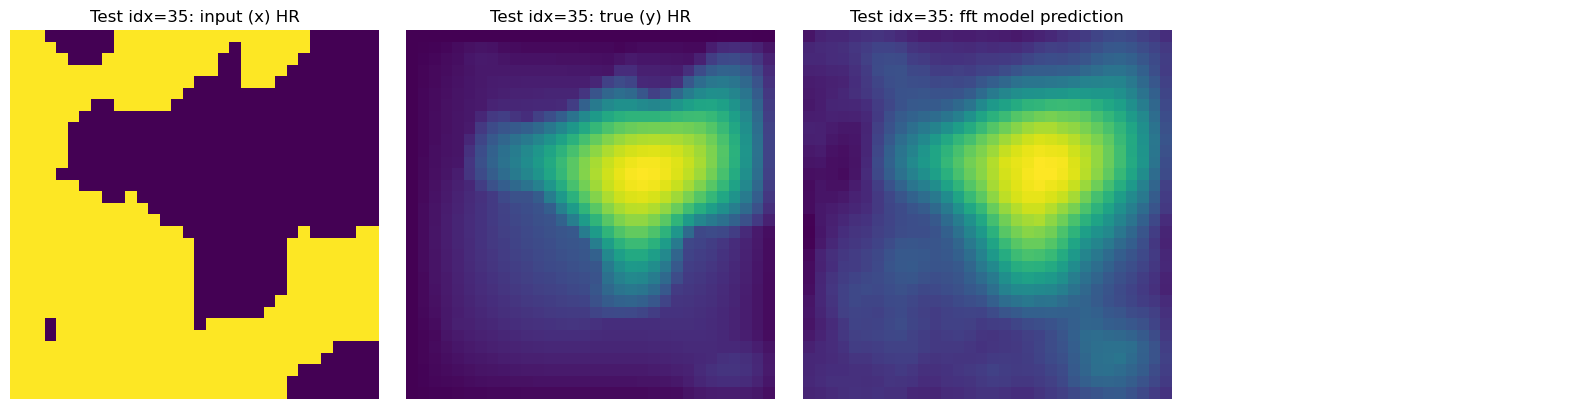

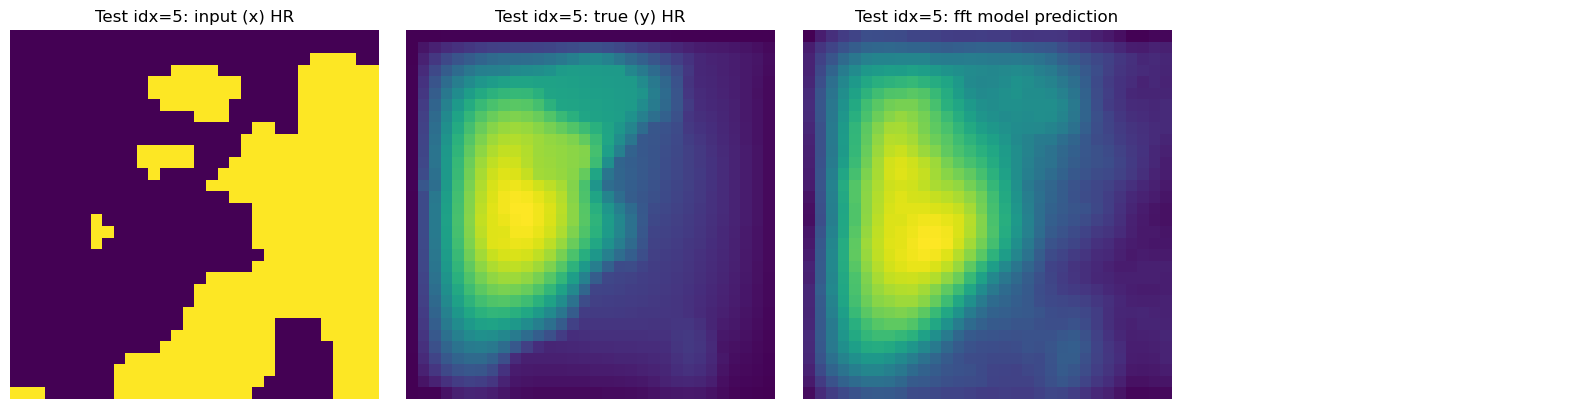

In [50]:
import random
L_min, L_max = compute_fft_stats(all_raw.to("cpu"))
idx_train = 937
run_and_plot_ri(x_hr[idx_train], y_hr[idx_train], best_model_1, f"Train idx={idx_train}")

idx_test = 35
run_and_plot_ri(x_hr_test[idx_test], y_hr_test[idx_test], best_model_1,  f"Test idx={idx_test}")

idx_test = 5
run_and_plot_ri(x_hr_test[idx_test], y_hr_test[idx_test], best_model_1, f"Test idx={idx_test}")

compute rmse of model predictions on test data in real space

In [55]:
def evaluate_fft_ri_model(model: nn.Module,
                          test_dataset: torch.utils.data.Dataset,
                          batch_size: int = 32,
                          device: str = "cuda" if torch.cuda.is_available() else "cpu"):
    loader    = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    mse_crit  = nn.MSELoss(reduction='sum')   # sum over all pixels
    model     = model.to(device).eval()

    total_mse    = 0.0
    total_pixels = 0

    with torch.no_grad():
        for data in loader:
            x_hr = data['x'].to(device)
            y_hr = data['y'].to(device)
            Xri = fft_ri(x_hr) 
            Yp  = model(Xri)
            y_pred = ifft_ri(Yp).to(device)
            batch_mse = mse_crit(y_pred, y_hr)
            total_mse += batch_mse.item()
            B, C, H, W = y_hr.shape
            total_pixels += B * C * H * W

    rmse = (total_mse / total_pixels) ** 0.5
    print(f"Test RMSE: {rmse:.6f}")
    return rmse

In [56]:
rmse = evaluate_fft_ri_model(best_model_1, test_hr, batch_size=32, device="cpu")

Test RMSE: 0.107668


# Low to high-res prediction task

In [35]:
# downsample input x to be 16 by 16

In [37]:
import torch.nn.functional as F

x_hr_ch = x_hr.unsqueeze(1)
x_lr_ch = F.interpolate(x_hr_ch,
                        size=(16,16),
                        mode='bilinear',
                        align_corners=False)

x_lr_train = x_lr_ch.squeeze(1)

In [1]:
import torch
import torch.nn as nn

class FreqSuperRes(nn.Module):
    """
    Spectral super‑resolution via residual‐in‐spectrum:
     - in_ch=2 real+imag spectrum at 32×32
     - out_ch=2 refined spectrum at 32×32
     - uses the same backbone as ParamFancyConvNet
    """
    def __init__(self,
                 mid_channels=(32, 64, 64, 32),
                 blocks=(1, 2, 2, 1),
                 bottleneck=False,
                 use_se=True,
                 drop_prob=0.1,
                 norm='batch',
                 num_groups=8):
        super().__init__()
        # reuse the ParamFancyConvNet body
        # note: last head conv will map back to 2 channels
        self.backbone = ParamFancyConvNet(
            in_ch=2,
            out_ch=2,
            channels=mid_channels,
            blocks=blocks,
            bottleneck=bottleneck,
            use_se=use_se,
            drop_prob=drop_prob,
            norm=norm,
            num_groups=num_groups
        )

    def forward(self, X32_init: torch.Tensor) -> torch.Tensor:
        """
        X32_init: [B,2,32,32] real+imag initial spectrum
        returns:  [B,2,32,32] refined spectrum = init + residual
        """
        residual = self.backbone(X32_init)
        return X32_init + residual


In [58]:
class SpectralSRDataset(Dataset):
    """Returns x_hr:[1,32,32], y_hr:[1,32,32]; model downsamples inside."""
    def __init__(self, x_hr: torch.Tensor, y_hr: torch.Tensor):
        assert x_hr.shape == y_hr.shape  # [N,32,32]
        self.x = x_hr.unsqueeze(1).float()  # [N,1,32,32]
        self.y = y_hr.unsqueeze(1).float()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

def fft_upsample2x(x16: torch.Tensor):
    """
    x16: [B,1,16,16] real → returns complex spectrum zero-padded [B,2,32,32]
    """
    B = x16.size(0)
    Xf16 = torch.fft.fft2(x16[:,0])                # [B,16,16]
    Xc16 = torch.fft.fftshift(Xf16, dim=(-2,-1))   # center
    # pad 8 on all sides → [B,32,32]
    Xc32 = F.pad(Xc16, (8,8,8,8))
    Xf32 = torch.fft.ifftshift(Xc32, dim=(-2,-1))
    # stack real and imag
    return torch.stack([Xf32.real, Xf32.imag], dim=1)

class FreqSuperRes(nn.Module):
    """Refine zero-padded spectrum."""
    def __init__(self, mid_ch=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(2, mid_ch, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, mid_ch, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, 2, 3, padding=1)
        )

    def forward(self, X32_init):
        return X32_init + self.net(X32_init)

def ifft_from_real_imag(Xri: torch.Tensor):
    """
    Xri: [B,2,32,32], real & imag channels → spatial [B,1,32,32]
    """
    Xf = torch.complex(Xri[:,0], Xri[:,1])
    x  = torch.fft.ifft2(Xf).real.unsqueeze(1)
    return x

def train_spectral_sr(model, dataset,
                      epochs=50, batch_size=16, lr=1e-3, val_split=0.1, device="cpu"):
    # split
    N = len(dataset)
    n_val = int(N*val_split)
    n_train = N - n_val
    tr, va = random_split(dataset, [n_train, n_val])
    tr_ld = DataLoader(tr, batch_size=batch_size, shuffle=True, drop_last=True)
    va_ld = DataLoader(va, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    opt   = optim.Adam(model.parameters(), lr=lr)
    mse   = nn.MSELoss()

    best_val = float('inf')
    best_st  = None

    for ep in range(1, epochs+1):
        # train
        model.train()
        t_loss = 0.0
        count = 0
        for x_hr, y_hr in tqdm(tr_ld, desc=f"Ep{ep}"):
            x_hr, y_hr = x_hr.to(device), y_hr.to(device)
            # downsample
            x_lr = F.interpolate(x_hr, size=(16,16), mode='bilinear', align_corners=False)
            X32i = fft_upsample2x(x_lr)
            X32r = model(X32i)
            y_pred = ifft_from_real_imag(X32r)
            if count==0:
                visualize_pair_1(y_pred[0,0], y_hr[0,0])
            count +=1
            loss = mse(y_pred, y_hr)
            opt.zero_grad(); loss.backward(); opt.step()
            t_loss += loss.item()

        # validate
        model.eval()
        v_loss = 0.0
        count = 0
        with torch.no_grad():
            for x_hr, y_hr in va_ld:
                x_hr, y_hr = x_hr.to(device), y_hr.to(device)
                x_lr = F.interpolate(x_hr, size=(16,16), mode='bilinear', align_corners=False)
                X32i = fft_upsample2x(x_lr)
                X32r = model(X32i)
                y_pred = ifft_from_real_imag(X32r)
                
                if count==0:
                    visualize_pair_1(y_pred[0,0], y_hr[0,0])
                count +=1
                v_loss += mse(y_pred, y_hr).item()

        t_avg = t_loss/len(tr_ld)
        v_avg = v_loss/len(va_ld)
        print(f"Epoch {ep}: Train={t_avg:.6f}  Val={v_avg:.6f}")
        if v_avg < best_val:
            best_val = v_avg
            best_st  = model.state_dict()

    if best_st:
        model.load_state_dict(best_st)
    return model.cpu()


In [59]:
dataset = SpectralSRDataset(x_hr, y_hr)
model_new   = FreqSuperRes(mid_ch=64)

Ep1:   0%|          | 0/140 [00:00<?, ?it/s]

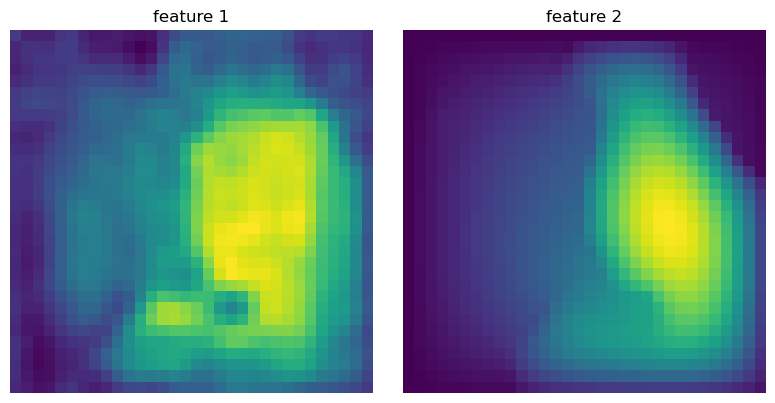

Ep1: 100%|██████████| 140/140 [00:29<00:00,  4.69it/s]


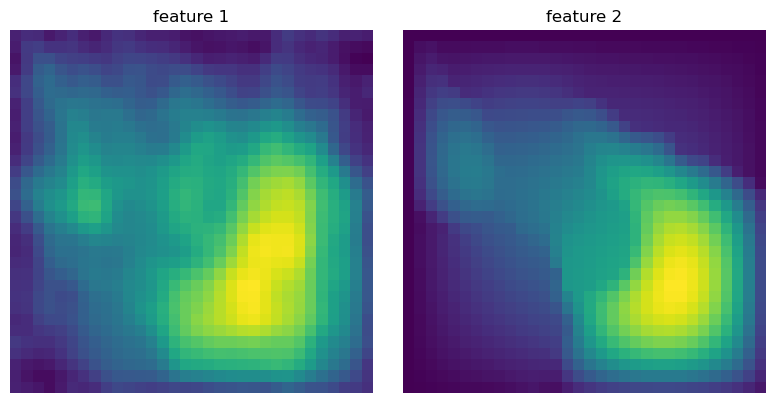

Epoch 1: Train=0.032726  Val=0.027635


Ep2:   0%|          | 0/140 [00:00<?, ?it/s]

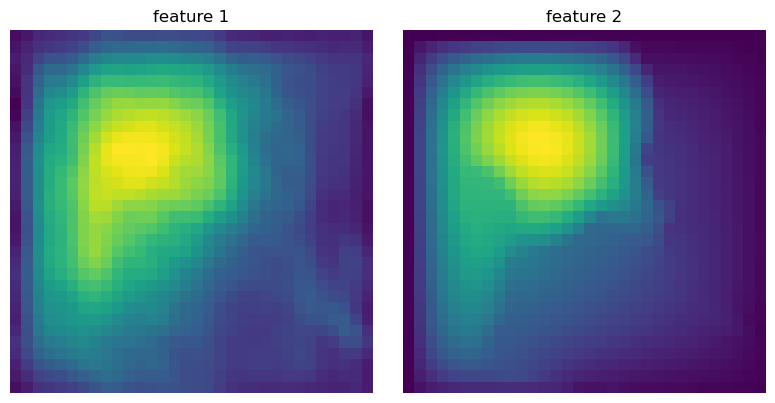

Ep2: 100%|██████████| 140/140 [00:29<00:00,  4.73it/s]


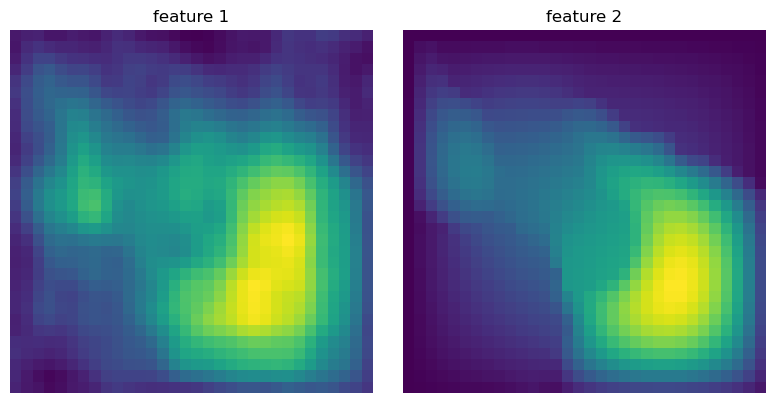

Epoch 2: Train=0.025408  Val=0.024192


Ep3:   0%|          | 0/140 [00:00<?, ?it/s]

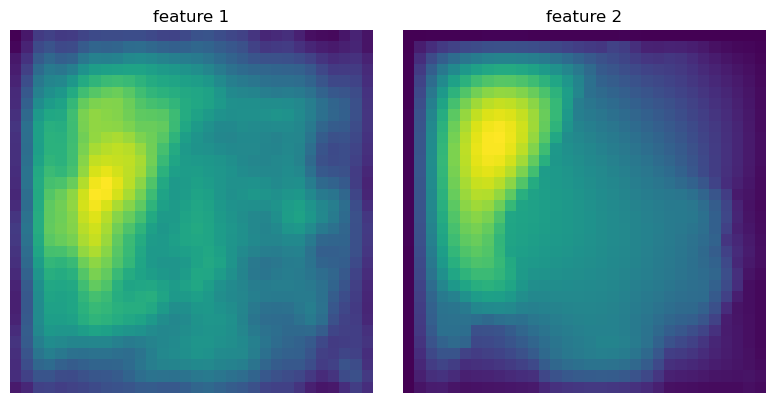

Ep3: 100%|██████████| 140/140 [00:29<00:00,  4.79it/s]


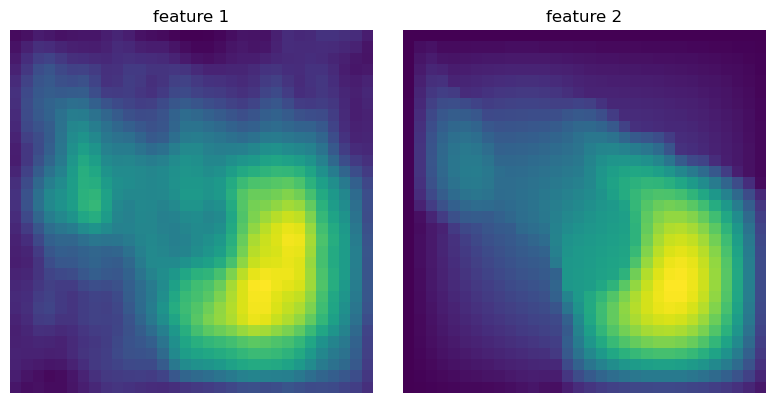

Epoch 3: Train=0.022688  Val=0.022170


Ep4:   0%|          | 0/140 [00:00<?, ?it/s]

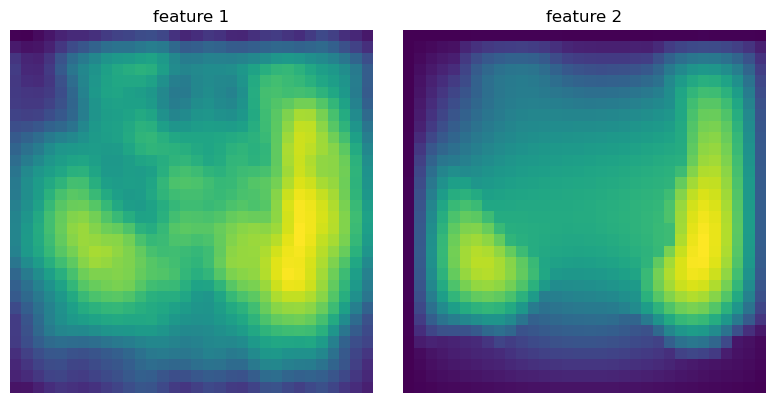

Ep4: 100%|██████████| 140/140 [00:29<00:00,  4.73it/s]


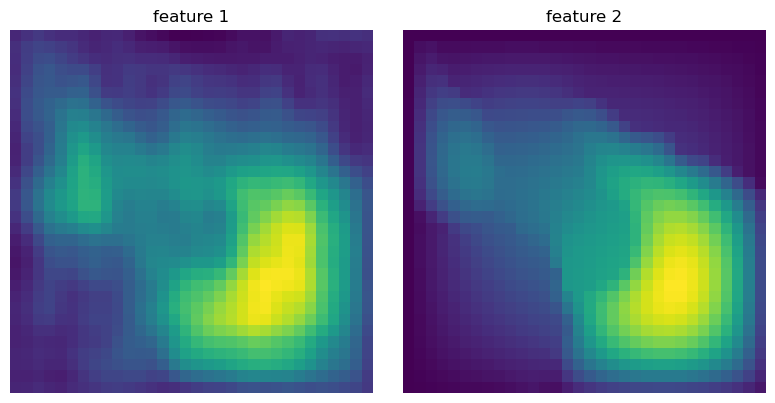

Epoch 4: Train=0.020993  Val=0.020821


Ep5:   0%|          | 0/140 [00:00<?, ?it/s]

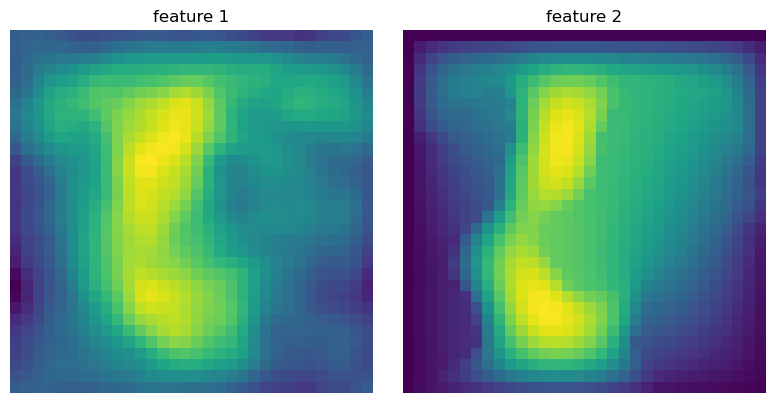

Ep5: 100%|██████████| 140/140 [00:29<00:00,  4.69it/s]


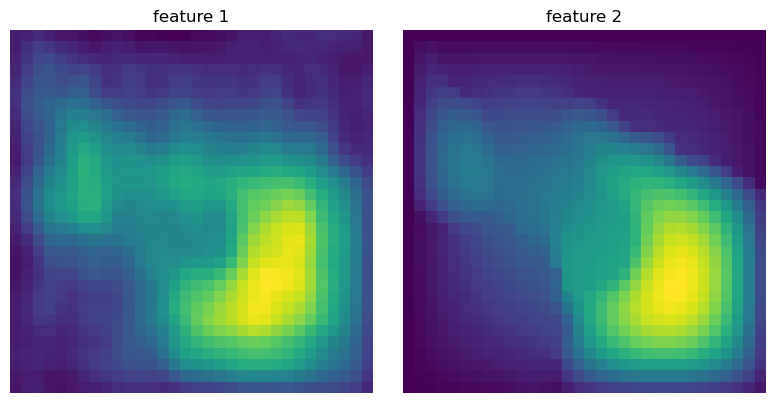

Epoch 5: Train=0.019651  Val=0.019545


Ep6:   0%|          | 0/140 [00:00<?, ?it/s]

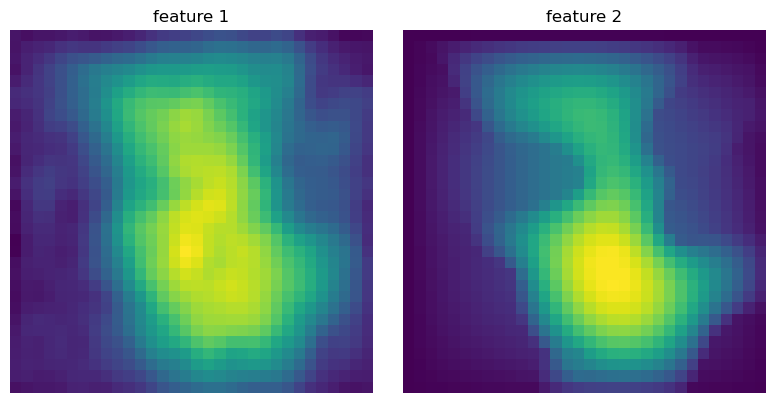

Ep6: 100%|██████████| 140/140 [00:29<00:00,  4.73it/s]


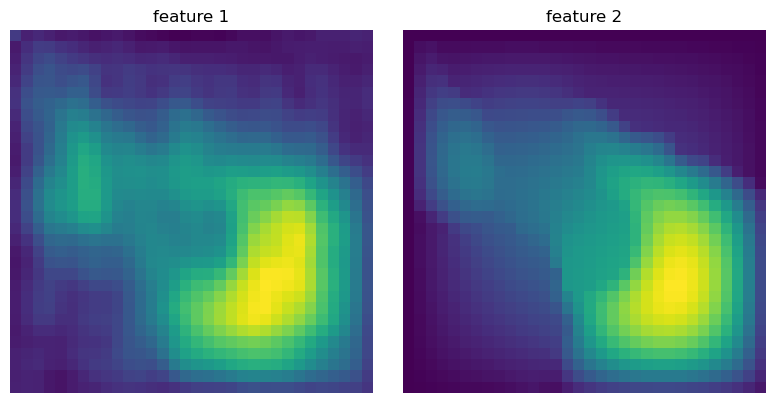

Epoch 6: Train=0.018535  Val=0.018899


Ep7:   0%|          | 0/140 [00:00<?, ?it/s]

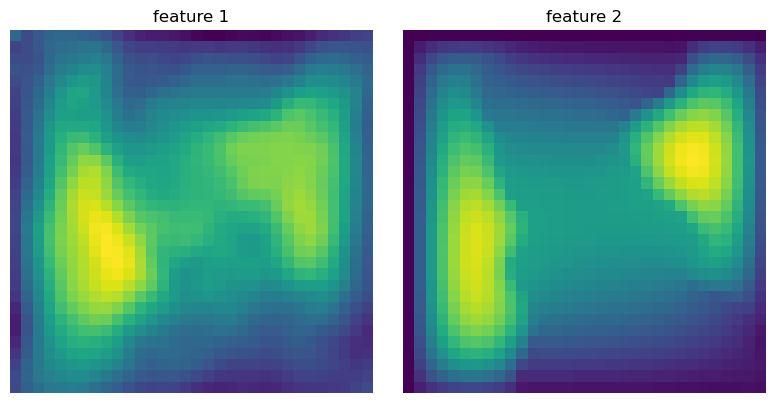

Ep7: 100%|██████████| 140/140 [00:28<00:00,  4.83it/s]


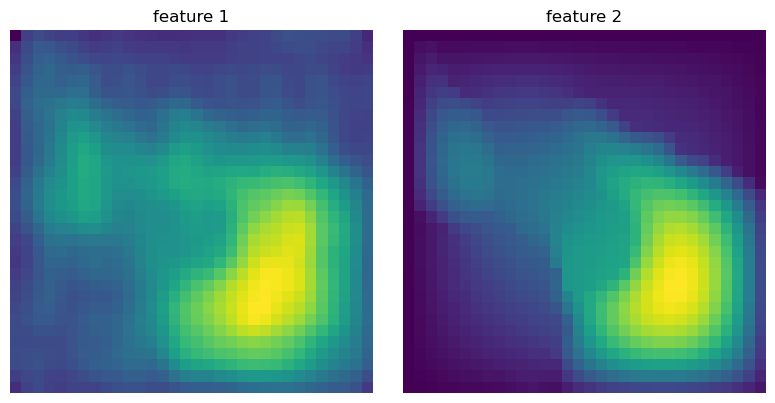

Epoch 7: Train=0.017871  Val=0.018391


Ep8:   0%|          | 0/140 [00:00<?, ?it/s]

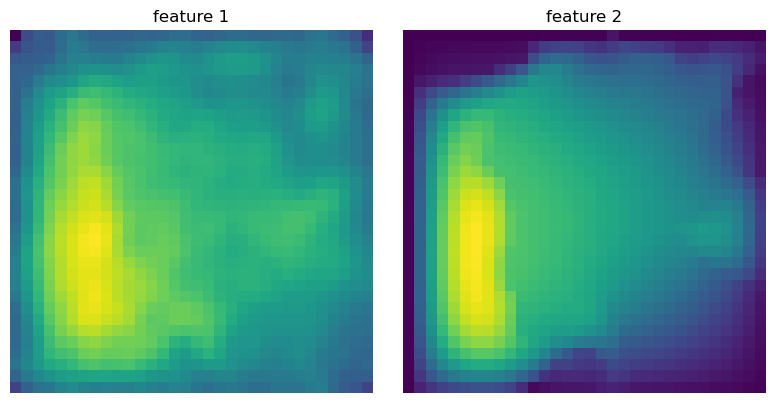

Ep8: 100%|██████████| 140/140 [00:29<00:00,  4.81it/s]


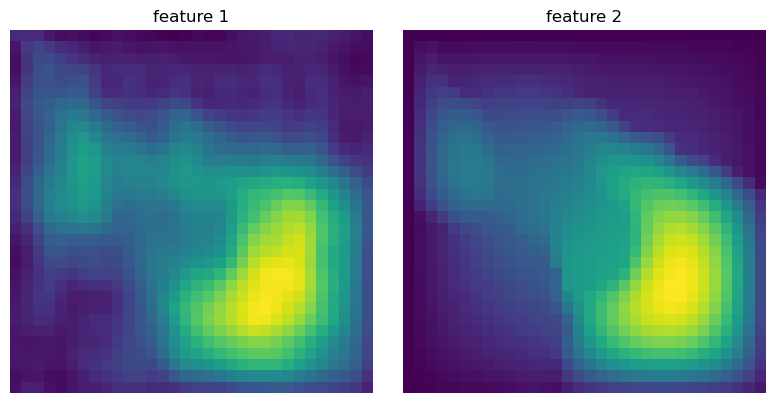

Epoch 8: Train=0.017135  Val=0.018679


Ep9:   0%|          | 0/140 [00:00<?, ?it/s]

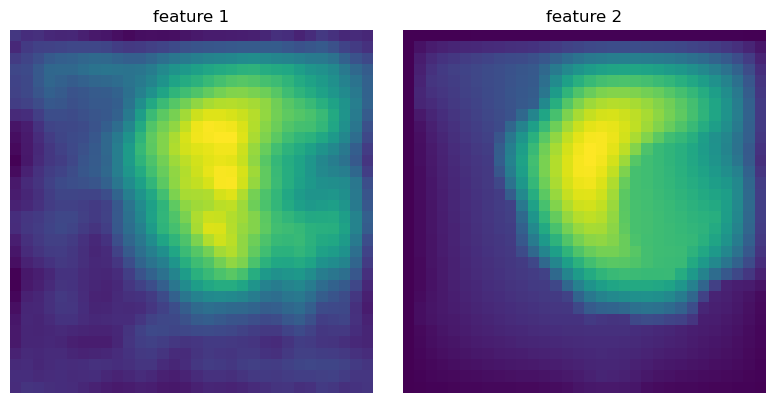

Ep9: 100%|██████████| 140/140 [00:29<00:00,  4.79it/s]


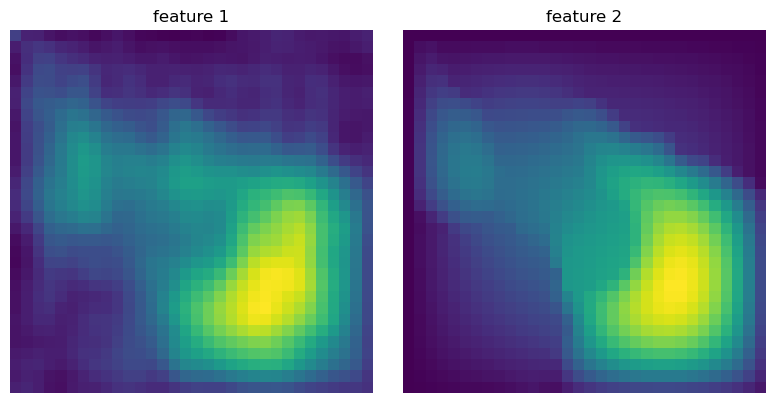

Epoch 9: Train=0.016741  Val=0.017290


Ep10:   0%|          | 0/140 [00:00<?, ?it/s]

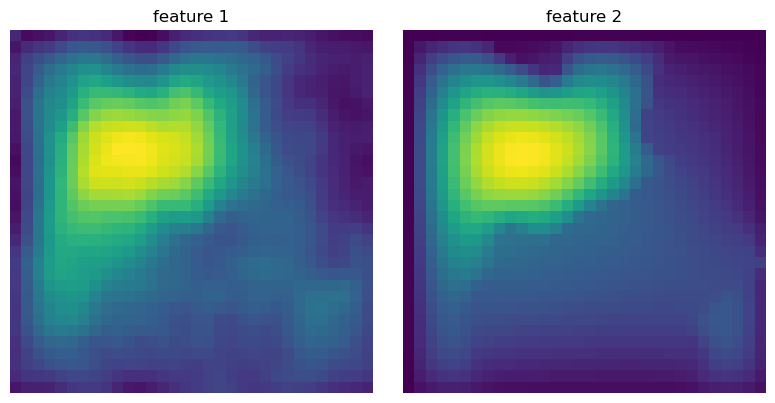

Ep10: 100%|██████████| 140/140 [00:29<00:00,  4.76it/s]


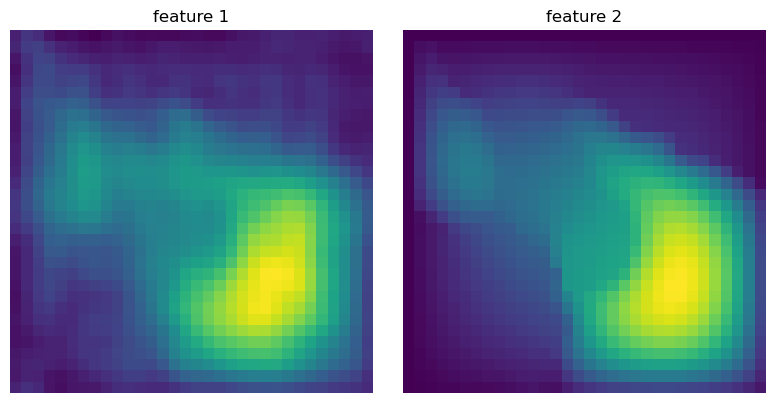

Epoch 10: Train=0.016350  Val=0.016918


Ep11:   0%|          | 0/140 [00:00<?, ?it/s]

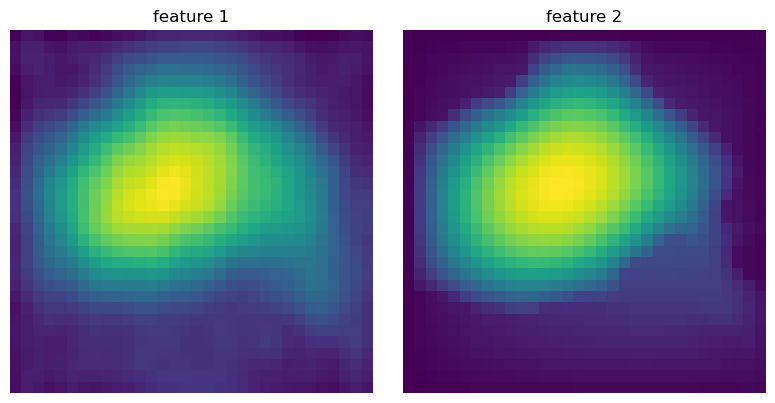

Ep11: 100%|██████████| 140/140 [00:29<00:00,  4.81it/s]


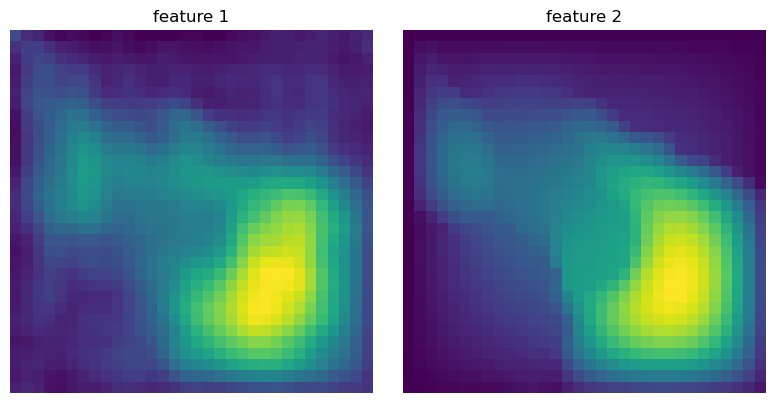

Epoch 11: Train=0.015915  Val=0.017219


Ep12:   0%|          | 0/140 [00:00<?, ?it/s]

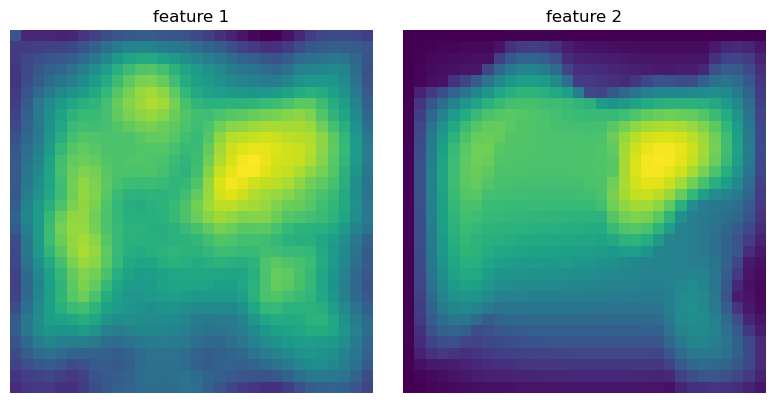

Ep12: 100%|██████████| 140/140 [00:29<00:00,  4.78it/s]


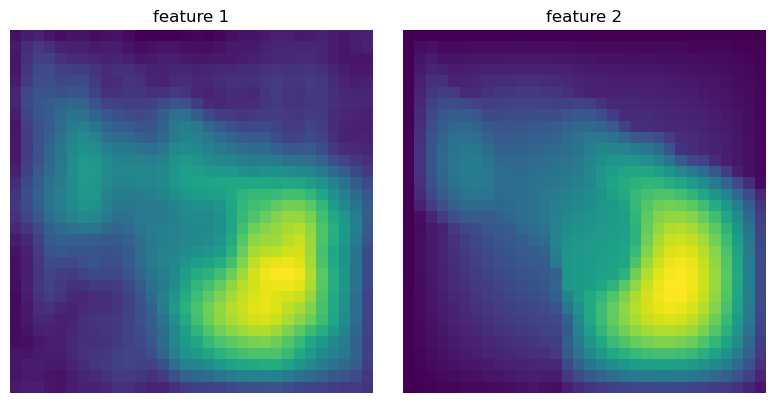

Epoch 12: Train=0.015668  Val=0.016380


Ep13:   0%|          | 0/140 [00:00<?, ?it/s]

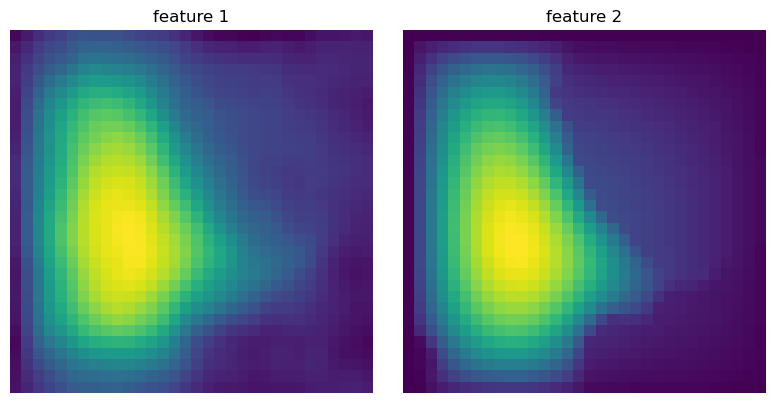

Ep13: 100%|██████████| 140/140 [00:29<00:00,  4.79it/s]


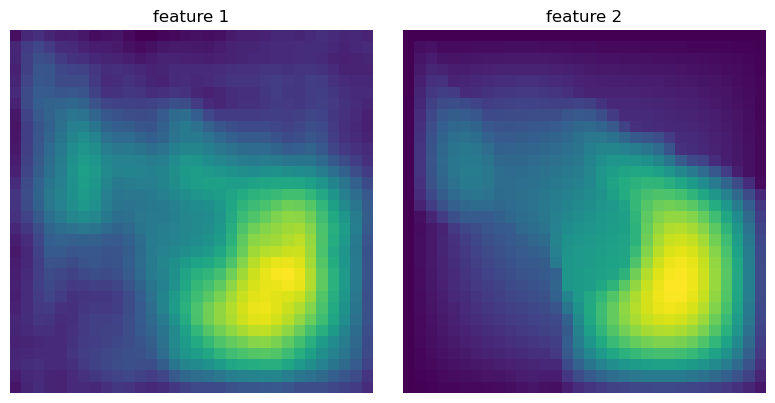

Epoch 13: Train=0.015286  Val=0.016126


Ep14:   0%|          | 0/140 [00:00<?, ?it/s]

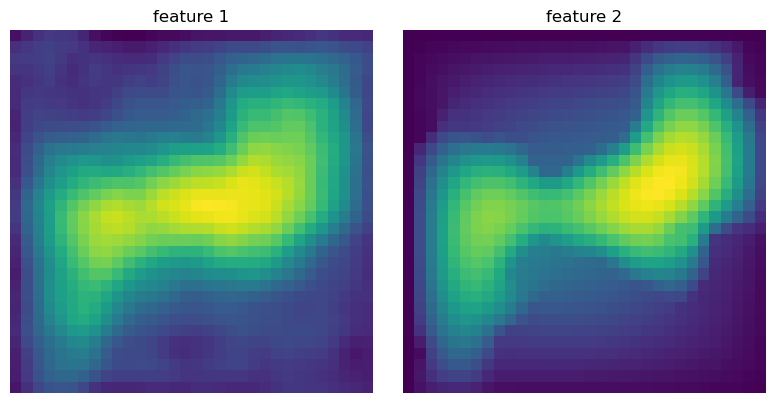

Ep14: 100%|██████████| 140/140 [00:29<00:00,  4.79it/s]


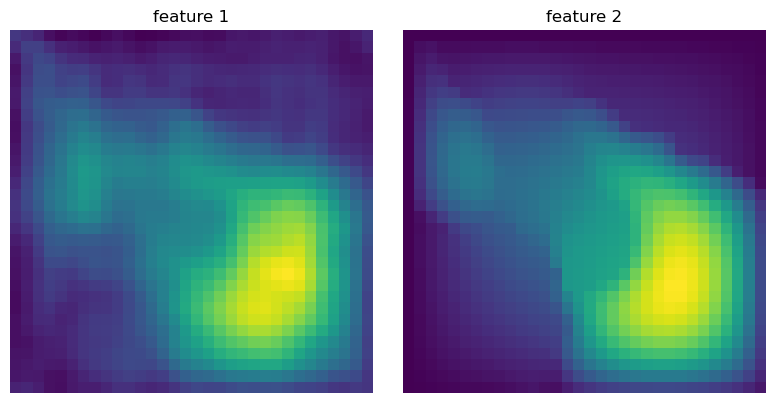

Epoch 14: Train=0.014959  Val=0.016017


Ep15:   0%|          | 0/140 [00:00<?, ?it/s]

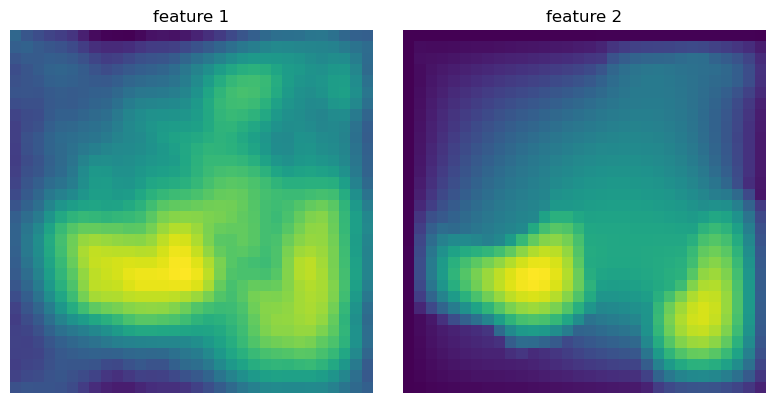

Ep15: 100%|██████████| 140/140 [00:29<00:00,  4.77it/s]


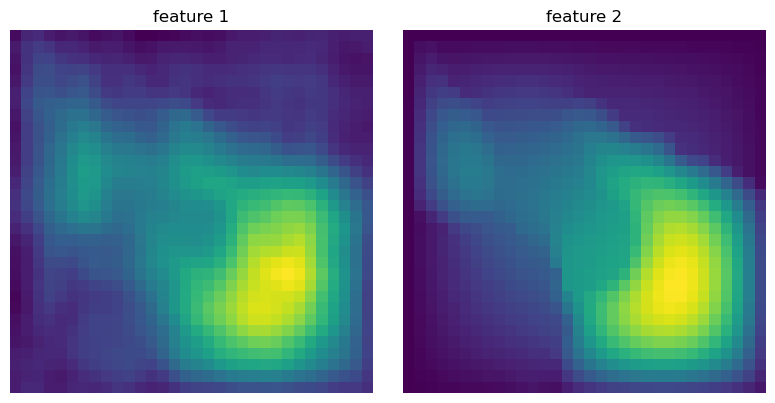

Epoch 15: Train=0.014718  Val=0.015688


Ep16:   0%|          | 0/140 [00:00<?, ?it/s]

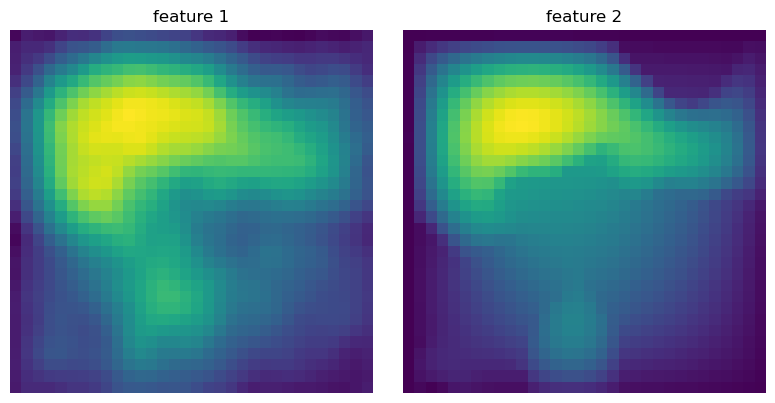

Ep16: 100%|██████████| 140/140 [00:29<00:00,  4.80it/s]


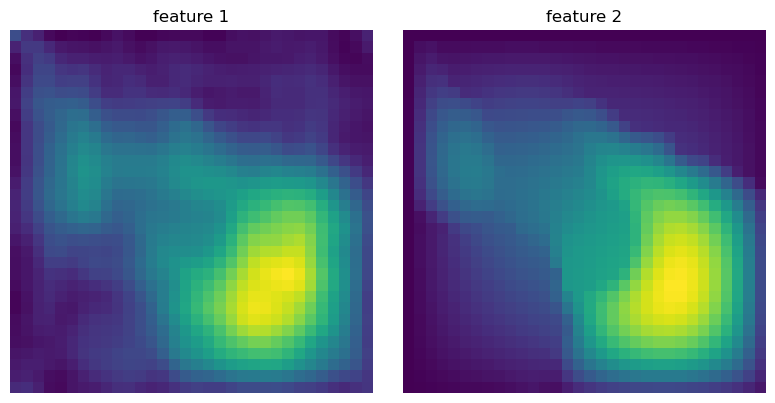

Epoch 16: Train=0.014748  Val=0.015661


Ep17:   0%|          | 0/140 [00:00<?, ?it/s]

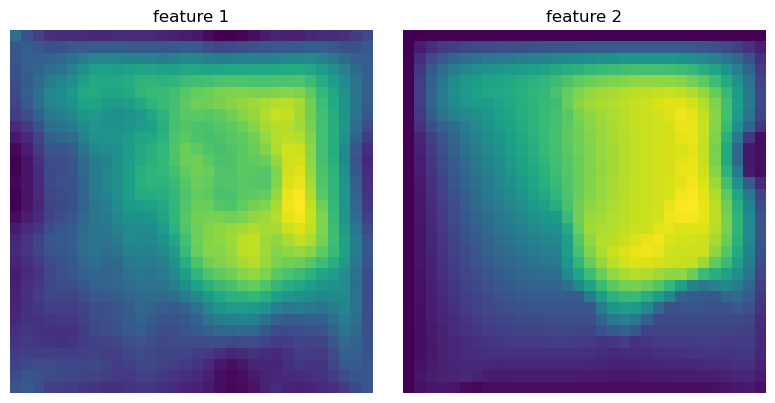

Ep17: 100%|██████████| 140/140 [00:29<00:00,  4.78it/s]


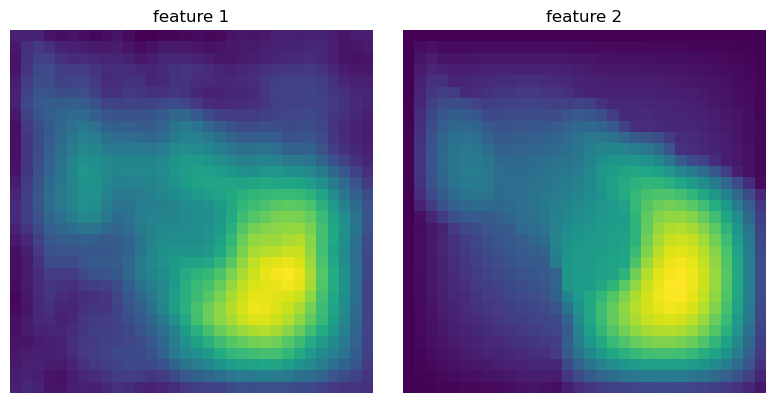

Epoch 17: Train=0.014194  Val=0.016077


Ep18:   0%|          | 0/140 [00:00<?, ?it/s]

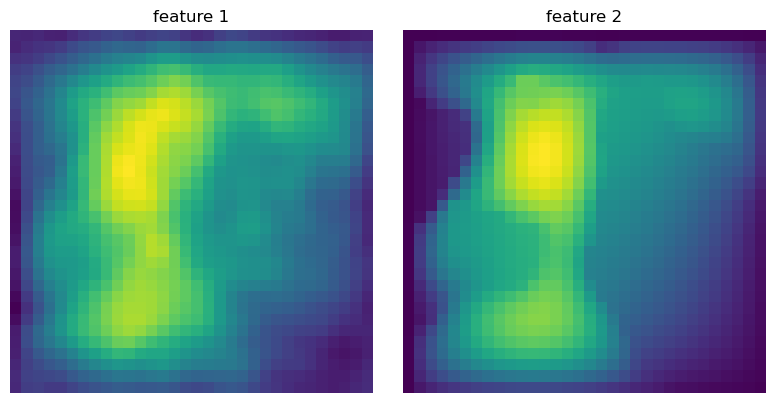

Ep18: 100%|██████████| 140/140 [00:29<00:00,  4.79it/s]


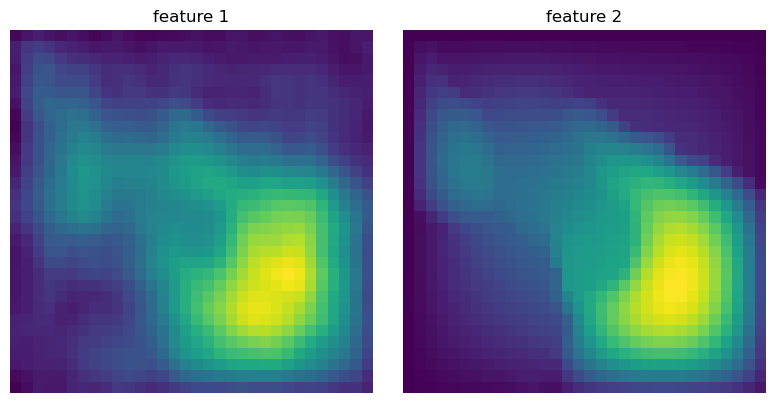

Epoch 18: Train=0.014067  Val=0.015490


Ep19:   0%|          | 0/140 [00:00<?, ?it/s]

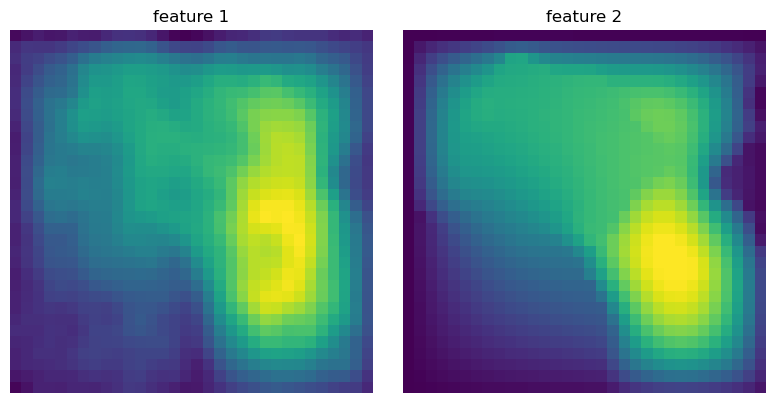

Ep19: 100%|██████████| 140/140 [00:29<00:00,  4.77it/s]


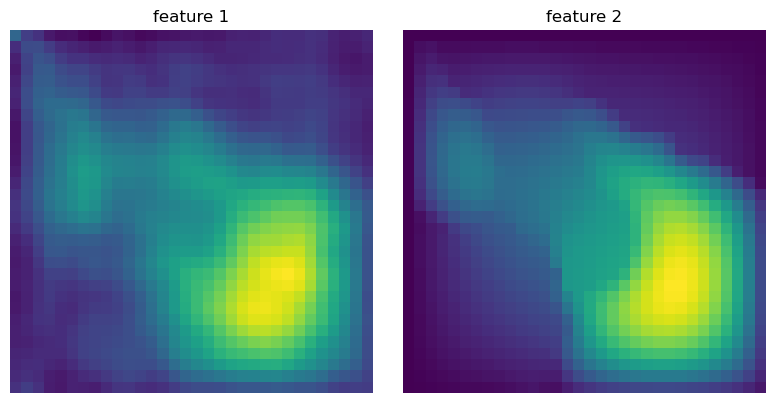

Epoch 19: Train=0.013889  Val=0.015200


Ep20:   0%|          | 0/140 [00:00<?, ?it/s]

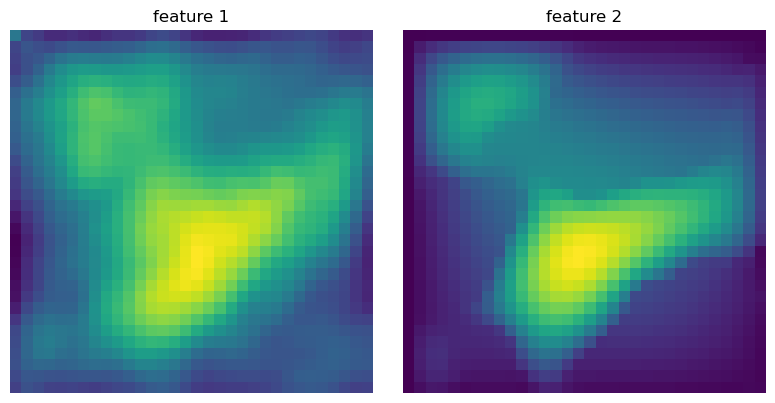

Ep20: 100%|██████████| 140/140 [00:29<00:00,  4.78it/s]


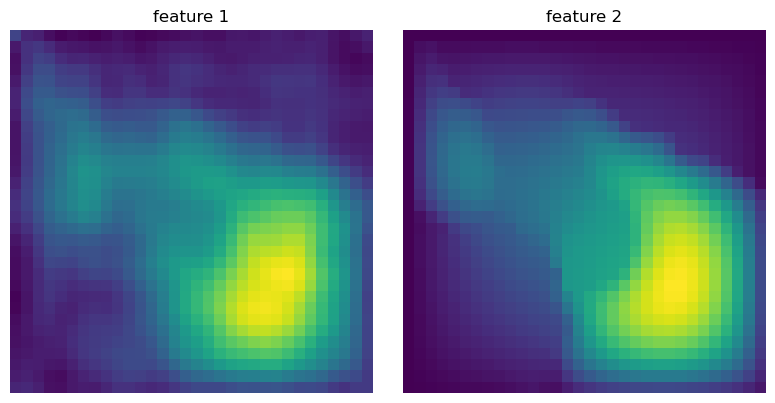

Epoch 20: Train=0.013733  Val=0.015111


Ep21:   0%|          | 0/140 [00:00<?, ?it/s]

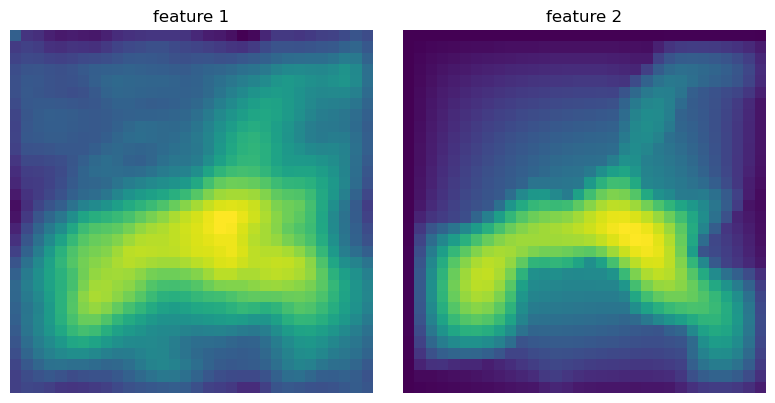

Ep21: 100%|██████████| 140/140 [00:29<00:00,  4.76it/s]


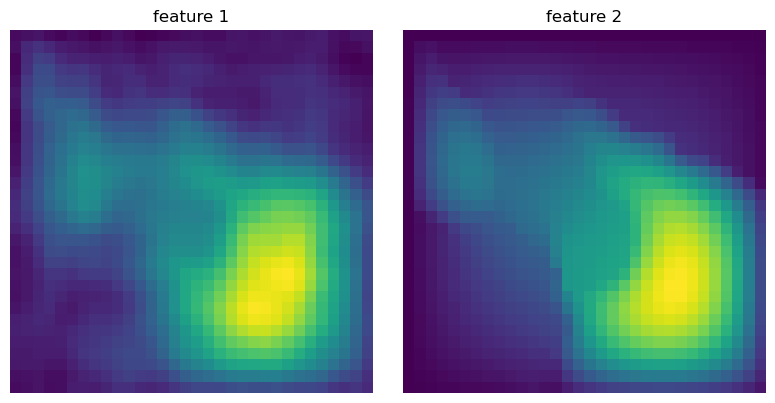

Epoch 21: Train=0.013635  Val=0.014935


Ep22:   0%|          | 0/140 [00:00<?, ?it/s]

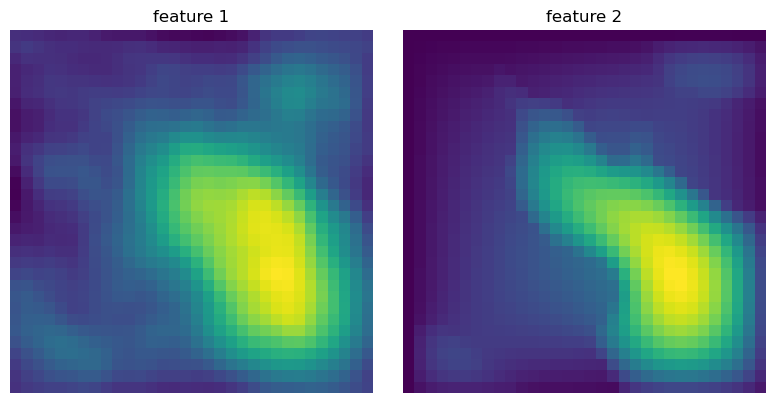

Ep22: 100%|██████████| 140/140 [00:29<00:00,  4.76it/s]


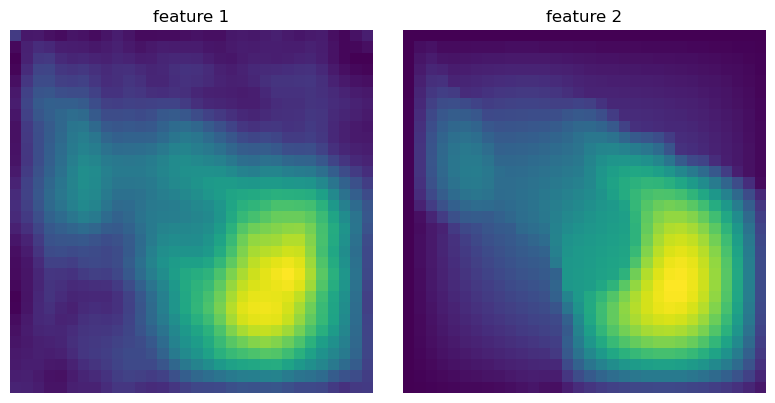

Epoch 22: Train=0.013391  Val=0.014940


Ep23:   0%|          | 0/140 [00:00<?, ?it/s]

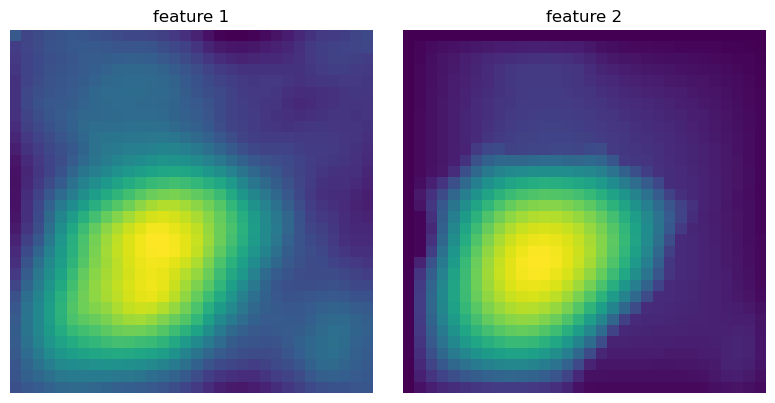

Ep23: 100%|██████████| 140/140 [00:29<00:00,  4.80it/s]


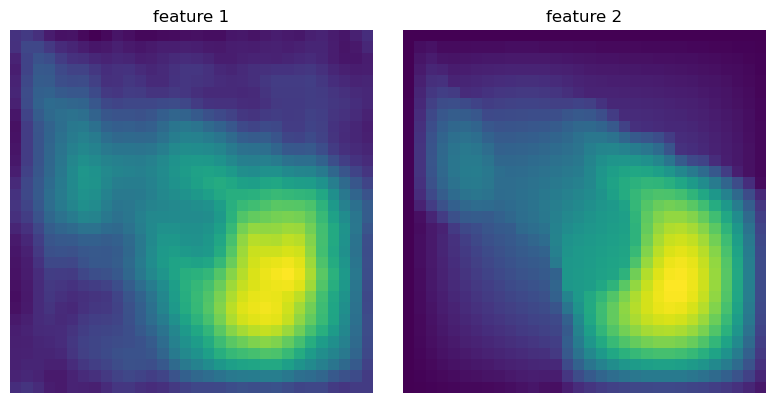

Epoch 23: Train=0.013228  Val=0.014559


Ep24:   0%|          | 0/140 [00:00<?, ?it/s]

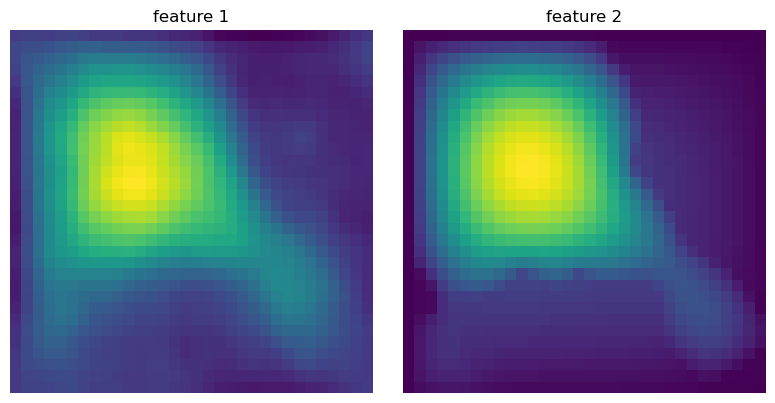

Ep24: 100%|██████████| 140/140 [00:29<00:00,  4.82it/s]


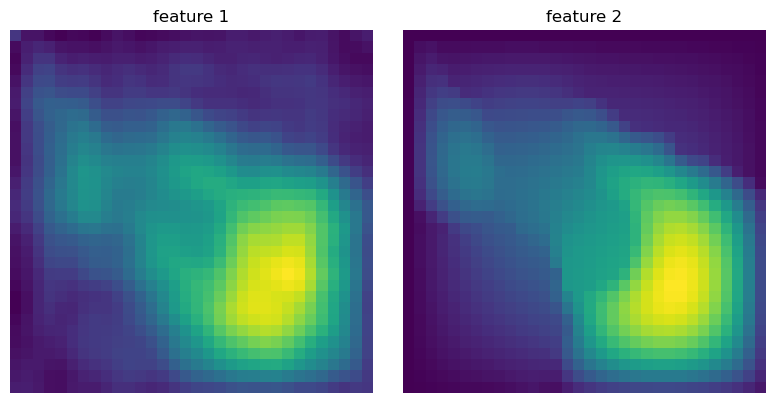

Epoch 24: Train=0.013077  Val=0.014832


Ep25:   0%|          | 0/140 [00:00<?, ?it/s]

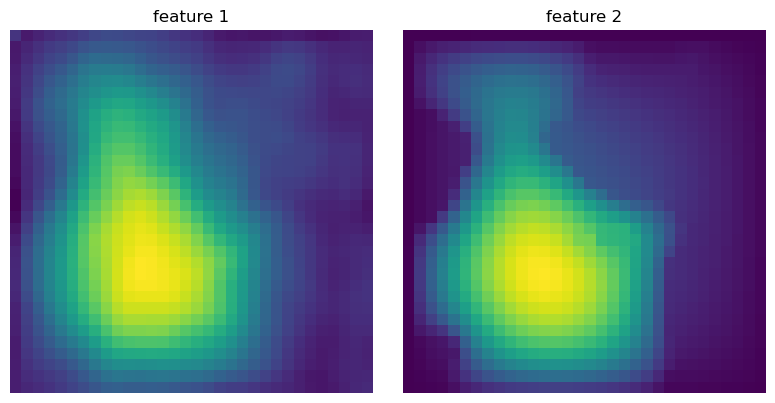

Ep25: 100%|██████████| 140/140 [00:29<00:00,  4.80it/s]


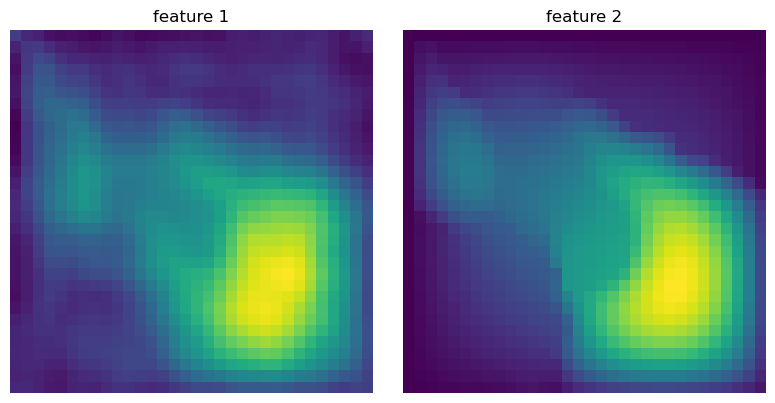

Epoch 25: Train=0.013079  Val=0.015349


Ep26:   0%|          | 0/140 [00:00<?, ?it/s]

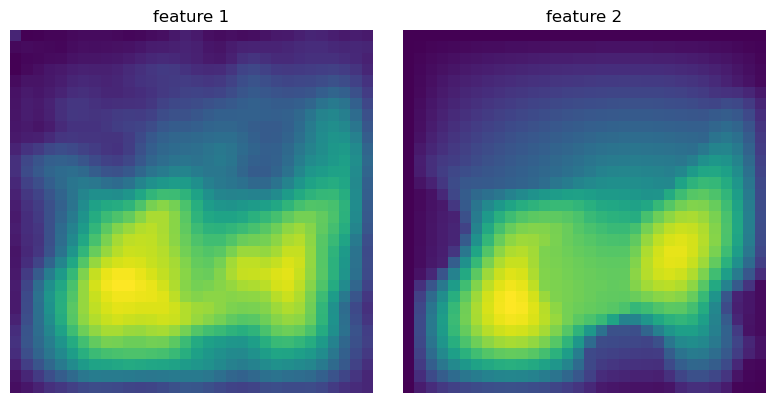

Ep26: 100%|██████████| 140/140 [00:29<00:00,  4.76it/s]


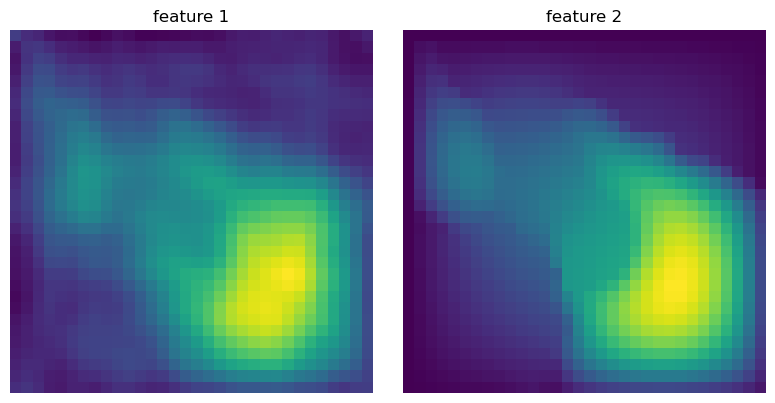

Epoch 26: Train=0.012890  Val=0.014377


Ep27:   0%|          | 0/140 [00:00<?, ?it/s]

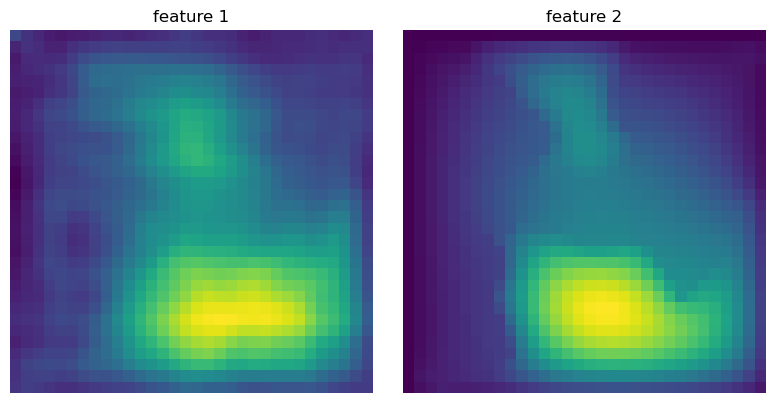

Ep27: 100%|██████████| 140/140 [00:29<00:00,  4.82it/s]


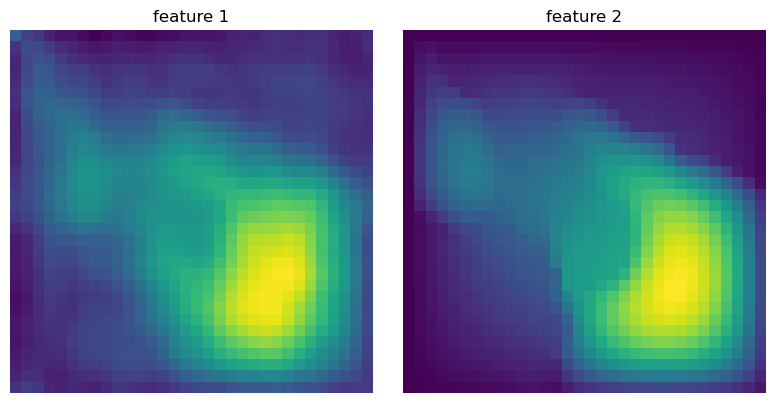

Epoch 27: Train=0.012717  Val=0.014626


Ep28:   0%|          | 0/140 [00:00<?, ?it/s]

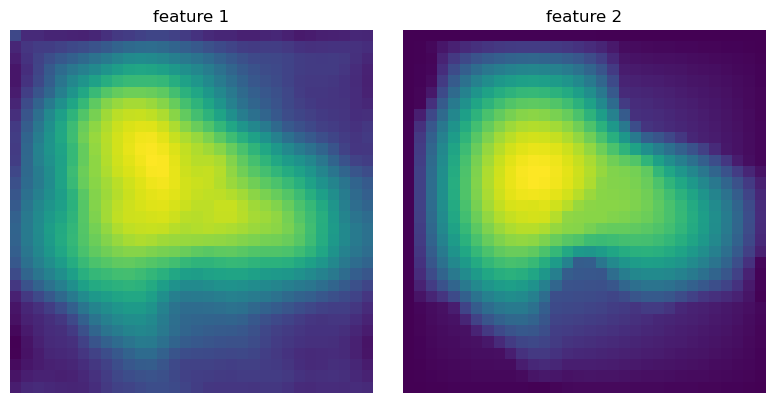

Ep28: 100%|██████████| 140/140 [00:29<00:00,  4.73it/s]


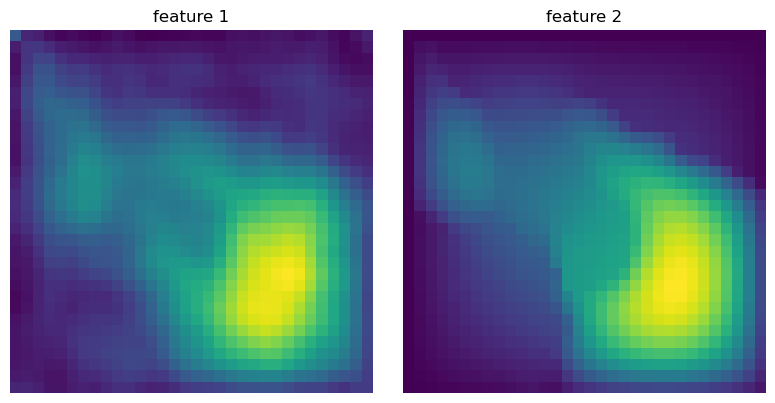

Epoch 28: Train=0.012697  Val=0.015250


Ep29:   0%|          | 0/140 [00:00<?, ?it/s]

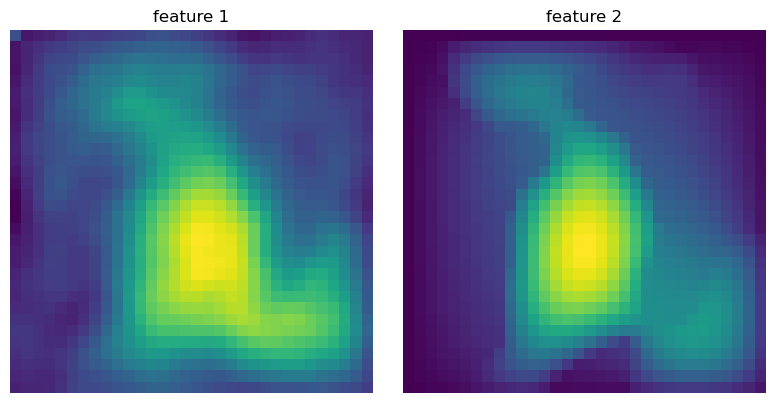

Ep29: 100%|██████████| 140/140 [00:29<00:00,  4.80it/s]


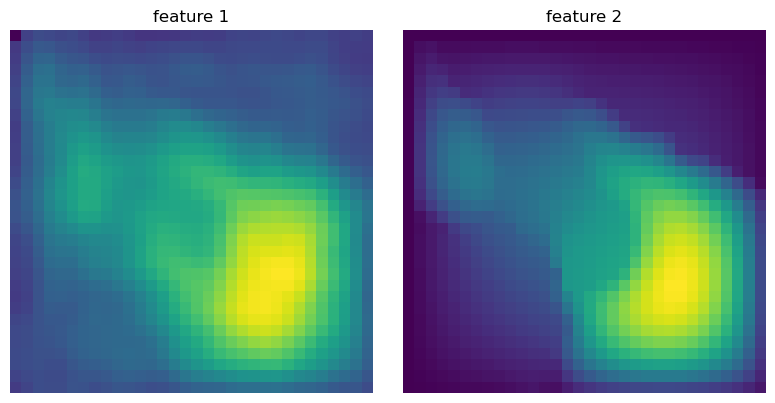

Epoch 29: Train=0.012524  Val=0.014773


Ep30:   0%|          | 0/140 [00:00<?, ?it/s]

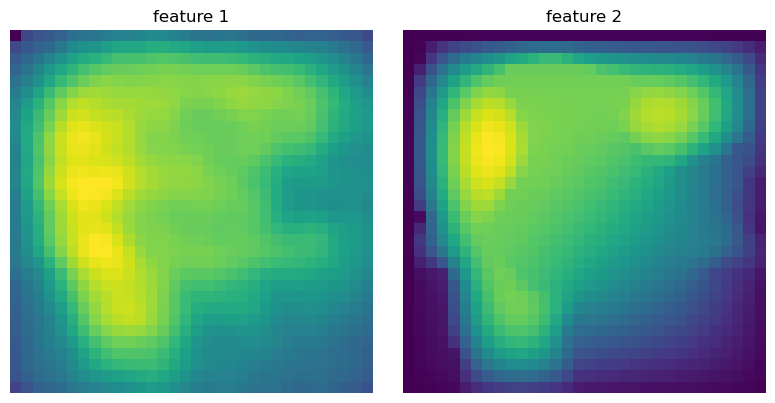

Ep30: 100%|██████████| 140/140 [00:29<00:00,  4.81it/s]


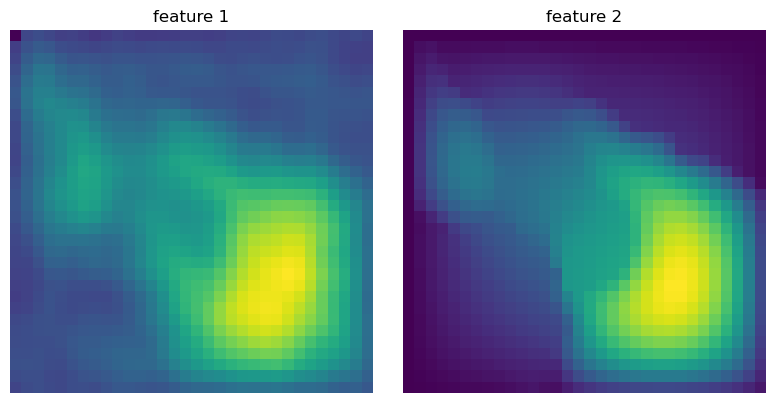

Epoch 30: Train=0.012480  Val=0.015341


In [61]:
best_model2 = train_spectral_sr(model_new, dataset, epochs=30, batch_size=32, lr=1e-3, device="cpu")

In [62]:
def run_and_plot_sr(x_hr, y_hr, model, title):
    """
    Spectral super-resolution visualization:
      - x_hr, y_hr: torch.Tensor [H, W] high-res ground truth
      - model: trained FreqSuperRes on CPU
    """
    model = model.to('cpu').eval()

    x_hr_t = x_hr.unsqueeze(0).unsqueeze(0)  # [1,1,32,32]
    y_hr_t = y_hr.unsqueeze(0).unsqueeze(0)

    x_lr = F.interpolate(x_hr_t, size=(16,16), mode='bilinear', align_corners=False)

    X32i = fft_upsample2x(x_lr)

    with torch.no_grad():
        X32r = model(X32i)               # [1,2,32,32]
    y_pred = ifft_from_real_imag(X32r)    # [1,1,32,32]

    x_hr_t = x_hr_t.squeeze().cpu().numpy()
    x_lr = x_lr.squeeze().cpu().numpy()
    y_true_img = y_hr.cpu().numpy()
    y_pred_img = y_pred.squeeze().cpu().numpy()

    fig, axs = plt.subplots(1,4, figsize=(16,4))
    axs[0].imshow(x_hr_t,      cmap='viridis'); axs[0].set_title(f"{title}: input HR")
    axs[1].imshow(x_lr,      cmap='viridis'); axs[1].set_title(f"{title}: input LR")
    axs[2].imshow(y_true_img,    cmap='viridis'); axs[2].set_title(f"{title}: true HR")
    axs[3].imshow(y_pred_img,    cmap='viridis'); axs[3].set_title(f"{title}: fft model prediction")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [63]:
torch.save(best_model2.state_dict(), "fft_cnn_highres.pth")

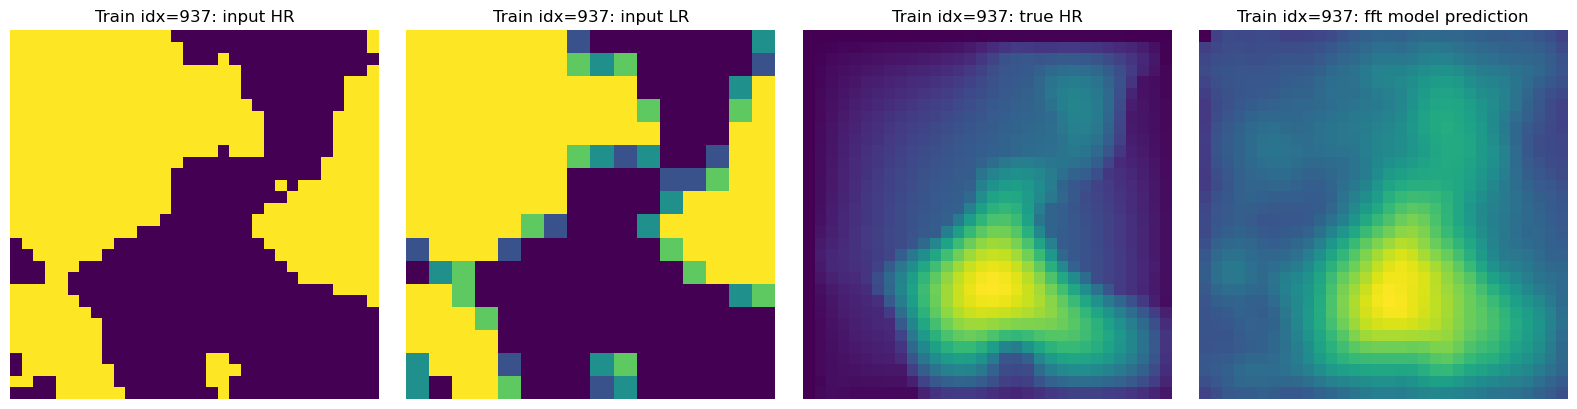

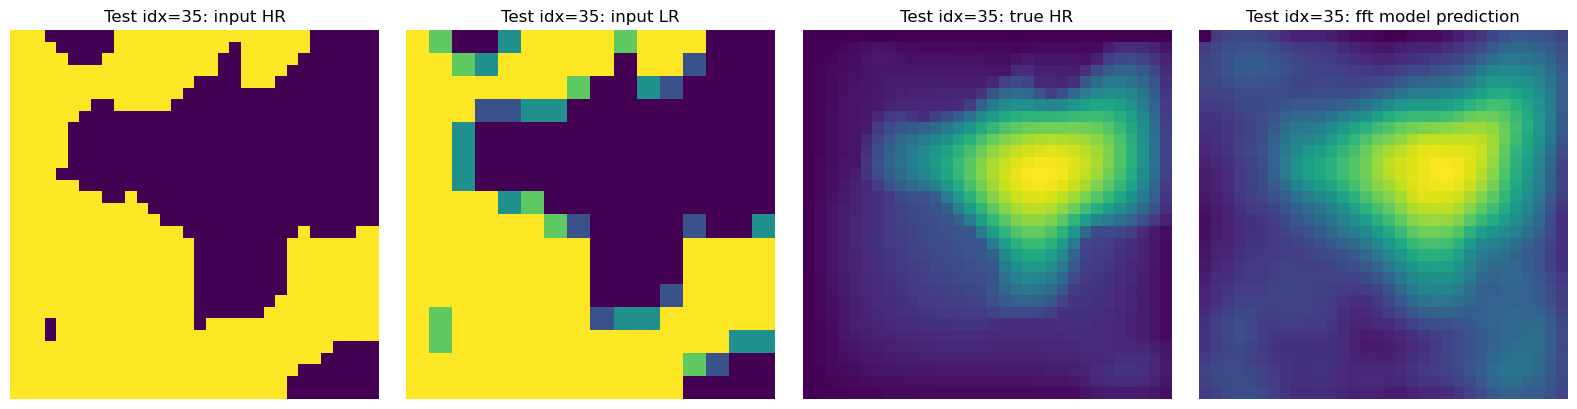

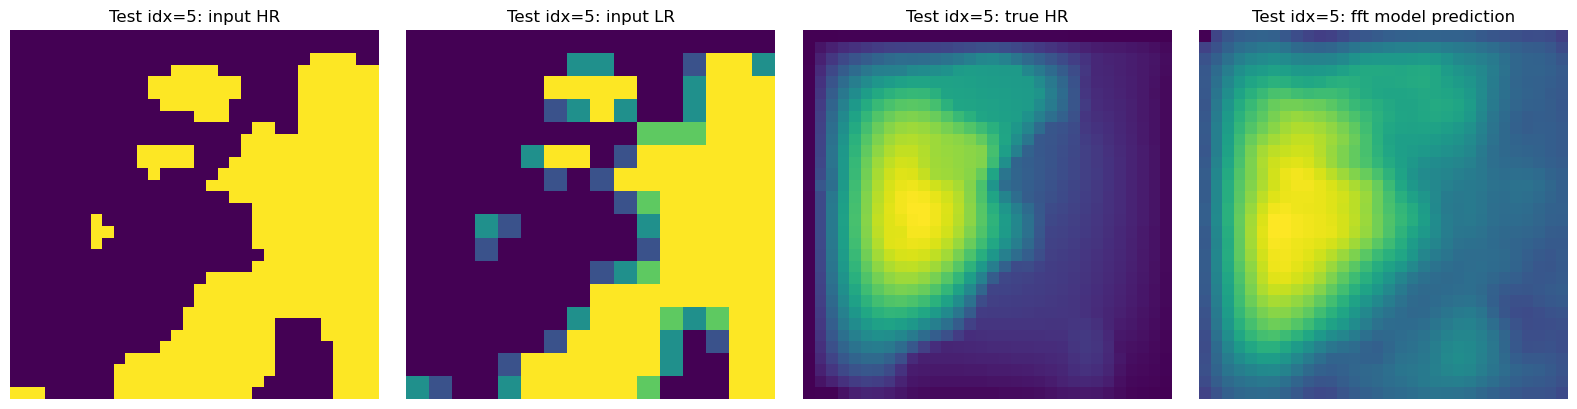

In [64]:
idx_train = 937
run_and_plot_sr(x_hr[idx_train], y_hr[idx_train], best_model2, f"Train idx={idx_train}")

idx_test = 35
run_and_plot_sr(x_hr_test[idx_test], y_hr_test[idx_test], best_model2, f"Test idx={idx_test}")

idx_test = 5
run_and_plot_sr(x_hr_test[idx_test], y_hr_test[idx_test], best_model2, f"Test idx={idx_test}")

In [102]:
def evaluate_sr_model(model: nn.Module,
                      test_dataset: torch.utils.data.Dataset,
                      batch_size: int = 32,
                      device: str = "cuda" if torch.cuda.is_available() else "cpu"):
    loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    mse_crit = nn.MSELoss(reduction='sum')
    model = model.to(device).eval()

    total_mse = 0.0
    total_pixels = 0

    with torch.no_grad():
        for data in loader:
            # shapes: [B,1,32,32]
            x_hr = data['x'].to(device)
            y_hr = data['y'].to(device)

            # 1) Downsample to 16×16
            x_lr = F.interpolate(x_hr, size=(16,16), mode='bilinear', align_corners=False)

            # 2) Zero‐pad FFT upsample → init spectrum [B,2,32,32]
            X32_init = fft_upsample2x(x_lr)

            # 3) Model refinement → [B,2,32,32]
            X32_ref  = model(X32_init)

            # 4) Inverse FFT → [B,1,32,32]
            y_pred   = ifft_from_real_imag(X32_ref).to(device)

            # 5) Sum‐of‐squares
            batch_mse = mse_crit(y_pred, y_hr)
            total_mse += batch_mse.item()

            B, C, H, W = y_hr.shape
            total_pixels += B * C * H * W

    rmse = (total_mse / total_pixels) ** 0.5
    print(f"Test RMSE: {rmse:.6f}")
    return rmse

In [103]:
rmse = evaluate_sr_model(best_model2, test_hr, batch_size=32, device="cpu")

Test RMSE: 0.117961
